In [1]:
!pip install einops
!pip install gdown
!pip install timm

import torch
import torch.optim as optim
import timm
# !pip install tensorflow-gpu
# Importing the libraries
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import gdown

import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange
from torchvision import transforms

from torchvision import datasets, models

import os
from skimage import io

import torch
from PIL import Image

import glob

from timm.scheduler.scheduler import Scheduler
from torch.cuda.amp import GradScaler, autocast
from timm.loss import LabelSmoothingCrossEntropy

from torch.optim.lr_scheduler import CosineAnnealingLR

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
Mounted at /content/drive
Wed Dec 20 20:45:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              25W / 300W |      0MiB / 16384Mi

In [2]:
# ------------------------------------------------------------------------------------------------------
# VIT MODEL
# ------------------------------------------------------------------------------------------------------

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            # nn.Linear(dim, num_classes) # Output (batch_size, num_classes)
            nn.Linear(dim, 128) # 128 desired embedding size (?)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

# -----------------------------------------------------------------------------------------------------------------------
# LOSS FUNCTION
# -----------------------------------------------------------------------------------------------------------------------
class RankingLoss:

  def __init__(self):
      pass

  def _label2similarity(sekf, label1, label2):
      '''
      compute similarity matrix of label1 and label2
      :param label1: torch.Tensor, [m]
      :param label2: torch.Tensor, [n]
      :return: torch.Tensor, [m, n], {0, 1}
      '''
      m, n = len(label1), len(label2)
      l1 = label1.view(m, 1).expand([m, n])
      l2 = label2.view(n, 1).expand([n, m]).t()
      similarity = l1 == l2
      return similarity

  def _batch_hard(self, mat_distance, mat_similarity, more_similar):

      if more_similar is 'smaller':
          sorted_mat_distance, _ = torch.sort(mat_distance + (-9999999.) * (1 - mat_similarity), dim=1, descending=True)
          hard_p = sorted_mat_distance[:, 0]
          sorted_mat_distance, _ = torch.sort(mat_distance + (9999999.) * (mat_similarity), dim=1, descending=False)
          hard_n = sorted_mat_distance[:, 0]
          return hard_p, hard_n

      elif more_similar is 'larger':
          sorted_mat_distance, _ = torch.sort(mat_distance + (9999999.) * (1 - mat_similarity), dim=1, descending=False)
          hard_p = sorted_mat_distance[:, 0]
          sorted_mat_distance, _ = torch.sort(mat_distance + (-9999999.) * (mat_similarity), dim=1, descending=True)
          hard_n = sorted_mat_distance[:, 0]
          return hard_p, hard_n


class TripletLoss(RankingLoss):
    '''
    Compute Triplet loss augmented with Batch Hard
    Details can be seen in 'In defense of the Triplet Loss for Person Re-Identification'
    Args:
        margin(float or 'soft'): if float, use nn.MarginRankingLoss, if 'soft',
    '''

    def __init__(self, margin, metric, reduce=True):
        '''
        :param margin: float or 'soft', for MarginRankingLoss with margin and soft margin
        :param bh: batch hard
        :param metric: l2 distance or cosine distance
        '''

        assert isinstance(margin, float) or margin=='soft', \
            'margin must be type float or value \'soft\', but got {}'.format(margin)
        if isinstance(margin, float):
            self.margin_loss = nn.MarginRankingLoss(margin=margin, reduce=reduce)
        elif margin == 'soft':
            self.margin_loss = nn.SoftMarginLoss(reduce=reduce)
        self.metric = metric

    def __call__(self, emb, label):
        '''
        :param emb: torch.Tensor, [m, dim]
        :param label: torch.Tensor, [b]
        '''
        if self.metric == 'cosine':
            mat_dist = cosine_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            hard_p, _ = self._batch_hard(mat_dist, mat_sim.float(), more_similar='larger')

            mat_dist = cosine_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            _, hard_n = self._batch_hard(mat_dist, mat_sim.float(), more_similar='larger')

            margin_label = -torch.ones_like(hard_p)

            # print(len(emb)) # batch-size
            # print(len(label))
            # print('Mat_dist : ', mat_dist)


        elif self.metric == 'euclidean':
            mat_dist = euclidean_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            hard_p, _ = self._batch_hard(mat_dist, mat_sim.float(), more_similar='smaller')

            mat_dist = euclidean_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            _, hard_n = self._batch_hard(mat_dist, mat_sim.float(), more_similar='smaller')

            margin_label = torch.ones_like(hard_p)

        if self.margin_loss.__class__.__name__ == 'MarginRankingLoss':
            return self.margin_loss(hard_n, hard_p, margin_label)
        elif self.margin_loss.__class__.__name__ == 'SoftMarginLoss':
            return self.margin_loss(hard_n-hard_p, margin_label)


def cosine_dist(x, y):
    '''
    compute cosine distance between two matrix x and y
    with size (n1, d) and (n2, d) and type torch.tensor
    return a matrix (n1, n2)
    '''

    x = F.normalize(x, p=2, dim=1)
    y = F.normalize(y, p=2, dim=1)
    return torch.matmul(x, y.transpose(0, 1))


def euclidean_dist(x, y):
    """
    compute euclidean distance between two matrix x and y
    with size (n1, d) and (n2, d) and type torch.tensor
    return a matrix (n1, n2)
    """
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist

# --------------------------------------------------------------------------------------------------------------------------------
# CUSTOMDATASET
# --------------------------------------------------------------------------------------------------------------------------------

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.image_paths, self.labels = self._load_dataset()

    def _load_dataset(self):
        image_paths = []
        labels = []

        for person_id in os.listdir(os.path.join(self.root_dir, self.split)):
            person_folder = os.path.join(self.root_dir, self.split, person_id)

            if os.path.isdir(person_folder):
                for filename in os.listdir(person_folder):
                    if filename.endswith('.jpg'):
                        image_paths.append(os.path.join(person_folder, filename))
                        labels.append(int(person_id))

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = io.imread(img_path)
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label



# --------------------------------------------------------------------------------------------------------
# CENTER LOSS
# --------------------------------------------------------------------------------------------------------

class CenterLoss(nn.Module):
  """Center loss.

  Reference:
  Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

  Args:
      num_classes (int): number of classes.
      feat_dim (int): feature dimension.
  """

  def __init__(self, num_classes=1501, feat_dim=2048, use_gpu=True):
      super(CenterLoss, self).__init__()
      self.num_classes = num_classes
      self.feat_dim = feat_dim
      self.use_gpu = use_gpu

      if self.use_gpu:
          self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
      else:
          self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

  def forward(self, x, labels):
      """
      Args:
          x: feature matrix with shape (batch_size, feat_dim).
          labels: ground truth labels with shape (num_classes).
      """
      assert x.size(0) == labels.size(0), "features.size(0) is not equal to labels.size(0)"

      batch_size = x.size(0)
      distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
      # distmat = torch.addmm(distmat, x, self.centers.t(), beta=1, alpha=-2)
      distmat.addmm_(1, -2, x.float(), self.centers.t())

      classes = torch.arange(self.num_classes).long()
      if self.use_gpu: classes = classes.cuda()
      labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
      mask = labels.eq(classes.expand(batch_size, self.num_classes))

      dist = []
      for i in range(batch_size):
          value = distmat[i][mask[i]]
          value = value.clamp(min=1e-12, max=1e+12)  # for numerical stability
          dist.append(value)
      dist = torch.cat(dist)
      loss = dist.mean()
      return loss

# ------------------------------------------------------------------------------------------------------------
# ONE LOSS FUNCTION TO RULE THEM ALL
# -------------------------------------------------------------------------------------------------------------

class TripletCenterLoss():
    # Triplet Loss (batch hard): This loss encourages the network to learn embeddings that capture the relative distance between
    # instances of the same person and different persons. It ensures that embeddings of the same person are closer together than those of different persons.

    # Center Loss: This loss helps the network to learn discriminative embeddings by maintaining fixed feature centers for each class.
    # It prevents the network from collapsing all feature representations into a single cluster.

    # Label Smoothing Cross-Entropy: This loss improves classification performance by penalizing the network
    # for assigning high confidence to incorrect labels. It helps the network to learn more robust and reliable class representations.

    def __init__(self, margin=0.5, metric='cosine', smoothing=0.1, num_classes=1501, feat_dim=256, lambda_center=0.3, lambda_smooth=0.1):
      self.loss_triplet = TripletLoss(margin, metric)
      self.loss_center = CenterLoss(num_classes, feat_dim, use_gpu=True)
      self.lambda_center = lambda_center

    def __call__(self, outputs, labels):
      loss_triplet = self.loss_triplet(outputs, labels)
      print("Loss triplet : ", loss_triplet)
      loss_center = self.loss_center(outputs, labels)
      print("Loss Center : ", loss_center)

      loss = loss_triplet + self.lambda_center * loss_center
      return loss

<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-34b6aa19432a>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if more_similar is 'smaller':
<ipython-input-2-34b6aa19432a>:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif more_similar is 'larger':


In [3]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [4]:
# --------------------------------------------------------------------------------------------
# MARKET1501 TRAINING
# --------------------------------------------------------------------------------------------
def main():
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((128, 128)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225]),
  ])

  dataset_root = '/content/drive/MyDrive/ViT/Data-Market/Market-1501-v15.09.15/pytorch/'

  train_dataset = CustomDataset(root_dir=dataset_root, transform=transform, split='train')
  val_dataset = CustomDataset(root_dir=dataset_root, transform=transform, split='val')

  train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

  # Defining model and training options
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

   # Define your vision transformer model
  model = ViT(
      image_size=(128, 128),
      patch_size=(8, 8),
      num_classes=1501,
      dim=128,
      depth=2,
      heads=2,
      mlp_dim=128*2,
      pool='cls',
      channels=3,
      dropout=0.1,
      emb_dropout=0.1
  ).to(device)

  # model.load_pretrained_weights('/content/drive/MyDrive/ViT/Pretrained/jx_vit_base_p16_224-80ecf9dd.pth')

  # Define your optimizer and loss function
  initial_learning_rate = 5e-3
  optimizer = Adam(model.parameters(), lr=initial_learning_rate, weight_decay=1e-5)
  criterion_features = TripletCenterLoss(margin=0.3, metric='cosine', num_classes=1501, feat_dim=128, lambda_center=0.1)
  # loss_smooth_fn = LabelSmoothingCrossEntropy(smoothing = 0.1)


  max_epochs  = 5
  # cooldown_epochs = 2  # Set the number of epochs
  warmup_epochs  = 1
  # Set up the learning rate scheduler
  scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=warmup_epochs, T_mult=1, eta_min=1e-6)
  # scheduler = timm.scheduler.CosineLRScheduler(optimizer, t_initial=training_epochs)
  # Create a learning rate scheduler
  # scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)

  # Create a GradScaler for automatic mixed-precision
  scaler = GradScaler()

  # Training loop
  for epoch in range(max_epochs):
      # num_steps_per_epoch = len(train_loader)
      # num_updates = epoch * num_steps_per_epoch
      # Training
      model.train()
      total_loss = 0.0
      for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False)):
          images, labels = batch
          if torch.cuda.is_available():
            images = images.to('cuda')
            labels = labels.to('cuda')
            print(images.shape)
          # Wrap the forward and backward passes with autocast
          with autocast():
            outputs = model(images)

            print("Output shape : ", outputs.shape)

            # loss_Smooth = loss_smooth_fn(outputs, labels)
            # print("Loss smooth : ", loss_Smooth)
            loss_Triplet_Center = criterion_features(outputs, labels)
            # loss = loss_Triplet_Center + 0.5*loss_Smooth
            loss = loss_Triplet_Center
            print("Total loss :", loss)

          # Update the learning rate within the loop
          scheduler.step(epoch + (i / len(train_dataloader)))

          # Scales the loss and performs backward pass
          scaler.scale(loss).backward()

          # Unscales the gradients and performs the optimizer step
          scaler.step(optimizer)

          # Updates the scale for next iteration
          scaler.update()

          optimizer.zero_grad()

      # scheduler.step(epoch + 1)
      print(f'Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item()}')

      # Validation
      model.eval()
      total_val_loss = 0.0
      num_val_batches = len(val_dataloader)

      with torch.no_grad():
          for val_batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} in validation", leave=False):
              val_images, val_labels = val_batch
              if torch.cuda.is_available():
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
              # Wrap the forward pass with autocast
              with autocast():
                  val_outputs = model(val_images)

                  # val_loss_Smooth = loss_smooth_fn(val_outputs, val_labels)

                  val_loss_Triplet_Center = criterion_features(val_outputs, val_labels)

                  # val_loss = val_loss_Triplet_Center + 0.5*val_loss_Smooth
                  val_loss = val_loss_Triplet_Center

              total_val_loss += val_loss

      average_val_loss = total_val_loss / num_val_batches
      print(f'Validation Epoch [{epoch+1}/{max_epochs}], Average Loss: {average_val_loss}')
      # Save the trained model
  torch.save(model.state_dict(), '/content/drive/MyDrive/ViT/Model/model_Market_v5_m03.pth')

In [ ]:
if __name__ == "__main__":
    main()

Using device:  cuda (Tesla V100-SXM2-16GB)


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Epoch 1 in training:   0%|          | 0/191 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2552, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(166.6284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(16.9180, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-2-34b6aa19432a>:330: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  distmat.addmm_(1, -2, x.float(), self.centers.t())
Epoch 1 in training:   1%|          | 2/191 [00:59<1:32:51, 29.48s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(168.5458, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(17.1143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   2%|▏         | 3/191 [01:27<1:30:11, 28.78s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1947, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(142.8678, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(14.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   2%|▏         | 4/191 [01:54<1:27:59, 28.23s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2080, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(138.3744, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(14.0455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   3%|▎         | 5/191 [02:22<1:27:32, 28.24s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(137.0559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.8852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   3%|▎         | 6/191 [02:51<1:27:34, 28.40s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(135.4696, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.7167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   4%|▎         | 7/191 [03:20<1:27:28, 28.52s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1687, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(133.6012, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   4%|▍         | 8/191 [03:48<1:26:32, 28.37s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1080, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(132.9221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   5%|▍         | 9/191 [04:16<1:25:32, 28.20s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1579, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.7653, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   5%|▌         | 10/191 [04:44<1:24:49, 28.12s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.2056, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.2620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   6%|▌         | 11/191 [05:11<1:23:36, 27.87s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1244, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(133.6180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   6%|▋         | 12/191 [05:39<1:23:11, 27.88s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(127.9034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   7%|▋         | 13/191 [06:06<1:22:23, 27.78s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(134.1804, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   7%|▋         | 14/191 [06:34<1:21:49, 27.74s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(132.6660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   8%|▊         | 15/191 [07:03<1:22:40, 28.18s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1315, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(132.0889, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   8%|▊         | 16/191 [07:31<1:21:43, 28.02s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.1905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   9%|▉         | 17/191 [07:59<1:21:04, 27.96s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.0206, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   9%|▉         | 18/191 [08:29<1:22:13, 28.52s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.5483, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.2509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  10%|▉         | 19/191 [08:57<1:21:22, 28.39s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(128.2707, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  10%|█         | 20/191 [09:25<1:21:12, 28.49s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1348, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.4339, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.0782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  11%|█         | 21/191 [09:54<1:20:46, 28.51s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.8345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.2065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  12%|█▏        | 22/191 [10:23<1:20:31, 28.59s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0767, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.2497, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.2017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  12%|█▏        | 23/191 [10:50<1:19:14, 28.30s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1355, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(126.5551, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.7910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  13%|█▎        | 24/191 [11:19<1:19:01, 28.39s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.1749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  13%|█▎        | 25/191 [11:48<1:18:42, 28.45s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.6452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  14%|█▎        | 26/191 [12:15<1:17:15, 28.10s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0886, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.6019, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.0488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  14%|█▍        | 27/191 [12:43<1:16:27, 27.97s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(128.8515, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  15%|█▍        | 28/191 [13:11<1:16:05, 28.01s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(127.3601, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.8091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  15%|█▌        | 29/191 [13:39<1:15:46, 28.07s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0618, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(133.2469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  16%|█▌        | 30/191 [14:07<1:15:36, 28.18s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1082, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.7316, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.0814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  16%|█▌        | 31/191 [14:35<1:14:33, 27.96s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(127.5594, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.8420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  17%|█▋        | 32/191 [15:02<1:13:44, 27.82s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1074, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(126.9727, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.8047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  17%|█▋        | 33/191 [15:32<1:14:54, 28.45s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1309, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(125.0660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.6375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  18%|█▊        | 34/191 [16:02<1:15:15, 28.76s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.0714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  18%|█▊        | 35/191 [16:29<1:13:28, 28.26s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1158, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(128.1821, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  19%|█▉        | 36/191 [16:56<1:12:20, 28.00s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.3020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  19%|█▉        | 37/191 [17:24<1:11:40, 27.93s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0892, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(132.6584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  20%|█▉        | 38/191 [17:51<1:10:57, 27.83s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0851, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(132.7531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  20%|██        | 39/191 [18:20<1:11:22, 28.17s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.7375, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  21%|██        | 40/191 [18:48<1:10:47, 28.13s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1160, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.3952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.2555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  21%|██▏       | 41/191 [19:16<1:09:56, 27.98s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.5889, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.0764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  22%|██▏       | 42/191 [19:44<1:09:42, 28.07s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0590, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.2220, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  23%|██▎       | 43/191 [20:13<1:09:37, 28.22s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.5431, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  23%|██▎       | 44/191 [20:40<1:07:55, 27.72s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(128.8426, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  24%|██▎       | 45/191 [21:07<1:07:12, 27.62s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.0881, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  24%|██▍       | 46/191 [21:34<1:06:35, 27.56s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.3951, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  25%|██▍       | 47/191 [22:02<1:06:12, 27.58s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.8094, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.0910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  25%|██▌       | 48/191 [22:29<1:05:37, 27.54s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.9673, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.0560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  26%|██▌       | 49/191 [22:57<1:05:14, 27.57s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(129.0004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.9787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  26%|██▌       | 50/191 [23:25<1:05:13, 27.76s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(130.7194, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  27%|██▋       | 51/191 [23:53<1:04:50, 27.79s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(132.0237, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  27%|██▋       | 52/191 [24:21<1:04:43, 27.94s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1124, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(131.1887, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.2313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  28%|██▊       | 53/191 [24:49<1:04:19, 27.97s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(126.8645, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.7885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  28%|██▊       | 54/191 [25:17<1:03:40, 27.89s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(127.8147, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.8408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  29%|██▉       | 55/191 [25:43<1:02:02, 27.37s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0497, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(133.0478, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.3545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  29%|██▉       | 56/191 [26:11<1:02:03, 27.58s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(134.2082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  30%|██▉       | 57/191 [26:40<1:02:35, 28.03s/it]

torch.Size([64, 3, 128, 128])
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0685, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(126.3291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.7014, device='cuda:0', grad_fn=<AddBackward0>)


In [21]:
# --------------------------------------------------------------------------------------------
# MNIST TRAINING
# --------------------------------------------------------------------------------------------

def main():
  # Create the dataset and dataloader
  transform = transforms.Compose([
    transforms.ToTensor(),
  ])

  # Load data
  train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
  test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
  test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

  # Defining model and training options
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

  model = ViT(image_size=(28, 28),
              patch_size=(7, 7),
              num_classes=10,
              dim=64,
              depth=2,
              heads=2,
              mlp_dim=64*2,
              pool='cls',
              channels=1,
              dim_head=64,
              dropout=0.1,
              emb_dropout=0.1
  ).to(device)

  # model.load_pretrained_weights('/content/drive/MyDrive/ViT/Pretrained/jx_vit_base_p16_224-80ecf9dd.pth')

  if torch.cuda.is_available():
    model.to('cuda')

  # Define your optimizer and loss function
  initial_learning_rate = 5e-3
  optimizer = Adam(model.parameters(), lr=initial_learning_rate, weight_decay=1e-5)
  criterion_features = TripletCenterLoss(margin=0.3, metric='cosine', num_classes=10, feat_dim=128, lambda_center=0.1)
  # loss_smooth_fn = LabelSmoothingCrossEntropy(smoothing = 0.1)


  max_epochs  = 5
  # cooldown_epochs = 2  # Set the number of epochs
  warmup_epochs  = 1
  # Set up the learning rate scheduler
  scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=warmup_epochs, T_mult=1, eta_min=1e-6)
  # scheduler = timm.scheduler.CosineLRScheduler(optimizer, t_initial=training_epochs)
  # Create a learning rate scheduler
  # scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)

  # Create a GradScaler for automatic mixed-precision
  scaler = GradScaler()

  # Training loop
  for epoch in range(max_epochs):
      # num_steps_per_epoch = len(train_loader)
      # num_updates = epoch * num_steps_per_epoch
      # Training
      model.train()
      total_loss = 0.0
      for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False)):
          images, labels = batch
          if torch.cuda.is_available():
            images = images.to('cuda')
            labels = labels.to('cuda')
          # Wrap the forward and backward passes with autocast
          with autocast():
            outputs = model(images)

            print("Output shape : ", outputs.shape)

            # loss_Smooth = loss_smooth_fn(outputs, labels)
            # print("Loss smooth : ", loss_Smooth)
            loss_Triplet_Center = criterion_features(outputs, labels)
            # loss = loss_Triplet_Center + 0.5*loss_Smooth
            loss = loss_Triplet_Center
            print("Total loss :", loss)

          # Update the learning rate within the loop
          scheduler.step(epoch + (i / len(train_loader)))

          # Scales the loss and performs backward pass
          scaler.scale(loss).backward()

          # Unscales the gradients and performs the optimizer step
          scaler.step(optimizer)

          # Updates the scale for next iteration
          scaler.update()

          optimizer.zero_grad()

      # scheduler.step(epoch + 1)
      print(f'Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item()}')

      # Validation
      model.eval()
      total_val_loss = 0.0
      num_val_batches = len(test_loader)

      with torch.no_grad():
          for val_batch in tqdm(test_loader, desc=f"Epoch {epoch + 1} in validation", leave=False):
              val_images, val_labels = val_batch
              if torch.cuda.is_available():
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
              # Wrap the forward pass with autocast
              with autocast():
                  val_outputs = model(val_images)

                  # val_loss_Smooth = loss_smooth_fn(val_outputs, val_labels)

                  val_loss_Triplet_Center = criterion_features(val_outputs, val_labels)

                  # val_loss = val_loss_Triplet_Center + 0.5*val_loss_Smooth
                  val_loss = val_loss_Triplet_Center

              total_val_loss += val_loss

      average_val_loss = total_val_loss / num_val_batches
      print(f'Validation Epoch [{epoch+1}/{max_epochs}], Average Loss: {average_val_loss}')
      # Save the trained model
  torch.save(model.state_dict(), '/content/drive/MyDrive/ViT/Model/model_MNIST_v5_m03.pth')

In [22]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Using device:  cuda (Tesla V100-SXM2-16GB)


Epoch 1 in training:   0%|          | 2/938 [00:00<00:59, 15.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4137, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(156.3453, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(16.0482, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(126.5611, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(13.1256, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4003, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(120.2981, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(12.4302, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3776, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:   1%|          | 6/938 [00:00<01:00, 15.36it/s]

Loss Center :  tensor(112.8215, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.6598, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3774, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(111.5768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.5350, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3729, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(110.3827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.4111, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3574, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(109.9962, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 1 in training:   1%|          | 8/938 [00:00<01:02, 14.85it/s]


Total loss : tensor(11.3570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3498, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(112.2461, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.5744, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3492, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(110.4353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.3928, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(110.9203, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.4410, device='cuda:0', grad_fn=<AddBackward0>)

Epoch 1 in training:   1%|▏         | 12/938 [00:00<00:59, 15.57it/s]


Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(111.4862, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.5018, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3512, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(109.3286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.2841, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3521, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(108.2000, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.1721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   2%|▏         | 16/938 [00:01<01:00, 15.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(107.8932, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.1452, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(108.2143, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.1789, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3535, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(108.0487, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.1584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   2%|▏         | 18/938 [00:01<01:01, 15.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3566, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(108.7565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(11.2322, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3541, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(105.8907, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.9431, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3553, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(104.6162, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.8169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   2%|▏         | 22/938 [00:01<01:00, 15.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3552, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(105.7810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.9333, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3573, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(104.2572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.7830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(100.8623, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.4484, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3747, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:   3%|▎         | 24/938 [00:01<00:59, 15.34it/s]

Loss Center :  tensor(102.8495, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.6597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(102.7335, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.6581, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(103.7246, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.8052, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(103.3509, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.7722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   3%|▎         | 28/938 [00:01<00:58, 15.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(99.7304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.4067, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4543, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(100.4539, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.4996, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4497, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(97.4557, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.1952, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5712, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(96.0203, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.1732, device='cuda:0', grad_fn

Epoch 1 in training:   3%|▎         | 32/938 [00:02<00:58, 15.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5288, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(93.4449, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.8733, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6735, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(97.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.4160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5738, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(93.8343, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.9573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   4%|▍         | 36/938 [00:02<01:00, 14.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4734, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(89.7827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.4517, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5270, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(93.8725, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.9142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5362, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(90.0737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.5436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   4%|▍         | 38/938 [00:02<01:02, 14.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5721, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(92.6032, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.8324, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6381, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(89.4124, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.5793, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6408, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(85.0128, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.1421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   4%|▍         | 42/938 [00:02<01:02, 14.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7057, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(93.2918, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(10.0349, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5762, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(80.6595, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.6421, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(74.5786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.0529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:   5%|▍         | 45/938 [00:02<00:54, 16.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(79.7004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.6100, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(84.0395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.0593, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6782, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(83.6851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.0467, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(82.4229, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.8627, device='cuda:0', grad_fn=<Add

Epoch 1 in training:   5%|▌         | 50/938 [00:03<00:49, 17.99it/s]

Loss Center :  tensor(83.6006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.9787, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6081, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(84.0205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.0101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(73.9765, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.9546, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5026, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(72.5852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.7611, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6993, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:   6%|▌         | 52/938 [00:03<00:48, 18.40it/s]

Loss Center :  tensor(78.5770, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.5570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5767, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(75.8712, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.1638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6859, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(68.9383, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5797, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8541, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(84.6719, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(9.3213, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6121, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:   6%|▌         | 58/938 [00:03<00:45, 19.15it/s]

tensor(68.0789, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.4200, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6756, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(75.7219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.2478, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7131, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(72.0133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.9144, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6549, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(79.1689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.5717, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6253, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:   6%|▋         | 60/938 [00:03<00:45, 19.21it/s]

Loss Center :  tensor(79.5859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.5839, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7104, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(76.3381, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.3442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(69.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.4921, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5648, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(73.2867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.8934, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7809, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:   7%|▋         | 66/938 [00:04<00:44, 19.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5263, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(68.1786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.3442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7720, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(81.9189, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.9639, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(69.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5284, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5106, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(71.2502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.6356, device='cuda:0', grad_fn=<Add

Epoch 1 in training:   7%|▋         | 70/938 [00:04<00:44, 19.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5136, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(69.9926, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5129, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5759, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(80.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.5909, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7218, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(79.7917, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(8.7009, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.5598, device='cuda:0', grad_fn=<Add

Epoch 1 in training:   8%|▊         | 75/938 [00:04<00:44, 19.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5878, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(66.4474, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.2325, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(71.0990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.8261, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7304, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.7582, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.9063, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6038, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.4833, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7521, device='cuda:0', grad_fn=<Add

Epoch 1 in training:   8%|▊         | 79/938 [00:04<00:44, 19.49it/s]

Loss Center :  tensor(73.1714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.9781, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6836, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(68.9883, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4924, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(65.0610, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.9985, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5764, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(57.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.3524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6644, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:   9%|▊         | 82/938 [00:04<00:42, 19.93it/s]

Loss Center :  tensor(69.1052, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(58.5301, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.3402, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6003, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(55.8504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.1853, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(62.9122, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7107, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:   9%|▉         | 87/938 [00:05<00:42, 20.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5846, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(54.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.0101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(62.9593, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.9961, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6600, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.3133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7913, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6466, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(68.7892, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5255, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  10%|▉         | 92/938 [00:05<00:42, 20.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6386, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(60.7185, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7105, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(57.5227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.3664, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(57.6362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.4110, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5524, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(66.6473, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.2171, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  10%|█         | 95/938 [00:05<00:42, 19.96it/s]

Loss Center :  tensor(67.7393, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5307, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(58.5103, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.4373, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5547, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(62.1992, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7746, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6635, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.8657, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.6501, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5037, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  11%|█         | 99/938 [00:05<00:42, 19.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5408, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.6423, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.5050, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.8619, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.9115, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7878, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.3139, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7192, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6748, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.1717, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.5920, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  11%|█         | 105/938 [00:05<00:40, 20.33it/s]

Loss Center :  tensor(53.4384, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.9044, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4737, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(52.4627, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.7200, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7969, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(68.8778, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.6847, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6481, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.2716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7753, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5735, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  12%|█▏        | 110/938 [00:06<00:41, 19.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6556, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.4630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.8019, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6077, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(56.6244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.2701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6075, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(52.1632, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.8239, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7467, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(61.8953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.9362, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  12%|█▏        | 113/938 [00:06<00:40, 20.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7992, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(62.1033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.0095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6539, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(52.9953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.9534, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(60.8915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.7363, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(55.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.1430, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  12%|█▏        | 116/938 [00:06<00:40, 20.22it/s]

tensor(5.7373, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4674, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(48.8394, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.3513, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4276, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(46.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0409, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(62.1357, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.8881, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(52.0569, device='cuda:0', grad_fn=<MeanBackward0>)
T

Epoch 1 in training:  13%|█▎        | 122/938 [00:06<00:39, 20.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4456, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(48.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.2622, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5798, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(54.1685, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.9966, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5962, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(51.4163, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.7378, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7249, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(67.7851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5034, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  14%|█▎        | 128/938 [00:07<00:39, 20.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(55.6492, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.2033, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(54.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.0127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5938, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(62.9043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.8843, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4754, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(52.9375, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.7691, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  14%|█▍        | 131/938 [00:07<00:39, 20.23it/s]

Loss Center :  tensor(47.3622, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.1734, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(52.7733, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.8779, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4467, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.1384, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6605, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3955, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.6121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2567, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6672, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  15%|█▍        | 137/938 [00:07<00:39, 20.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8730, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(63.7949, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.2524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(47.4055, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.2362, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7448, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.3050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.6753, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5531, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(47.2441, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.2775, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  15%|█▍        | 140/938 [00:07<00:39, 20.45it/s]

Loss triplet :  tensor(0.6671, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(55.2937, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.1965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.1466, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5538, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(55.3407, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.0879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.2596, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6857, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size

Epoch 1 in training:  16%|█▌        | 146/938 [00:07<00:38, 20.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(59.2552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.6418, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8251, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(56.2867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.4538, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6829, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(53.5727, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.0401, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5231, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.4684, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.9700, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  16%|█▌        | 149/938 [00:08<00:37, 20.80it/s]

Loss Center :  tensor(44.6840, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.9579, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5600, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(45.1031, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0703, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.4163, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6991, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7985, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(58.5029, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.6488, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7988, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  17%|█▋        | 155/938 [00:08<00:37, 20.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6391, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(47.9563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.4348, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6180, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.4443, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(43.0179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.8951, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.5529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5581, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  17%|█▋        | 158/938 [00:08<00:38, 20.41it/s]

Loss Center :  tensor(46.1613, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.2057, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5912, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.8920, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.8804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7792, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(67.7337, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(7.5526, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5901, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.2313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0132, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5693, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  17%|█▋        | 164/938 [00:08<00:37, 20.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.3115, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7022, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(55.2658, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.3217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(54.3302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(6.1741, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3663, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.8423, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5505, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  18%|█▊        | 167/938 [00:09<00:37, 20.33it/s]

Loss Center :  tensor(38.0394, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1870, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.6630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0224, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6714, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.9094, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.1624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(49.4850, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.5192, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3980, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  18%|█▊        | 172/938 [00:09<00:39, 19.46it/s]

Loss Center :  tensor(41.1395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5119, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5353, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.7477, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.8101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(47.6092, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.4313, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6268, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.0021, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.8270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  19%|█▉        | 176/938 [00:09<00:39, 19.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(47.3440, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.3440, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4710, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.4501, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6033, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.5774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5611, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7431, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.7538, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.9185, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  19%|█▉        | 178/938 [00:09<00:39, 19.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4753, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.5315, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1284, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3511, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.7991, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9311, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5428, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.1632, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4591, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8095, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(43.7807, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.1876, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  19%|█▉        | 182/938 [00:09<00:40, 18.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3315, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.1878, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8502, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3627, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.1010, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0728, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.4392, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7293, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5669, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.5395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6209, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  20%|██        | 188/938 [00:10<00:37, 20.00it/s]

tensor(41.0670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5506, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.6339, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6572, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.3823, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6954, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.7943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3467, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4875, device='cuda:0', grad_fn=<MeanBackward0>)
Los

Epoch 1 in training:  21%|██        | 193/938 [00:10<00:37, 19.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(43.3760, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.9416, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5454, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.9242, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7378, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5329, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.7903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9119, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7295, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.3826, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.9678, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  21%|██        | 197/938 [00:10<00:37, 19.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7016, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(46.1676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.3184, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3136, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.0449, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7181, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.3663, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2677, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6553, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.0990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0652, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  21%|██        | 199/938 [00:10<00:37, 19.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5400, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.0326, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7433, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.3929, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7886, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.8518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3863, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4939, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.9298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6869, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  22%|██▏       | 205/938 [00:10<00:36, 20.21it/s]

Loss Center :  tensor(33.3961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3875, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.6140, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2489, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3900, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.9440, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5844, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5913, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(42.3225, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.8236, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6539, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  22%|██▏       | 210/938 [00:11<00:37, 19.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5969, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.6632, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2632, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6113, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.4524, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3565, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6401, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.2833, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3684, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5262, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.2304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9492, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  23%|██▎       | 214/938 [00:11<00:37, 19.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6489, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.4702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0959, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.9744, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.8621, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6093, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.8196, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5912, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9477, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  23%|██▎       | 216/938 [00:11<00:37, 19.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6600, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.4055, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.6046, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4929, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7651, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(47.5327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.5183, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5286, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.2541, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6541, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  24%|██▎       | 221/938 [00:11<00:36, 19.69it/s]

Loss Center :  tensor(41.1371, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6774, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6233, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.8079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.1040, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4450, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.1161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4566, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7025, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(43.1791, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0205, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5045, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  24%|██▍       | 226/938 [00:12<00:36, 19.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3936, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0333, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.4799, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2413, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.2406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6929, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.7069, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6686, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  25%|██▍       | 230/938 [00:12<00:37, 19.13it/s]

Loss triplet :  tensor(0.4828, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.9438, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7772, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5699, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.1118, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6810, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4348, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.5715, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6920, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4155, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.6170, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  25%|██▍       | 234/938 [00:12<00:38, 18.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3447, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.9404, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1387, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5955, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.0927, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1047, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6924, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(50.8752, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.7799, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6402, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.1241, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5526, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  25%|██▌       | 238/938 [00:12<00:37, 18.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.4012, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7938, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.1670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9721, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6970, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.8515, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6821, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.7180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4191, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  26%|██▌       | 240/938 [00:12<00:39, 17.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4783, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.8050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4588, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.6017, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6678, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6657, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.5609, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  26%|██▌       | 244/938 [00:13<00:46, 14.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5425, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.4228, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2847, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.7671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2693, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.2191, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  26%|██▋       | 248/938 [00:13<00:46, 14.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6693, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(45.6751, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.2368, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.6043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5201, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7495, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(43.6441, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.1139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  27%|██▋       | 250/938 [00:13<00:47, 14.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5362, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.9758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5338, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.5650, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4257, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.8896, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  27%|██▋       | 254/938 [00:13<00:44, 15.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6187, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.6123, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4800, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4603, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.8131, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0416, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6202, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(44.2662, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0468, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.6226, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4329, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  28%|██▊       | 258/938 [00:14<00:44, 15.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4080, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.1201, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1200, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5773, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.4562, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4229, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4717, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.0349, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6751, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])

Epoch 1 in training:  28%|██▊       | 260/938 [00:14<00:44, 15.22it/s]


Loss triplet :  tensor(0.6012, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.7793, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9792, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4460, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.6011, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1061, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6261, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.4002, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6661, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5687, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  28%|██▊       | 264/938 [00:14<00:45, 14.95it/s]

Loss Center :  tensor(38.6002, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.9308, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1548, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6527, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.4253, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2952, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5866, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 1 in training:  28%|██▊       | 266/938 [00:14<00:44, 14.98it/s]


Loss Center :  tensor(31.6323, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7498, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4474, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.7583, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7232, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7072, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(43.7257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0798, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6723, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  29%|██▉       | 270/938 [00:14<00:44, 14.87it/s]

Loss Center :  tensor(41.2402, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7963, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3712, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9058, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5300, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.6827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8982, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4536, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.1900, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 1 in training:  29%|██▉       | 272/938 [00:15<00:44, 14.96it/s]


Total loss : tensor(3.2726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4526, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.0444, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0571, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5890, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.6745, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5564, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6737, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.8673, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  29%|██▉       | 276/938 [00:15<00:42, 15.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5863, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.1252, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6988, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7606, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.0398, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6894, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4530, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.9668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6497, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  30%|██▉       | 280/938 [00:15<00:42, 15.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4832, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.5260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4358, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.4976, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4186, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4984, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.8802, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7864, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5572, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 1 in training:  30%|███       | 284/938 [00:15<00:41, 15.80it/s]


Loss Center :  tensor(33.4154, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8988, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4256, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.6920, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1948, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.9100, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5147, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7252, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.1473, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  31%|███       | 288/938 [00:16<00:42, 15.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4443, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.3068, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8238, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.4156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.9654, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4143, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9381, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  31%|███       | 290/938 [00:16<00:43, 14.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7404, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7363, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.4837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4847, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3798, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  31%|███▏      | 294/938 [00:16<00:45, 14.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5616, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.1618, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0778, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6017, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.0761, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6093, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.0754, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  32%|███▏      | 296/938 [00:16<00:43, 14.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.2633, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9584, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5708, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2711, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.8651, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.6553, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5945, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0715, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  32%|███▏      | 302/938 [00:16<00:34, 18.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3287, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0033, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.0430, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5741, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5716, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.4716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8188, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3380, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.8260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9206, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  33%|███▎      | 307/938 [00:17<00:32, 19.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2948, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4898, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3438, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0776, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5321, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3308, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.4530, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2862, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4901, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.9271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1828, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  33%|███▎      | 311/938 [00:17<00:32, 19.59it/s]

tensor(26.6312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1167, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3451, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3507, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4370, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3933, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8763, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3218, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.7092, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7927, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3110, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  34%|███▎      | 315/938 [00:17<00:33, 18.77it/s]

Loss Center :  tensor(24.3835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7493, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.1779, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9425, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.1252, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0605, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.0694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  34%|███▍      | 317/938 [00:17<00:32, 18.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5601, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2287, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4171, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6478, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9819, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.0513, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4298, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3373, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.7891, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0162, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  34%|███▍      | 323/938 [00:17<00:30, 20.04it/s]

Loss Center :  tensor(19.8123, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2336, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.4382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8457, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.3025, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3988, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4235, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.2571, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2492, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5086, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  35%|███▍      | 327/938 [00:18<00:30, 19.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.1767, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2880, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4759, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.1665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5926, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3911, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.0212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9932, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2502, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0720, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0574, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  35%|███▌      | 332/938 [00:18<00:29, 20.22it/s]

Loss Center :  tensor(22.8020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5687, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3550, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0507, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5601, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.6153, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4004, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3562, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9361, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6213, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  36%|███▌      | 335/938 [00:18<00:31, 19.32it/s]

tensor(4.0922, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.9953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3589, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3927, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3046, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9232, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7474, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(39.8177, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  36%|███▌      | 340/938 [00:18<00:30, 19.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2257, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7444, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4001, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4975, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8363, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9811, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4131, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5631, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3986, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.1306, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3117, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  37%|███▋      | 343/938 [00:18<00:29, 20.31it/s]

tensor(30.3355, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6841, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4793, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7490, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.4739, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3664, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3822, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8155, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6769, device='cuda:0', grad_fn=<MeanBackward0>)
Los

Epoch 1 in training:  37%|███▋      | 349/938 [00:19<00:28, 20.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4815, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5240, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.5535, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1793, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.6701, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6930, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1982, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9845, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8967, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  38%|███▊      | 352/938 [00:19<00:28, 20.67it/s]

Loss Center :  tensor(27.4508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2980, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3308, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6484, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5957, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.0641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2028, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4170, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3208, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3719, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  38%|███▊      | 357/938 [00:19<00:29, 19.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0779, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3293, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1884, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0067, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6326, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.9727, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0299, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  39%|███▊      | 362/938 [00:19<00:28, 20.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3228, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0788, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0307, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5590, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.4387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2029, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4945, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.7741, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1454, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3975, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4851, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  39%|███▉      | 365/938 [00:20<00:28, 20.34it/s]

tensor(2.9176, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4986, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.7635, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5145, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.5419, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2687, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3446, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5785, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7604, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.6035, device='cuda:0', grad_fn=<MeanBackward0>)
T

Epoch 1 in training:  40%|███▉      | 371/938 [00:20<00:27, 20.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4687, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.4082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.5074, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2240, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8623, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5813, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.6367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5450, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  40%|███▉      | 374/938 [00:20<00:27, 20.43it/s]

Loss Center :  tensor(27.6522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2762, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4485, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8049, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2804, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8683, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9672, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4682, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.1588, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9840, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5534, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  40%|████      | 377/938 [00:20<00:28, 19.59it/s]

Total loss : tensor(3.4838, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.4179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8494, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2911, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2858, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7196, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4780, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.7289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3509, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6204, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  41%|████      | 383/938 [00:20<00:27, 20.24it/s]

Loss Center :  tensor(29.2361, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5440, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5808, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.2281, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5945, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.1822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5710, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6104, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  41%|████      | 386/938 [00:21<00:27, 20.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2908, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1839, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4759, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.6232, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2382, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3213, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5222, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1402, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8603, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4263, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  42%|████▏     | 392/938 [00:21<00:26, 20.23it/s]

Loss Center :  tensor(21.8046, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4798, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4312, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2583, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5501, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1412, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3768, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7517, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4864, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  42%|████▏     | 395/938 [00:21<00:27, 19.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.9167, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4388, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7616, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(40.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.7693, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3133, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2177, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4350, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0900, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7053, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  43%|████▎     | 401/938 [00:21<00:26, 20.19it/s]

Loss triplet :  tensor(0.6432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.3481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0780, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6612, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4238, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2843, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6324, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1476, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1672, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3690, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0041, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size

Epoch 1 in training:  43%|████▎     | 404/938 [00:21<00:26, 20.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3792, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9393, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3456, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6174, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5267, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6779, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0945, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2373, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1608, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8534, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  44%|████▎     | 410/938 [00:22<00:25, 20.42it/s]

Loss Center :  tensor(24.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8510, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7718, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4084, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9613, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5045, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3278, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3781, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3656, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6005, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  44%|████▍     | 413/938 [00:22<00:25, 20.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6528, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.5246, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5052, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4831, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8607, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5906, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.7484, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5654, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8888, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0079, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  45%|████▍     | 419/938 [00:22<00:25, 20.03it/s]

Total loss : tensor(2.6861, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6687, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.7627, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9450, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6783, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5298, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.2351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5533, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7465, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  45%|████▍     | 422/938 [00:22<00:25, 20.29it/s]

Loss Center :  tensor(33.9139, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1379, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4337, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0013, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.5034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0505, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2287, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6817, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2263, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  46%|████▌     | 428/938 [00:23<00:25, 20.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1551, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0330, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3719, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6551, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(36.2091, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.2760, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  46%|████▌     | 431/938 [00:23<00:25, 20.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3639, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3910, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3030, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3505, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1594, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1664, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8232, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2012, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0318, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  46%|████▋     | 434/938 [00:23<00:25, 20.07it/s]

Loss Center :  tensor(19.1312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3591, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5746, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0380, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2784, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4607, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0777, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5232, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0109, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3610, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  47%|████▋     | 440/938 [00:23<00:25, 19.91it/s]

tensor(20.0957, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3706, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.7558, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0183, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8122, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9172, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5551, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1547, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3315, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  47%|████▋     | 443/938 [00:23<00:24, 20.18it/s]

Loss Center :  tensor(17.3776, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0692, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3277, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5568, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6468, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.5350, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3003, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5913, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5120, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  48%|████▊     | 449/938 [00:24<00:24, 19.92it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4791, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.7829, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1574, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5434, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.3817, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2816, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4715, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.2053, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2921, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9906, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  48%|████▊     | 452/938 [00:24<00:24, 20.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3451, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3496, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4800, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6740, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.0315, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0772, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5529, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4813, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6666, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  49%|████▊     | 455/938 [00:24<00:24, 20.12it/s]

tensor(3.0468, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9388, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3481, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9122, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2393, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.1197, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3076, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4626, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3479, device='cuda:0', grad_fn=<MeanBackward0>)
T

Epoch 1 in training:  49%|████▉     | 460/938 [00:24<00:24, 19.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4881, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.8690, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4724, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4227, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9885, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6216, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3936, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9292, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2865, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  50%|████▉     | 466/938 [00:25<00:23, 19.81it/s]

Loss Center :  tensor(21.7177, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5351, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1874, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2337, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4714, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.6888, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1402, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4710, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7835, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4609, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  50%|████▉     | 468/938 [00:25<00:23, 19.65it/s]

Loss Center :  tensor(28.9665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3575, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3651, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3101, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3961, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0008, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4732, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1188, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1006, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2254, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  51%|█████     | 475/938 [00:25<00:23, 19.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5160, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5470, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8707, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4051, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9988, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4050, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6097, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.6312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5728, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3468, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4797, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  51%|█████     | 479/938 [00:25<00:23, 19.15it/s]

Loss triplet :  tensor(0.1802, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7543, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5557, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8384, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3696, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2665, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2487, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6755, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  51%|█████▏    | 481/938 [00:25<00:24, 19.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4875, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9341, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3614, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8213, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4631, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1991, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  52%|█████▏    | 487/938 [00:26<00:22, 20.03it/s]

Loss Center :  tensor(19.5524, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1905, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4564, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8619, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3318, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1598, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2833, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1129, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5945, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4604, device='cuda:0', grad_fn=<MeanB

Epoch 1 in training:  52%|█████▏    | 492/938 [00:26<00:22, 20.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6785, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5496, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.8120, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2370, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5388, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3845, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2030, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4404, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0471, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  53%|█████▎    | 495/938 [00:26<00:22, 19.83it/s]

Loss Center :  tensor(27.4826, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1990, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2439, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5892, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8029, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4199, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5640, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5763, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5184, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9384, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  53%|█████▎    | 497/938 [00:26<00:24, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2882, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4557, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9337, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3669, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6873, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4309, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.0667, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  53%|█████▎    | 501/938 [00:26<00:27, 16.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1089, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6981, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3419, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2844, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3576, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7430, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3687, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  54%|█████▍    | 505/938 [00:27<00:27, 15.80it/s]

Loss Center :  tensor(16.8969, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0584, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8865, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2295, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9728, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5443, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4245, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  54%|█████▍    | 507/938 [00:27<00:27, 15.45it/s]

Loss Center :  tensor(20.6319, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4877, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4603, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6625, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4043, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.6796, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7723, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3483, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  54%|█████▍    | 511/938 [00:27<00:27, 15.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2993, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5788, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4572, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2010, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5838, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8412, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5090, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  55%|█████▍    | 515/938 [00:27<00:28, 14.92it/s]

Loss Center :  tensor(24.2983, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9388, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2308, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2882, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6596, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4304, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.4184, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2723, device='cuda:0', grad_fn=<AddBackward0>)
Output shape : 

Epoch 1 in training:  55%|█████▌    | 517/938 [00:28<00:28, 14.82it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7947, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4171, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6892, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3186, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 1 in training:  56%|█████▌    | 521/938 [00:28<00:27, 15.38it/s]


Loss Center :  tensor(13.5618, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2750, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6922, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6568, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9011, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3442, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  56%|█████▌    | 523/938 [00:28<00:27, 15.20it/s]

Loss Center :  tensor(19.4835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2925, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.6743, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4151, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2820, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9677, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9787, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1887, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2167, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 1 in training:  56%|█████▌    | 527/938 [00:28<00:28, 14.54it/s]


Total loss : tensor(1.5104, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2924, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5407, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7464, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4129, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  56%|█████▋    | 529/938 [00:28<00:28, 14.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5590, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.8886, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4479, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2786, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8397, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3955, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet : 

Epoch 1 in training:  57%|█████▋    | 533/938 [00:29<00:26, 15.08it/s]

 tensor(0.3109, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3027, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0411, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4494, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8899, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0486, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9070, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3819, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  57%|█████▋    | 535/938 [00:29<00:27, 14.79it/s]

Loss Center :  tensor(18.5078, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2327, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4515, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8223, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4220, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5674, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  57%|█████▋    | 539/938 [00:29<00:26, 15.22it/s]

Loss Center :  tensor(26.7959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2470, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0862, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.3168, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8575, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3989, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2770, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  58%|█████▊    | 543/938 [00:29<00:26, 15.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5198, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.0691, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0267, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3020, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0763, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5725, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  58%|█████▊    | 545/938 [00:29<00:26, 14.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2904, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9813, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2756, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9210, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8677, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3620, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7237, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  59%|█████▊    | 549/938 [00:30<00:27, 14.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4383, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0259, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5409, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0721, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.0757, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  59%|█████▊    | 551/938 [00:30<00:27, 13.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0595, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7947, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1976, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3172, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7293, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3587, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  

Epoch 1 in training:  59%|█████▉    | 556/938 [00:30<00:22, 16.98it/s]

tensor(0.3958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.1556, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6114, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1941, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4750, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6416, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1340, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4957, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5443, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.9288, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2372, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss

Epoch 1 in training:  60%|█████▉    | 559/938 [00:30<00:20, 18.15it/s]

Loss Center :  tensor(17.8940, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0362, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4788, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4561, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7244, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3823, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0442, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5867, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3281, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2728, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1553, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0646, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  60%|██████    | 565/938 [00:31<00:19, 18.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4325, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2397, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2467, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2830, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3504, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7368, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8241, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5829, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1136, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  60%|██████    | 567/938 [00:31<00:19, 18.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6809, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4897, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5919, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6489, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3215, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0560, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2075, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  61%|██████    | 573/938 [00:31<00:18, 19.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5039, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9977, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3841, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7026, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1544, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2318, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7229, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4041, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5345, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.3110, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5656, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  62%|██████▏   | 577/938 [00:31<00:19, 18.90it/s]

Loss triplet :  tensor(0.2881, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7722, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1530, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8589, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5389, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2677, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7065, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0383, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7055, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  62%|██████▏   | 581/938 [00:31<00:19, 18.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4168, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2738, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2575, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6593, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3629, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5424, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2172, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4454, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0939, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  62%|██████▏   | 585/938 [00:32<00:18, 19.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9415, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4385, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2750, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2660, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8998, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2210, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8878, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5098, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  63%|██████▎   | 589/938 [00:32<00:18, 19.37it/s]

tensor(0.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6246, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7538, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9000, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5341, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3582, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7718, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss

Epoch 1 in training:  63%|██████▎   | 594/938 [00:32<00:17, 20.11it/s]

Loss Center :  tensor(15.2489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9678, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3435, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0134, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9449, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2538, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2258, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7764, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3784, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5114, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2296, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2368, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  64%|██████▍   | 599/938 [00:32<00:16, 20.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4112, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0242, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7136, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6444, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7859, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1579, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7351, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2841, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4184, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  64%|██████▍   | 602/938 [00:32<00:16, 20.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7453, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7670, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9598, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6297, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7482, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9083, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3826, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9160, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4742, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  65%|██████▍   | 608/938 [00:33<00:15, 20.89it/s]

tensor(16.7123, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0184, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4675, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8626, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6538, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6527, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1273, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0654, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2272, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0383, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6310, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3615, device='cuda:0', grad_fn=<MeanBackward0>)
Los

Epoch 1 in training:  65%|██████▌   | 611/938 [00:33<00:15, 20.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9207, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7158, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2637, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4217, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8745, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1887, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4277, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  66%|██████▌   | 617/938 [00:33<00:15, 20.46it/s]

Total loss : tensor(2.1701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3738, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4943, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9103, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5274, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5089, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7941, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3755, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  66%|██████▌   | 620/938 [00:33<00:15, 20.72it/s]

Loss Center :  tensor(18.4038, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2159, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1972, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3722, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9278, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3095, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2440, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4330, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  67%|██████▋   | 626/938 [00:34<00:15, 20.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4691, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9586, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6649, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0907, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8320, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3212, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5853, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8798, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5344, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8397, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  67%|██████▋   | 629/938 [00:34<00:15, 20.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1917, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4549, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2068, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2956, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7364, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3883, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4034, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2458, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  68%|██████▊   | 635/938 [00:34<00:14, 20.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3886, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1671, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4435, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4055, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2840, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.3224, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6690, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6545, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.8984, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6443, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  68%|██████▊   | 638/938 [00:34<00:14, 20.56it/s]

tensor(19.2970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2960, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3348, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1018, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7450, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2578, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6954, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8273, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9576, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4825, device='cuda:0', grad_fn=<MeanBackward0>)
Los

Epoch 1 in training:  69%|██████▊   | 644/938 [00:34<00:14, 20.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2415, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8822, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5345, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4500, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2255, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8256, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4081, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4444, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2647, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4709, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  69%|██████▉   | 647/938 [00:35<00:14, 20.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3943, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4707, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4748, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5035, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9251, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4696, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3691, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7919, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7170, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  69%|██████▉   | 650/938 [00:35<00:14, 20.40it/s]

Loss Center :  tensor(19.3681, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2805, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4517, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9257, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2459, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2011, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5660, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3352, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1371, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2827, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  70%|██████▉   | 656/938 [00:35<00:13, 20.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4631, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.6730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2304, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3599, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6646, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1264, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3305, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7501, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0055, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2369, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6789, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  70%|███████   | 659/938 [00:35<00:13, 20.64it/s]

Total loss : tensor(1.9122, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2276, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8397, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7116, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3482, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3202, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2802, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8643, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2079, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2374, device='cuda:0', grad_fn=<MeanB

Epoch 1 in training:  71%|███████   | 665/938 [00:36<00:13, 20.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1476, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4610, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2937, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3491, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8687, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2360, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1610, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3376, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1948, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9080, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  71%|███████▏  | 670/938 [00:36<00:13, 19.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5184, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3354, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6519, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8878, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0368, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5580, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9127, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8493, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1800, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1994, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  72%|███████▏  | 673/938 [00:36<00:13, 20.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1476, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7373, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1041, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0019, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5119, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3894, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1449, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1945, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2644, device='cuda:0', grad_fn=<AddBa

Epoch 1 in training:  72%|███████▏  | 676/938 [00:36<00:12, 20.19it/s]

tensor(16.2564, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9931, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3155, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0562, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9211, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8011, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5197, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6678, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7230, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1313, device='cuda:0', grad_fn=<MeanBackward0>)
Los

Epoch 1 in training:  73%|███████▎  | 682/938 [00:36<00:12, 20.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6610, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0555, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1549, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5806, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2129, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3422, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9496, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0371, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6120, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2309, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  73%|███████▎  | 687/938 [00:37<00:12, 19.84it/s]

tensor(17.5434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1308, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1637, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6640, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1359, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  74%|███████▎  | 691/938 [00:37<00:12, 19.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.6462, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0966, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1464, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8420, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2306, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1180, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3556, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6562, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5656, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  74%|███████▍  | 695/938 [00:37<00:12, 19.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3977, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3199, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6297, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3732, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2962, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9956, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0925, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2463, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  74%|███████▍  | 697/938 [00:37<00:12, 18.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5410, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2177, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5345, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9631, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2422, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0127, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  75%|███████▍  | 703/938 [00:37<00:11, 19.98it/s]

Loss Center :  tensor(20.7712, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6263, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3930, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9134, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2844, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1985, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4429, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1428, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2632, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9735, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9605, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0742, device='cuda:0', grad_fn=<MeanB

Epoch 1 in training:  75%|███████▌  | 708/938 [00:38<00:11, 19.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1202, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2219, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8653, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7744, device='cuda:0', grad_fn=<AddBa

Epoch 1 in training:  76%|███████▌  | 712/938 [00:38<00:11, 19.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8930, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3390, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3797, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3770, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2875, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9955, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8870, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0012, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  76%|███████▋  | 716/938 [00:38<00:11, 19.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0049, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8199, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8036, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4979, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9771, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5060, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2681, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  77%|███████▋  | 718/938 [00:38<00:11, 18.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4249, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1397, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2389, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4917, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2137, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4049, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5516, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0601, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5104, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6029, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6707, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  77%|███████▋  | 724/938 [00:39<00:10, 20.14it/s]

Loss Center :  tensor(10.1264, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1484, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1805, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9057, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3710, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1841, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2346, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3076, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3828, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2991, device='cuda:0', grad_fn=<Mean

Epoch 1 in training:  77%|███████▋  | 726/938 [00:39<00:10, 19.28it/s]


Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5582, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.1629, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4745, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9948, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2066, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7606, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6827, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2495, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  78%|███████▊  | 732/938 [00:39<00:10, 19.96it/s]

Loss Center :  tensor(11.4811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3976, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4692, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5336, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0871, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9222, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9793, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4234, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1114, device='cuda:0', grad_fn=<MeanB

Epoch 1 in training:  78%|███████▊  | 736/938 [00:39<00:10, 19.46it/s]

Loss Center :  tensor(9.6337, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3047, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8162, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6863, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3048, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2625, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3938, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0019, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 1 in training:  79%|███████▊  | 738/938 [00:39<00:10, 19.43it/s]

Loss triplet :  tensor(0.2050, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5647, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4350, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4182, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7609, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6345, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3643, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5777, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  79%|███████▉  | 743/938 [00:40<00:10, 18.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5303, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5453, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2658, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9277, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1197, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3482, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0546, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2997, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5285, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8526, device='cuda:0', grad_fn=<AddBa

Epoch 1 in training:  80%|███████▉  | 748/938 [00:40<00:10, 18.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3050, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6185, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9668, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1772, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9853, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2757, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3495, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5374, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0032, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1659, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8924, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3552, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  80%|███████▉  | 750/938 [00:40<00:10, 17.36it/s]

Loss triplet :  tensor(0.4171, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.6680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7839, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2352, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5535, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1905, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0820, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6973, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  80%|████████  | 754/938 [00:40<00:12, 15.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1213, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6683, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0881, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6340, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7906, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8131, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  81%|████████  | 756/938 [00:40<00:12, 15.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4286, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1870, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2454, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8926, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5242, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4009, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 1 in training:  81%|████████  | 758/938 [00:41<00:12, 14.87it/s]

Loss Center :  tensor(18.5464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2556, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1219, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0374, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1609, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  81%|████████  | 762/938 [00:41<00:12, 14.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.3039, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3881, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3777, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9117, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0688, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3840, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7816, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7622, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 1 in training:  82%|████████▏ | 766/938 [00:41<00:12, 13.99it/s]

Loss triplet :  tensor(0.6110, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.0164, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4755, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2005, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8175, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  82%|████████▏ | 768/938 [00:41<00:11, 14.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2183, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4419, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1445, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2537, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2304, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1420, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4446, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 1 in training:  82%|████████▏ | 772/938 [00:42<00:11, 14.52it/s]

Loss triplet :  tensor(0.2153, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1766, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5443, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0281, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1914, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  83%|████████▎ | 774/938 [00:42<00:11, 13.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4058, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5290, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8080, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5992, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  83%|████████▎ | 776/938 [00:42<00:12, 13.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4772, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2383, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1369, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7586, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  83%|████████▎ | 780/938 [00:42<00:11, 13.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8999, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4585, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2292, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2201, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6957, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  84%|████████▎ | 784/938 [00:42<00:11, 13.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8516, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1563, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1047, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6078, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9655, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  84%|████████▍ | 786/938 [00:43<00:10, 13.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5446, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5364, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4726, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3100, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4712, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9623, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4674, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  

Epoch 1 in training:  84%|████████▍ | 790/938 [00:43<00:10, 14.14it/s]

torch.Size([64, 128])
Loss triplet :  tensor(0.5477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1443, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8621, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4263, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4240, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6687, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7583, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  84%|████████▍ | 792/938 [00:43<00:10, 14.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3235, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2252, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8460, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3654, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1540, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2649, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  85%|████████▍ | 796/938 [00:43<00:10, 13.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2356, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2340, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3589, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.9541, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3600, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4972, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8252, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  85%|████████▌ | 798/938 [00:43<00:10, 13.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4714, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4978, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2862, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3628, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6926, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  86%|████████▌ | 802/938 [00:44<00:09, 13.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6364, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7996, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4341, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0942, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2435, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2404, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6165, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  86%|████████▌ | 804/938 [00:44<00:09, 14.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4718, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9398, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0271, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4602, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3490, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2453, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7177, device='cuda:0', grad_fn=<AddBa

Epoch 1 in training:  86%|████████▌ | 809/938 [00:44<00:07, 17.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4109, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1958, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2996, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1356, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7132, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1545, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6029, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1148, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5956, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  87%|████████▋ | 814/938 [00:44<00:06, 18.62it/s]

Loss Center :  tensor(11.5605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3821, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3300, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1618, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8462, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0890, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9226, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0812, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5011, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4993, device='cuda:0', grad_fn=<MeanB

Epoch 1 in training:  87%|████████▋ | 818/938 [00:45<00:06, 19.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0056, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8332, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1754, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9713, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3725, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3268, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4371, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6737, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3174, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1055, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  88%|████████▊ | 823/938 [00:45<00:05, 19.74it/s]


Loss triplet :  tensor(0.3123, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8259, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3280, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3754, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9655, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3319, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9139, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2376, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1411, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  88%|████████▊ | 827/938 [00:45<00:05, 19.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4560, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0063, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1567, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8254, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1400, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2859, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5009, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5472, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  88%|████████▊ | 829/938 [00:45<00:05, 18.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2193, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2925, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5075, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.6597, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8735, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3092, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9703, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7293, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  89%|████████▉ | 835/938 [00:45<00:05, 20.05it/s]

Loss Center :  tensor(17.0279, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.6126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5125, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4374, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1046, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9832, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3592, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1785, device='cuda:0', grad_fn=<MeanB

Epoch 1 in training:  89%|████████▉ | 839/938 [00:46<00:05, 19.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4975, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0815, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3056, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0871, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0831, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1865, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8037, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2732, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3739, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8106, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  90%|████████▉ | 844/938 [00:46<00:04, 19.46it/s]

Loss triplet :  tensor(0.3653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3501, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0003, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3193, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9594, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0896, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4409, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9337, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4641, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0534, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  90%|█████████ | 848/938 [00:46<00:04, 19.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0897, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2091, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2211, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4312, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7992, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3726, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0361, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  91%|█████████ | 850/938 [00:46<00:04, 19.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1725, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1998, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4925, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2553, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4463, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4999, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6281, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7373, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2197, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1733, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  91%|█████████▏| 857/938 [00:47<00:04, 19.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4376, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7847, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2161, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1226, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3032, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7364, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9071, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3440, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0140, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  92%|█████████▏| 859/938 [00:47<00:03, 19.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2994, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4347, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7429, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6360, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7990, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3739, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3738, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0375, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8776, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  92%|█████████▏| 864/938 [00:47<00:03, 19.14it/s]

tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2649, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8802, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9475, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7689, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  93%|█████████▎| 868/938 [00:47<00:03, 19.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4474, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0336, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5892, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3317, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0224, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7196, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2275, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5316, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4807, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  93%|█████████▎| 873/938 [00:47<00:03, 19.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2668, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4888, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4974, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2635, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3152, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4950, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2153, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7462, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3899, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  93%|█████████▎| 875/938 [00:47<00:03, 19.70it/s]

Loss triplet :  tensor(0.5697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8008, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7497, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5741, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9891, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0799, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7525, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0552, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size(

Epoch 1 in training:  94%|█████████▍| 880/938 [00:48<00:02, 19.43it/s]

Loss Center :  tensor(19.3486, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2990, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9695, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8837, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1277, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0722, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1349, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4238, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7092, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 1 in training:  94%|█████████▍| 884/938 [00:48<00:02, 18.76it/s]

Loss triplet :  tensor(0.3633, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3109, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8477, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9957, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5624, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4680, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  95%|█████████▍| 888/938 [00:48<00:02, 18.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8012, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2450, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0288, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5479, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2267, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2658, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5533, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3184, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6305, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  95%|█████████▌| 893/938 [00:48<00:02, 19.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1648, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3781, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1026, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6867, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4737, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7159, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3309, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  96%|█████████▌| 897/938 [00:49<00:02, 19.01it/s]


Loss triplet :  tensor(0.1744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2630, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.2898, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4151, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2201, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4074, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2301, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  96%|█████████▌| 899/938 [00:49<00:02, 18.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8188, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1056, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5531, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9093, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9440, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5503, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1884, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3265, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6402, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7905, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  96%|█████████▋| 904/938 [00:49<00:01, 18.69it/s]

Loss Center :  tensor(15.4988, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9152, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3335, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6780, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9710, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2633, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9152, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1 in training:  97%|█████████▋| 908/938 [00:49<00:01, 18.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2903, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5570, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9460, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4626, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5767, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2203, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9847, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3749, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5009, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9250, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  97%|█████████▋| 913/938 [00:49<00:01, 19.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4103, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4390, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4542, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4425, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8450, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1270, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4246, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0551, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1826, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6767, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1503, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  98%|█████████▊| 915/938 [00:50<00:01, 18.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1908, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4550, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3363, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3607, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8389, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1892, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3535, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0772, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9521, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0724, device='cuda:0', grad_fn=<AddB

Epoch 1 in training:  98%|█████████▊| 921/938 [00:50<00:00, 19.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2091, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6663, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3757, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1319, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4763, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2796, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3893, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5803, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3473, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8679, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3607, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  99%|█████████▊| 925/938 [00:50<00:00, 18.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2629, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9109, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5540, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2602, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5274, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7129, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3974, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9527, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2547, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1226, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5669, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  99%|█████████▉| 929/938 [00:50<00:00, 18.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8978, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3272, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6226, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2434, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9555, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2639, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9871, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6626, device='cuda:0', grad_fn=<Add

Epoch 1 in training:  99%|█████████▉| 931/938 [00:50<00:00, 18.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2984, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1995, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0032, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3998, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0113, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2944, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2375, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2051, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7580, device='cuda:0', grad_fn=<Add

Epoch 1 in training: 100%|█████████▉| 936/938 [00:51<00:00, 19.17it/s]

Loss triplet :  tensor(0.1349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9050, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1013, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6027, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9616, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5678, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8410, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5519, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2251, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3735, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4625, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([

Loss triplet :  tensor(0.2794, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5316, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/5, Loss: 2.5315890312194824


Epoch 1 in validation:   3%|▎         | 5/157 [00:00<00:03, 47.41it/s]

Loss triplet :  tensor(0.1507, device='cuda:0')
Loss Center :  tensor(7.5557, device='cuda:0')
Loss triplet :  tensor(0.0025, device='cuda:0')
Loss Center :  tensor(3.5217, device='cuda:0')
Loss triplet :  tensor(0.0567, device='cuda:0')
Loss Center :  tensor(4.7086, device='cuda:0')
Loss triplet :  tensor(0.2554, device='cuda:0')
Loss Center :  tensor(10.7153, device='cuda:0')
Loss triplet :  tensor(0.1307, device='cuda:0')
Loss Center :  tensor(9.5930, device='cuda:0')
Loss triplet :  tensor(0.3449, device='cuda:0')
Loss Center :  tensor(16.2920, device='cuda:0')
Loss triplet :  tensor(0.0733, device='cuda:0')
Loss Center :  tensor(7.0798, device='cuda:0')
Loss triplet :  tensor(0.3299, device='cuda:0')


Epoch 1 in validation:   6%|▋         | 10/157 [00:00<00:03, 45.68it/s]

Loss Center :  tensor(12.5848, device='cuda:0')
Loss triplet :  tensor(0.2954, device='cuda:0')
Loss Center :  tensor(13.1750, device='cuda:0')
Loss triplet :  tensor(0.2944, device='cuda:0')
Loss Center :  tensor(12.5441, device='cuda:0')


Epoch 1 in validation:  10%|▉         | 15/157 [00:00<00:03, 46.76it/s]

Loss triplet :  tensor(0.2202, device='cuda:0')
Loss Center :  tensor(9.5201, device='cuda:0')
Loss triplet :  tensor(0.1920, device='cuda:0')
Loss Center :  tensor(12.5898, device='cuda:0')
Loss triplet :  tensor(0.1904, device='cuda:0')
Loss Center :  tensor(9.4213, device='cuda:0')
Loss triplet :  tensor(0.0827, device='cuda:0')
Loss Center :  tensor(5.9126, device='cuda:0')
Loss triplet :  tensor(0.3786, device='cuda:0')
Loss Center :  tensor(18.1956, device='cuda:0')
Loss triplet :  tensor(0.2303, device='cuda:0')
Loss Center :  tensor(12.0019, device='cuda:0')
Loss triplet :  tensor(0.3583, device='cuda:0')
Loss Center :  tensor(13.8578, device='cuda:0')
Loss triplet :  

Epoch 1 in validation:  13%|█▎        | 20/157 [00:00<00:02, 47.27it/s]

tensor(0.2608, device='cuda:0')
Loss Center :  tensor(11.6255, device='cuda:0')
Loss triplet :  tensor(0.5074, device='cuda:0')
Loss Center :  tensor(22.7490, device='cuda:0')
Loss triplet :  tensor(0.5179, device='cuda:0')
Loss Center :  tensor(26.1137, device='cuda:0')


Epoch 1 in validation:  16%|█▌        | 25/157 [00:00<00:02, 47.04it/s]

Loss triplet :  tensor(0.4732, device='cuda:0')
Loss Center :  tensor(22.9383, device='cuda:0')
Loss triplet :  tensor(0.2444, device='cuda:0')
Loss Center :  tensor(9.5015, device='cuda:0')
Loss triplet :  tensor(0.6981, device='cuda:0')
Loss Center :  tensor(25.9823, device='cuda:0')
Loss triplet :  tensor(0.3678, device='cuda:0')
Loss Center :  tensor(14.2871, device='cuda:0')
Loss triplet :  tensor(0.3292, device='cuda:0')
Loss Center :  tensor(13.3241, device='cuda:0')
Loss triplet :  tensor(0.3683, device='cuda:0')
Loss Center :  tensor(12.4243, device='cuda:0')
Loss triplet :  tensor(0.4231, device='cuda:0')
Loss Center :  tensor(20.9519, device='cuda:0')


Epoch 1 in validation:  19%|█▉        | 30/157 [00:00<00:02, 47.54it/s]

Loss triplet :  tensor(0.3351, device='cuda:0')
Loss Center :  tensor(16.6328, device='cuda:0')
Loss triplet :  tensor(0.1464, device='cuda:0')
Loss Center :  tensor(10.6890, device='cuda:0')
Loss triplet :  tensor(0.1881, device='cuda:0')
Loss Center :  tensor(8.4362, device='cuda:0')


Epoch 1 in validation:  22%|██▏       | 35/157 [00:00<00:02, 47.05it/s]

Loss triplet :  tensor(0.3780, device='cuda:0')
Loss Center :  tensor(15.6535, device='cuda:0')
Loss triplet :  tensor(0.4167, device='cuda:0')
Loss Center :  tensor(20.6955, device='cuda:0')
Loss triplet :  tensor(0.4559, device='cuda:0')
Loss Center :  tensor(17.5641, device='cuda:0')
Loss triplet :  tensor(0.4649, device='cuda:0')
Loss Center :  tensor(19.6563, device='cuda:0')
Loss triplet :  tensor(0.3513, device='cuda:0')
Loss Center :  tensor(16.7351, device='cuda:0')
Loss triplet :  tensor(0.2839, device='cuda:0')
Loss Center :  tensor(12.8304, device='cuda:0')
Loss triplet :  tensor(0.1467, device='cuda:0')
Loss Center :  tensor(7.4139, device='cuda:0')


Epoch 1 in validation:  25%|██▌       | 40/157 [00:00<00:02, 46.17it/s]

Loss triplet :  tensor(0.4771, device='cuda:0')
Loss Center :  tensor(21.4224, device='cuda:0')
Loss triplet :  tensor(0.2400, device='cuda:0')
Loss Center :  tensor(10.1896, device='cuda:0')
Loss triplet :  tensor(0.0945, device='cuda:0')
Loss Center :  tensor(6.1312, device='cuda:0')


Epoch 1 in validation:  29%|██▊       | 45/157 [00:00<00:02, 46.54it/s]

Loss triplet :  tensor(0.4542, device='cuda:0')
Loss Center :  tensor(17.7941, device='cuda:0')
Loss triplet :  tensor(0.3125, device='cuda:0')
Loss Center :  tensor(13.6932, device='cuda:0')
Loss triplet :  tensor(0.1395, device='cuda:0')
Loss Center :  tensor(6.5368, device='cuda:0')
Loss triplet :  tensor(0.1693, device='cuda:0')
Loss Center :  tensor(10.7333, device='cuda:0')
Loss triplet :  tensor(0.2344, device='cuda:0')
Loss Center :  tensor(9.4973, device='cuda:0')
Loss triplet :  tensor(0.5335, device='cuda:0')
Loss Center :  tensor(22.1227, device='cuda:0')
Loss triplet :  tensor(0.2548, device='cuda:0')
Loss Center :  tensor(9.7853, device='cuda:0')


Epoch 1 in validation:  32%|███▏      | 50/157 [00:01<00:02, 46.10it/s]

Loss triplet :  tensor(0.1939, device='cuda:0')
Loss Center :  tensor(7.4773, device='cuda:0')
Loss triplet :  tensor(0.4251, device='cuda:0')
Loss Center :  tensor(17.9917, device='cuda:0')
Loss triplet :  tensor(0.1563, device='cuda:0')
Loss Center :  tensor(10.0260, device='cuda:0')


Epoch 1 in validation:  35%|███▌      | 55/157 [00:01<00:02, 46.34it/s]

Loss triplet :  tensor(0.1334, device='cuda:0')
Loss Center :  tensor(11.2923, device='cuda:0')
Loss triplet :  tensor(0.2008, device='cuda:0')
Loss Center :  tensor(8.6736, device='cuda:0')
Loss triplet :  tensor(0.3123, device='cuda:0')
Loss Center :  tensor(12.9799, device='cuda:0')
Loss triplet :  tensor(0.1350, device='cuda:0')
Loss Center :  tensor(9.3487, device='cuda:0')
Loss triplet :  tensor(0.2607, device='cuda:0')
Loss Center :  tensor(9.9718, device='cuda:0')
Loss triplet :  tensor(0.3934, device='cuda:0')
Loss Center :  tensor(16.0741, device='cuda:0')
Loss triplet :  tensor(0.1688, device='cuda:0')
Loss Center :  tensor(9.2445, device='cuda:0')
Loss triplet :  tensor(0.1835, device='cuda:0')
Loss Center :  tensor(8.3321, device='cuda:0')
Loss triplet :  tensor(0.3899, device='cuda:0')
Loss Center :  tensor(18.9358, device='cuda:0')
Loss triplet :  tensor(0.5757, device='cuda:0')


Epoch 1 in validation:  41%|████▏     | 65/157 [00:01<00:02, 45.96it/s]

Loss Center :  tensor(26.3949, device='cuda:0')
Loss triplet :  tensor(0.3593, device='cuda:0')
Loss Center :  tensor(17.6349, device='cuda:0')
Loss triplet :  tensor(0.3998, device='cuda:0')
Loss Center :  tensor(14.9110, device='cuda:0')
Loss triplet :  tensor(0.2508, device='cuda:0')
Loss Center :  tensor(10.6753, device='cuda:0')
Loss triplet :  tensor(0.3166, device='cuda:0')
Loss Center :  tensor(13.3823, device='cuda:0')
Loss triplet :  tensor(0.0685, device='cuda:0')
Loss Center :  tensor(6.3587, device='cuda:0')
Loss triplet :  tensor(0.4701, device='cuda:0')
Loss Center :  tensor(14.2301, device='cuda:0')
Loss triplet :  tensor(0.5334, device='cuda:0')
Loss Center :  tensor(17.5163, device='cuda:0')
Loss triplet :  tensor(0.3768, device='cuda:0')
Loss Center :  tensor(15.9173, device='cuda:0')
Loss triplet :  tensor(0.3039, device='cuda:0')
Loss Center :  tensor(13.6186, device='cuda:0')


Epoch 1 in validation:  48%|████▊     | 76/157 [00:01<00:01, 47.14it/s]

Loss triplet :  tensor(0.3276, device='cuda:0')
Loss Center :  tensor(13.2097, device='cuda:0')
Loss triplet :  tensor(0.2459, device='cuda:0')
Loss Center :  tensor(9.5986, device='cuda:0')
Loss triplet :  tensor(0.2544, device='cuda:0')
Loss Center :  tensor(11.2777, device='cuda:0')
Loss triplet :  tensor(0.1319, device='cuda:0')
Loss Center :  tensor(7.4552, device='cuda:0')
Loss triplet :  tensor(0.2095, device='cuda:0')
Loss Center :  tensor(9.5433, device='cuda:0')
Loss triplet :  tensor(0.1907, device='cuda:0')
Loss Center :  tensor(9.6967, device='cuda:0')
Loss triplet :  tensor(0.4940, device='cuda:0')
Loss Center :  tensor(21.0530, device='cuda:0')
Loss triplet :  tensor(0.3354, device='cuda:0')
Loss Center :  tensor(13.2048, device='cuda:0')
Loss triplet :  tensor(0.3128, device='cuda:0')
Loss Center :  tensor(12.9001, device='cuda:0')
Loss triplet :  tensor(0.1279, device='cuda:0')
Loss Center :  tensor(5.6518, device='cuda:0')


Epoch 1 in validation:  52%|█████▏    | 81/157 [00:01<00:01, 45.49it/s]

Loss triplet :  tensor(0.1020, device='cuda:0')
Loss Center :  tensor(5.5885, device='cuda:0')
Loss triplet :  tensor(0.2967, device='cuda:0')
Loss Center :  tensor(9.2989, device='cuda:0')
Loss triplet :  tensor(0.0478, device='cuda:0')
Loss Center :  tensor(4.4816, device='cuda:0')
Loss triplet :  tensor(0.0718, device='cuda:0')
Loss Center :  tensor(5.4561, device='cuda:0')
Loss triplet :  tensor(0.0846, device='cuda:0')
Loss Center :  tensor(4.0879, device='cuda:0')
Loss triplet :  tensor(0.0416, device='cuda:0')
Loss Center :  tensor(3.8204, device='cuda:0')
Loss triplet :  tensor(0.0603, device='cuda:0')
Loss Center :  tensor(2.7531, device='cuda:0')


Epoch 1 in validation:  55%|█████▌    | 87/157 [00:01<00:01, 46.29it/s]

Loss triplet :  tensor(0.0091, device='cuda:0')
Loss Center :  tensor(3.9515, device='cuda:0')
Loss triplet :  tensor(0.0862, device='cuda:0')
Loss Center :  tensor(7.4039, device='cuda:0')
Loss triplet :  tensor(0.1754, device='cuda:0')
Loss Center :  tensor(7.9861, device='cuda:0')


Epoch 1 in validation:  59%|█████▊    | 92/157 [00:01<00:01, 46.26it/s]

Loss triplet :  tensor(0.1362, device='cuda:0')
Loss Center :  tensor(7.1328, device='cuda:0')
Loss triplet :  tensor(0.0329, device='cuda:0')
Loss Center :  tensor(3.1366, device='cuda:0')
Loss triplet :  tensor(0.2416, device='cuda:0')
Loss Center :  tensor(15.2542, device='cuda:0')
Loss triplet :  tensor(0.2603, device='cuda:0')
Loss Center :  tensor(18.7113, device='cuda:0')
Loss triplet :  tensor(0.1524, device='cuda:0')
Loss Center :  tensor(12.7942, device='cuda:0')
Loss triplet :  tensor(0.2137, device='cuda:0')
Loss Center :  tensor(10.6044, device='cuda:0')
Loss triplet :  tensor(0.0657, device='cuda:0')


Epoch 1 in validation:  62%|██████▏   | 97/157 [00:02<00:01, 45.92it/s]

Loss Center :  tensor(10.8892, device='cuda:0')
Loss triplet :  tensor(0.1317, device='cuda:0')
Loss Center :  tensor(11.3438, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.6127, device='cuda:0')
Loss triplet :  tensor(0.0144, device='cuda:0')


Epoch 1 in validation:  65%|██████▍   | 102/157 [00:02<00:01, 46.11it/s]

Loss Center :  tensor(1.7934, device='cuda:0')
Loss triplet :  tensor(0.0513, device='cuda:0')
Loss Center :  tensor(5.6825, device='cuda:0')
Loss triplet :  tensor(0.1220, device='cuda:0')
Loss Center :  tensor(4.6876, device='cuda:0')
Loss triplet :  tensor(0.1029, device='cuda:0')
Loss Center :  tensor(5.0232, device='cuda:0')
Loss triplet :  tensor(0.2503, device='cuda:0')
Loss Center :  tensor(14.5452, device='cuda:0')
Loss triplet :  tensor(0.2517, device='cuda:0')
Loss Center :  tensor(14.3926, device='cuda:0')
Loss triplet :  tensor(0.0709, device='cuda:0')
Loss Center :  tensor(6.1938, device='cuda:0')


Epoch 1 in validation:  68%|██████▊   | 107/157 [00:02<00:01, 45.60it/s]

Loss triplet :  tensor(0.2166, device='cuda:0')
Loss Center :  tensor(11.9053, device='cuda:0')
Loss triplet :  tensor(0.1634, device='cuda:0')
Loss Center :  tensor(8.9475, device='cuda:0')
Loss triplet :  tensor(0.0631, device='cuda:0')


Epoch 1 in validation:  71%|███████▏  | 112/157 [00:02<00:00, 45.61it/s]

Loss Center :  tensor(6.9228, device='cuda:0')
Loss triplet :  tensor(0.0289, device='cuda:0')
Loss Center :  tensor(2.9668, device='cuda:0')
Loss triplet :  tensor(0.0020, device='cuda:0')
Loss Center :  tensor(2.6674, device='cuda:0')
Loss triplet :  tensor(0.0016, device='cuda:0')
Loss Center :  tensor(2.6539, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.6137, device='cuda:0')
Loss triplet :  tensor(0.0046, device='cuda:0')
Loss Center :  tensor(4.2632, device='cuda:0')
Loss triplet :  tensor(0.0632, device='cuda:0')
Loss Center :  tensor(5.3031, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.8707, device='cuda:0')


Epoch 1 in validation:  75%|███████▍  | 117/157 [00:02<00:00, 45.90it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.6470, device='cuda:0')
Loss triplet :  tensor(0.3259, device='cuda:0')
Loss Center :  tensor(13.6900, device='cuda:0')
Loss triplet :  tensor(0.0801, device='cuda:0')


Epoch 1 in validation:  78%|███████▊  | 122/157 [00:02<00:00, 46.13it/s]

Loss Center :  tensor(4.8940, device='cuda:0')
Loss triplet :  tensor(0.0136, device='cuda:0')
Loss Center :  tensor(2.1577, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(2.3487, device='cuda:0')
Loss triplet :  tensor(0.0019, device='cuda:0')
Loss Center :  tensor(3.3620, device='cuda:0')
Loss triplet :  tensor(0.0680, device='cuda:0')
Loss Center :  tensor(4.9433, device='cuda:0')
Loss triplet :  tensor(0.1938, device='cuda:0')
Loss Center :  tensor(16.2338, device='cuda:0')
Loss triplet :  tensor(0.1677, device='cuda:0')
Loss Center :  tensor(12.2742, device='cuda:0')
Loss triplet :  tensor(0.0719, device='cuda:0')
Loss Center :  tensor(5.1821, device='cuda:0')


Epoch 1 in validation:  81%|████████  | 127/157 [00:02<00:00, 45.76it/s]

Loss triplet :  tensor(0.0013, device='cuda:0')
Loss Center :  tensor(2.4645, device='cuda:0')
Loss triplet :  tensor(0.0900, device='cuda:0')
Loss Center :  tensor(6.8002, device='cuda:0')


Epoch 1 in validation:  84%|████████▍ | 132/157 [00:02<00:00, 45.78it/s]

Loss triplet :  tensor(0.0085, device='cuda:0')
Loss Center :  tensor(3.3200, device='cuda:0')
Loss triplet :  tensor(0.2131, device='cuda:0')
Loss Center :  tensor(11.7931, device='cuda:0')
Loss triplet :  tensor(0.1994, device='cuda:0')
Loss Center :  tensor(12.6971, device='cuda:0')
Loss triplet :  tensor(0.1322, device='cuda:0')
Loss Center :  tensor(8.8911, device='cuda:0')
Loss triplet :  tensor(0.1916, device='cuda:0')
Loss Center :  tensor(10.1338, device='cuda:0')
Loss triplet :  tensor(0.0241, device='cuda:0')
Loss Center :  tensor(4.2883, device='cuda:0')
Loss triplet :  tensor(0.0665, device='cuda:0')
Loss Center :  tensor(6.6194, device='cuda:0')
Loss triplet :  tensor(0.0369, device='cuda:0')
Loss Center :  tensor(4.7681, device='cuda:0')


Epoch 1 in validation:  87%|████████▋ | 137/157 [00:03<00:00, 39.84it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.6407, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5250, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5562, device='cuda:0')
Loss triplet :  tensor(0.0003, device='cuda:0')
Loss Center :  tensor(1.8789, device='cuda:0')
Loss triplet :  tensor(0.0008, device='cuda:0')
Loss Center :  tensor(1.6632, device='cuda:0')
Loss triplet :  tensor(0.1787, device='cuda:0')


Epoch 1 in validation:  90%|█████████ | 142/157 [00:03<00:00, 38.08it/s]

Loss Center :  tensor(13.0536, device='cuda:0')
Loss triplet :  tensor(0.1721, device='cuda:0')
Loss Center :  tensor(16.5937, device='cuda:0')


Epoch 1 in validation:  93%|█████████▎| 146/157 [00:03<00:00, 36.07it/s]

Loss triplet :  tensor(0.0003, device='cuda:0')
Loss Center :  tensor(2.0192, device='cuda:0')
Loss triplet :  tensor(0.0078, device='cuda:0')
Loss Center :  tensor(4.4133, device='cuda:0')
Loss triplet :  tensor(0.0024, device='cuda:0')
Loss Center :  tensor(1.6325, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(2.5092, device='cuda:0')
Loss triplet :  tensor(0.0012, device='cuda:0')
Loss Center :  tensor(1.8493, device='cuda:0')
Loss triplet :  tensor(0.0619, device='cuda:0')
Loss Center :  tensor(4.8638, device='cuda:0')
Loss triplet :  tensor(0.0849, device='cuda:0')
Loss Center :  tensor(4.7211, device='cuda:0')


Epoch 1 in validation:  98%|█████████▊| 154/157 [00:03<00:00, 34.88it/s]

Loss triplet :  tensor(0.0324, device='cuda:0')
Loss Center :  tensor(3.1177, device='cuda:0')
Loss triplet :  tensor(0.2034, device='cuda:0')
Loss Center :  tensor(10.0183, device='cuda:0')
Loss triplet :  tensor(0.2762, device='cuda:0')
Loss Center :  tensor(13.3759, device='cuda:0')
Loss triplet :  tensor(0.3274, device='cuda:0')
Loss Center :  tensor(24.2657, device='cuda:0')
Loss triplet :  tensor(0.1767, device='cuda:0')
Loss Center :  tensor(9.2658, device='cuda:0')


Loss triplet :  tensor(0.4067, device='cuda:0')
Loss Center :  tensor(18.9540, device='cuda:0')
Loss triplet :  tensor(0.2359, device='cuda:0')
Loss Center :  tensor(13.7699, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.1568, device='cuda:0')


Validation Epoch [1/5], Average Loss: 1.1978949308395386


Epoch 2 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2629, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8063, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4517, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   0%|          | 2/938 [00:00<01:09, 13.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3570, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0601, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   0%|          | 4/938 [00:00<01:05, 14.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3284, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1597, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8444, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1930, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0418, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4972, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:   1%|          | 6/938 [00:00<01:03, 14.70it/s]

Loss Center :  tensor(18.6100, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1296, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  

Epoch 2 in training:   1%|          | 8/938 [00:00<01:05, 14.15it/s]

tensor(0.4814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.9640, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2778, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5718, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.0937, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0812, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4177, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4574, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   1%|          | 10/938 [00:00<01:08, 13.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3438, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4870, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7020, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5816, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   1%|▏         | 14/938 [00:01<01:06, 13.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4583, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7162, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3299, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2891, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7935, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   2%|▏         | 16/938 [00:01<01:06, 13.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9993, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7561, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2909, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9640, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  

Epoch 2 in training:   2%|▏         | 18/938 [00:01<01:04, 14.18it/s]

tensor(25.1461, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   2%|▏         | 20/938 [00:01<01:06, 13.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3624, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2283, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5852, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2813, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3145, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.3668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   2%|▏         | 22/938 [00:01<01:06, 13.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0981, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1110, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1092, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4201, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   3%|▎         | 24/938 [00:01<01:06, 13.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.9357, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   3%|▎         | 26/938 [00:01<01:04, 14.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4187, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3944, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5582, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4400, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7856, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.5885, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4389, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3792, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:   3%|▎         | 28/938 [00:02<01:03, 14.24it/s]

Loss Center :  tensor(22.4067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6198, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1146, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6030, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5749, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  

Epoch 2 in training:   3%|▎         | 30/938 [00:02<01:02, 14.58it/s]

torch.Size([64, 128])
Loss triplet :  tensor(0.6392, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.4663, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7858, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4758, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.6565, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 2 in training:   3%|▎         | 32/938 [00:02<01:01, 14.81it/s]


Total loss : tensor(2.9415, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2089, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0985, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5287, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4970, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2911, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0029, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:   4%|▎         | 34/938 [00:02<01:02, 14.47it/s]

Total loss : tensor(2.1913, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2509, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5394, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:   4%|▍         | 36/938 [00:02<01:02, 14.49it/s]

Loss Center :  tensor(33.2327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8626, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4583, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:   4%|▍         | 38/938 [00:02<01:03, 14.23it/s]

Loss Center :  tensor(26.6576, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1240, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5484, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.4931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3977, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   4%|▍         | 40/938 [00:02<01:06, 13.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.3823, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0823, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4017, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1968, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   4%|▍         | 42/938 [00:03<01:05, 13.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.1373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5924, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6423, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.7398, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7163, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2710, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   5%|▍         | 44/938 [00:03<01:06, 13.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.7984, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   5%|▍         | 46/938 [00:03<01:07, 13.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5743, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.3529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4331, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.6297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   5%|▌         | 48/938 [00:03<01:02, 14.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4751, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.5588, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5310, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4770, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.4307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   5%|▌         | 50/938 [00:03<00:57, 15.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3853, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3174, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5170, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1495, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5462, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   6%|▌         | 52/938 [00:03<00:54, 16.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2912, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1275, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6440, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.4394, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   6%|▌         | 54/938 [00:03<00:52, 16.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5333, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.5523, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0885, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3266, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5372, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   6%|▌         | 56/938 [00:03<00:51, 17.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5290, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.4838, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7774, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5066, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.4662, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   6%|▌         | 58/938 [00:03<00:50, 17.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3358, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2083, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2187, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5119, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   6%|▋         | 60/938 [00:04<00:49, 17.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1798, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4829, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5489, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.7537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   7%|▋         | 62/938 [00:04<00:48, 18.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3210, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5445, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.0087, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   7%|▋         | 64/938 [00:04<00:47, 18.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5193, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.1508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6344, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4882, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.4519, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   7%|▋         | 66/938 [00:04<00:47, 18.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4960, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.7007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9661, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4792, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   7%|▋         | 68/938 [00:04<00:47, 18.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4795, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.3561, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4151, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2930, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   7%|▋         | 70/938 [00:04<00:47, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.9139, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3413, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4541, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   8%|▊         | 72/938 [00:04<00:46, 18.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2658, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5527, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1210, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 2 in training:   8%|▊         | 74/938 [00:04<00:45, 18.88it/s]

Loss triplet :  tensor(0.5842, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.3327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7174, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1368, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   8%|▊         | 76/938 [00:04<00:46, 18.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6046, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.5385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2584, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   8%|▊         | 78/938 [00:05<00:46, 18.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3666, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2842, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2951, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3085, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2410, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   9%|▊         | 80/938 [00:05<00:47, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3486, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8963, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2382, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1303, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   9%|▊         | 82/938 [00:05<00:46, 18.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3833, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2473, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5080, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5233, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.4760, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   9%|▉         | 84/938 [00:05<00:46, 18.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2050, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0404, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3993, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1858, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   9%|▉         | 86/938 [00:05<00:47, 18.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4705, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4829, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6188, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2533, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:   9%|▉         | 88/938 [00:05<00:46, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4641, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.6800, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8321, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0370, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4113, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  10%|▉         | 90/938 [00:05<00:46, 18.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5747, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.3468, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0094, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  10%|▉         | 92/938 [00:05<00:46, 18.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7322, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.7859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7108, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6519, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.3533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  10%|█         | 94/938 [00:05<00:47, 17.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6118, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.8961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6014, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3885, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7201, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  10%|█         | 96/938 [00:06<00:46, 18.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4071, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.1795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6251, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  10%|█         | 98/938 [00:06<00:46, 18.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1843, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2514, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7924, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  11%|█         | 100/938 [00:06<00:46, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9285, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6278, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2134, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7242, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  11%|█         | 102/938 [00:06<00:45, 18.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.5318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.0027, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.5750, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  11%|█         | 104/938 [00:06<00:46, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9411, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8268, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3269, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  11%|█▏        | 106/938 [00:06<00:46, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0394, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5137, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.0813, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  12%|█▏        | 108/938 [00:06<00:46, 17.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4016, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5776, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4952, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4019, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  12%|█▏        | 110/938 [00:06<00:45, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.0721, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8783, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3235, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1712, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  12%|█▏        | 112/938 [00:06<00:46, 17.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3773, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6682, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9322, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  12%|█▏        | 114/938 [00:07<00:46, 17.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1093, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1994, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  12%|█▏        | 116/938 [00:07<00:46, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8328, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7841, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2343, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  13%|█▎        | 118/938 [00:07<00:45, 17.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2922, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8908, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4813, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3113, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1248, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  13%|█▎        | 120/938 [00:07<00:45, 18.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9337, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6405, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7008, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  13%|█▎        | 122/938 [00:07<00:46, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3960, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1024, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5555, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(38.7466, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  13%|█▎        | 124/938 [00:07<00:45, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6508, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(33.3795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9888, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4444, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8463, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  13%|█▎        | 126/938 [00:07<00:45, 17.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4650, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2089, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3859, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4088, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4618, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  14%|█▎        | 128/938 [00:07<00:45, 17.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7181, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.3301, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5511, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3407, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6813, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  14%|█▍        | 130/938 [00:07<00:45, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3683, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0394, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5722, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4286, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7407, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  14%|█▍        | 132/938 [00:08<00:45, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4074, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.7961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8870, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4281, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0280, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  14%|█▍        | 134/938 [00:08<00:44, 18.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4892, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6784, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3892, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6459, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  14%|█▍        | 136/938 [00:08<00:44, 18.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2533, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  15%|█▍        | 138/938 [00:08<00:44, 17.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4239, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.8088, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3827, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9014, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  15%|█▍        | 140/938 [00:08<00:44, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2264, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6771, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9941, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3893, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  15%|█▌        | 142/938 [00:08<00:44, 17.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9261, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4359, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  15%|█▌        | 144/938 [00:08<00:44, 17.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4443, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9521, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8395, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3998, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  16%|█▌        | 146/938 [00:08<00:43, 18.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4408, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.5586, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  16%|█▌        | 148/938 [00:08<00:43, 18.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3988, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4874, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  16%|█▌        | 150/938 [00:09<00:44, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3423, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9107, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4334, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7336, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  16%|█▌        | 152/938 [00:09<00:43, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3953, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6719, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3265, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1236, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  16%|█▋        | 154/938 [00:09<00:43, 17.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5126, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.6762, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4802, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  17%|█▋        | 156/938 [00:09<00:43, 17.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6137, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.0093, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7146, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1210, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  17%|█▋        | 158/938 [00:09<00:43, 18.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4401, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.0068, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0408, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5754, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.5921, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  17%|█▋        | 160/938 [00:09<00:42, 18.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7873, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.9751, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9848, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3379, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8962, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  17%|█▋        | 162/938 [00:09<00:44, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3864, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.2792, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2144, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  17%|█▋        | 164/938 [00:09<00:43, 17.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2642, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2054, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  18%|█▊        | 166/938 [00:09<00:43, 17.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4844, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.4416, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1285, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5976, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.6772, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  18%|█▊        | 168/938 [00:10<00:44, 17.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3719, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9432, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5662, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1858, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2249, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  18%|█▊        | 170/938 [00:10<00:44, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8196, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(41.8544, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(5.0050, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3942, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8164, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  18%|█▊        | 172/938 [00:10<00:44, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4845, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.0543, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5899, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2157, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0910, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  19%|█▊        | 174/938 [00:10<00:43, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3994, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5478, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5542, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4007, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  19%|█▉        | 176/938 [00:10<00:43, 17.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5794, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.8211, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5615, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5158, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2262, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  19%|█▉        | 178/938 [00:10<00:43, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4179, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2334, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6412, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2790, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5000, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  19%|█▉        | 180/938 [00:10<00:42, 17.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8199, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3746, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9088, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  19%|█▉        | 182/938 [00:10<00:42, 17.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3867, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3147, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  20%|█▉        | 184/938 [00:10<00:41, 17.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3328, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2066, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8556, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  20%|█▉        | 186/938 [00:11<00:43, 17.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5276, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8239, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0100, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.6774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  20%|██        | 188/938 [00:11<00:42, 17.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3661, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5520, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5708, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.7724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  20%|██        | 190/938 [00:11<00:42, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2735, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0410, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4353, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7530, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  20%|██        | 192/938 [00:11<00:42, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2719, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4696, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1189, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4233, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  21%|██        | 194/938 [00:11<00:42, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6232, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.4587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.3691, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6160, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  21%|██        | 196/938 [00:11<00:41, 17.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5711, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7662, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5683, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.6510, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  21%|██        | 198/938 [00:11<00:40, 18.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5806, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.4664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1273, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9381, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  21%|██▏       | 200/938 [00:11<00:40, 18.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3756, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6957, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.8935, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  22%|██▏       | 202/938 [00:11<00:40, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5749, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.1470, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3896, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  22%|██▏       | 204/938 [00:12<00:42, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3140, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5428, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8682, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  22%|██▏       | 206/938 [00:12<00:41, 17.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.4240, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  22%|██▏       | 208/938 [00:12<00:41, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1188, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4865, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7675, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  22%|██▏       | 210/938 [00:12<00:41, 17.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4930, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1150, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  23%|██▎       | 212/938 [00:12<00:41, 17.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1868, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1760, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7044, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8532, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  23%|██▎       | 214/938 [00:12<00:41, 17.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1641, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0902, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2835, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2808, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  23%|██▎       | 216/938 [00:12<00:41, 17.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2629, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4568, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0086, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3394, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5692, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  23%|██▎       | 218/938 [00:12<00:40, 17.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5375, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0203, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6395, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5365, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.2882, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  23%|██▎       | 220/938 [00:13<00:40, 17.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3431, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9516, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7382, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.2698, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  24%|██▎       | 222/938 [00:13<00:42, 16.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4170, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8231, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3994, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5302, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4622, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  24%|██▍       | 224/938 [00:13<00:41, 17.23it/s]

Total loss : tensor(2.9764, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2677, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8145, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8700, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  24%|██▍       | 226/938 [00:13<00:41, 17.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6418, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4771, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8401, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5611, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.9666, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  24%|██▍       | 228/938 [00:13<00:48, 14.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.5630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  25%|██▍       | 230/938 [00:13<00:49, 14.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.0004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2762, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.2581, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8291, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4516, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9371, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  25%|██▍       | 234/938 [00:14<00:50, 13.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4206, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5651, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4771, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3942, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7921, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7734, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2948, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7556, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  25%|██▌       | 236/938 [00:14<00:51, 13.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3535, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4673, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3780, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9424, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  25%|██▌       | 238/938 [00:14<00:49, 14.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2975, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6944, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  26%|██▌       | 240/938 [00:14<00:47, 14.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.6385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4974, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2384, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6302, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3788, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1275, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1915, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5006, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 2 in training:  26%|██▌       | 242/938 [00:14<00:47, 14.50it/s]


Loss Center :  tensor(22.7713, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7777, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6921, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.8676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9789, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1779, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  26%|██▌       | 244/938 [00:14<00:47, 14.55it/s]

Loss Center :  tensor(14.9546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6734, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 2 in training:  26%|██▌       | 246/938 [00:14<00:46, 14.80it/s]

Loss triplet :  tensor(0.5475, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.6421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2117, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4816, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2388, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8054, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3721, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3405, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1975, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  26%|██▋       | 248/938 [00:14<00:46, 14.80it/s]

Loss Center :  tensor(16.8827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8858, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3693, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  

Epoch 2 in training:  27%|██▋       | 250/938 [00:15<00:48, 14.16it/s]

tensor(0.2236, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3350, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7571, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5255, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.5358, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3791, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.2460, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  27%|██▋       | 252/938 [00:15<00:48, 14.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6853, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.8911, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  27%|██▋       | 254/938 [00:15<00:48, 14.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3650, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4849, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4135, device='cuda:0', grad_fn=<AddBackward0>)
Output shape : 

Epoch 2 in training:  27%|██▋       | 256/938 [00:15<00:49, 13.80it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.2833, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4933, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2326, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.0285, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3524, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  28%|██▊       | 258/938 [00:15<00:49, 13.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5160, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.8748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  28%|██▊       | 260/938 [00:15<00:49, 13.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4095, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6462, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2917, device='cuda:0', grad_fn=<AddBackward0>)
Output shape : 

Epoch 2 in training:  28%|██▊       | 262/938 [00:15<00:47, 14.13it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.2272, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9603, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4596, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2296, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7826, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4550, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3631, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  28%|██▊       | 264/938 [00:16<00:48, 13.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6030, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.3405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  28%|██▊       | 266/938 [00:16<00:47, 14.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.8636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4820, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6939, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.5694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape : 

Epoch 2 in training:  29%|██▊       | 268/938 [00:16<00:46, 14.53it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.4271, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7517, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7022, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet : 

Epoch 2 in training:  29%|██▉       | 270/938 [00:16<00:45, 14.54it/s]

 tensor(0.3987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0925, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5079, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4372, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.5166, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0889, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8234, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3534, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 2 in training:  29%|██▉       | 272/938 [00:16<00:45, 14.77it/s]


Loss Center :  tensor(22.3560, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5890, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2713, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5403, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6253, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2980, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  29%|██▉       | 274/938 [00:16<00:43, 15.10it/s]

Loss Center :  tensor(19.2463, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2227, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3236, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  29%|██▉       | 276/938 [00:16<00:43, 15.19it/s]

Loss Center :  tensor(16.9432, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3454, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2977, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6573, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.3506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5924, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.0640, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  30%|██▉       | 280/938 [00:17<00:44, 14.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4380, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9765, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6357, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7160, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4431, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1507, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  30%|███       | 282/938 [00:17<00:45, 14.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6295, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0937, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3181, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1137, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5701, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  30%|███       | 286/938 [00:17<00:47, 13.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9023, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3234, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  31%|███       | 288/938 [00:17<00:47, 13.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5077, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1451, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3900, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3037, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  31%|███       | 290/938 [00:17<00:47, 13.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3234, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2708, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  31%|███       | 292/938 [00:18<00:43, 14.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3945, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5652, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7510, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5522, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.8848, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6407, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.9277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  31%|███▏      | 294/938 [00:18<00:40, 15.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2624, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6962, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  32%|███▏      | 296/938 [00:18<00:39, 16.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5586, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.4847, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5070, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4391, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.6983, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1090, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2897, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4259, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9405, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  32%|███▏      | 300/938 [00:18<00:37, 16.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6752, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3799, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4759, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3386, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1097, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3355, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  32%|███▏      | 302/938 [00:18<00:36, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3005, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9541, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  32%|███▏      | 304/938 [00:18<00:35, 17.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4110, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2488, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9358, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4830, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7788, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  33%|███▎      | 306/938 [00:18<00:34, 18.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1581, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  33%|███▎      | 308/938 [00:18<00:34, 18.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5027, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6519, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0679, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3242, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6521, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5894, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7211, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  33%|███▎      | 310/938 [00:19<00:34, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  33%|███▎      | 312/938 [00:19<00:34, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6766, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8246, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3968, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4718, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4439, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3631, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  33%|███▎      | 314/938 [00:19<00:34, 18.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3761, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  34%|███▎      | 316/938 [00:19<00:35, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2300, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5164, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6816, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9703, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2234, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6728, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  34%|███▍      | 321/938 [00:19<00:33, 18.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7293, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4255, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2837, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0918, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3734, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0657, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6800, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3770, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5609, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2331, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  35%|███▍      | 325/938 [00:19<00:32, 18.68it/s]

Loss Center :  tensor(18.6728, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3614, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4504, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6152, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3670, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0728, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7743, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4069, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7558, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  

Epoch 2 in training:  35%|███▌      | 329/938 [00:20<00:32, 18.68it/s]

tensor(0.3308, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8418, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0149, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6603, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9659, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4421, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0440, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4465, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4099, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6155, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  35%|███▌      | 331/938 [00:20<00:33, 18.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4615, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0217, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7637, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1450, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4662, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.2251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.7364, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 2 in training:  36%|███▌      | 334/938 [00:20<00:31, 18.89it/s]

Loss triplet :  tensor(0.3958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3771, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  36%|███▌      | 336/938 [00:20<00:33, 18.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6015, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.5444, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4559, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1297, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0280, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4325, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1135, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1260, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4378, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1355, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2514, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  36%|███▌      | 340/938 [00:20<00:33, 18.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4494, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6656, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6276, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2703, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9065, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  36%|███▋      | 342/938 [00:20<00:32, 18.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4604, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.5872, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  37%|███▋      | 344/938 [00:20<00:32, 18.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0859, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1580, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1383, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2231, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  37%|███▋      | 346/938 [00:21<00:31, 18.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2340, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9305, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  37%|███▋      | 348/938 [00:21<00:31, 18.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3838, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3695, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2208, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1411, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4869, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  37%|███▋      | 350/938 [00:21<00:31, 18.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1187, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  38%|███▊      | 352/938 [00:21<00:31, 18.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5140, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7245, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8864, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5776, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4095, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2566, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3351, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3682, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1269, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1809, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  38%|███▊      | 356/938 [00:21<00:32, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1369, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2786, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2417, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1792, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5045, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2492, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8779, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7370, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  38%|███▊      | 361/938 [00:21<00:30, 18.92it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5296, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.6049, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9901, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6612, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0846, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2448, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0091, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  39%|███▉      | 365/938 [00:22<00:30, 18.96it/s]

Loss Center :  tensor(15.7476, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8778, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3506, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2490, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0755, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6017, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.6195, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5637, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5319, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  39%|███▉      | 369/938 [00:22<00:30, 18.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4774, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7047, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7976, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8330, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.7430, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3324, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2705, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9536, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6658, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  40%|███▉      | 371/938 [00:22<00:31, 18.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3555, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2700, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3590, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  40%|███▉      | 373/938 [00:22<00:31, 18.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4057, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9819, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  40%|███▉      | 375/938 [00:22<00:31, 17.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2447, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6194, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4438, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6781, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7117, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  40%|████      | 377/938 [00:22<00:31, 17.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2400, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  40%|████      | 379/938 [00:22<00:31, 17.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8888, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7921, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1183, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1891, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3372, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3530, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3356, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  41%|████      | 382/938 [00:22<00:30, 18.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3605, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6023, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  41%|████      | 384/938 [00:23<00:30, 18.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4959, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.6772, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1636, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5174, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.8041, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0978, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0332, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1725, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1344, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6198, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  41%|████▏     | 388/938 [00:23<00:30, 18.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1886, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2899, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7176, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4481, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3340, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0203, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2019, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2971, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7314, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8703, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  42%|████▏     | 392/938 [00:23<00:31, 17.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8068, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8610, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4318, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3472, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4714, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8460, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2560, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3543, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2131, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  42%|████▏     | 396/938 [00:23<00:30, 17.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4572, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2413, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5814, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3310, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1177, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3101, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  42%|████▏     | 398/938 [00:23<00:30, 17.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2708, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  43%|████▎     | 400/938 [00:23<00:29, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0542, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1066, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1401, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  43%|████▎     | 402/938 [00:24<00:30, 17.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3386, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  43%|████▎     | 404/938 [00:24<00:29, 17.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7403, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3612, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1828, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3299, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4157, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3173, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7939, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9967, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2953, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8475, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8800, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  43%|████▎     | 408/938 [00:24<00:29, 17.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4983, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4821, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6465, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.4380, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5937, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1055, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6401, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9695, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5147, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6279, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  44%|████▍     | 412/938 [00:24<00:30, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3272, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4127, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.1950, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6322, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4002, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6498, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  44%|████▍     | 414/938 [00:24<00:29, 17.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  44%|████▍     | 416/938 [00:24<00:28, 18.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5316, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.3051, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2622, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4113, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9778, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4433, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6300, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 2 in training:  45%|████▍     | 418/938 [00:24<00:28, 18.47it/s]

Loss triplet :  tensor(0.5263, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  45%|████▍     | 420/938 [00:25<00:27, 18.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6125, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2969, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5276, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8998, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9094, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9132, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  45%|████▌     | 424/938 [00:25<00:28, 18.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7765, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4127, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9573, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4085, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5047, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2228, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4437, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2666, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  46%|████▌     | 428/938 [00:25<00:29, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5151, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2626, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9414, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4470, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4601, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2930, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4159, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0341, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2439, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5538, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5993, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  46%|████▌     | 432/938 [00:25<00:28, 17.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1533, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5963, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3129, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2101, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1175, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3218, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0547, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  46%|████▋     | 434/938 [00:25<00:28, 17.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0641, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5136, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  46%|████▋     | 436/938 [00:26<00:28, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1453, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3827, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6831, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.8653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.9063, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  47%|████▋     | 438/938 [00:26<00:28, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4233, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  47%|████▋     | 440/938 [00:26<00:27, 17.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2345, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1191, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3464, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2786, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9058, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6692, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0994, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  47%|████▋     | 442/938 [00:26<00:27, 17.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2306, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9814, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  47%|████▋     | 444/938 [00:26<00:27, 17.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1281, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1763, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1457, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3600, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9305, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2418, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3986, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3482, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4650, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8947, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  48%|████▊     | 448/938 [00:26<00:28, 17.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3904, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0032, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3881, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6743, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1556, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  48%|████▊     | 450/938 [00:26<00:27, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4141, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  48%|████▊     | 452/938 [00:26<00:27, 17.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3155, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1237, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7279, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4580, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1411, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8721, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2292, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  48%|████▊     | 454/938 [00:27<00:26, 17.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5209, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  49%|████▊     | 456/938 [00:27<00:26, 18.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5515, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2767, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7265, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7493, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0604, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2600, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  49%|████▉     | 458/938 [00:27<00:26, 18.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3129, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  49%|████▉     | 460/938 [00:27<00:26, 18.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3445, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2602, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3314, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6573, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9971, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3428, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  49%|████▉     | 462/938 [00:27<00:26, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8693, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  49%|████▉     | 464/938 [00:27<00:26, 17.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2030, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1125, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8884, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2607, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7578, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6365, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3211, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1712, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  50%|████▉     | 468/938 [00:27<00:26, 17.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0647, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1629, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7809, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3781, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9479, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7085, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7581, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4937, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8365, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7773, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  50%|█████     | 470/938 [00:27<00:27, 17.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2747, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5270, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6274, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  50%|█████     | 472/938 [00:28<00:30, 15.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1732, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8473, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  51%|█████     | 474/938 [00:28<00:31, 14.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3624, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5046, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1128, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8734, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6676, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.3151, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  51%|█████     | 476/938 [00:28<00:33, 13.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7788, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6824, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3090, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8913, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  51%|█████     | 478/938 [00:28<00:34, 13.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3793, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7479, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  51%|█████     | 480/938 [00:28<00:33, 13.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1855, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9187, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3622, device='cuda:0', grad_fn=<AddBackward0>)
Output shape : 

Epoch 2 in training:  51%|█████▏    | 482/938 [00:28<00:32, 14.06it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.2803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2478, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3920, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  52%|█████▏    | 484/938 [00:28<00:31, 14.59it/s]

Loss Center :  tensor(15.8459, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9766, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5637, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6344, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3359, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  52%|█████▏    | 486/938 [00:29<00:31, 14.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2492, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2184, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  52%|█████▏    | 488/938 [00:29<00:31, 14.32it/s]

Loss Center :  tensor(12.8301, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5014, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7422, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  52%|█████▏    | 490/938 [00:29<00:32, 13.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3486, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0044, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1838, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2043, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9935, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  52%|█████▏    | 492/938 [00:29<00:32, 13.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8478, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  53%|█████▎    | 494/938 [00:29<00:33, 13.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2030, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4849, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6433, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4642, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3878, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5539, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  53%|█████▎    | 498/938 [00:30<00:33, 13.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0312, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7943, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2040, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5366, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2913, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  53%|█████▎    | 500/938 [00:30<00:35, 12.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2918, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5242, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1467, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4540, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2784, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  54%|█████▎    | 504/938 [00:30<00:34, 12.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5256, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1426, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3539, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7965, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7336, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  54%|█████▍    | 506/938 [00:30<00:33, 12.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9280, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6907, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3173, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1026, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  54%|█████▍    | 510/938 [00:30<00:31, 13.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3485, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9820, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1644, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1292, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9457, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4020, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  55%|█████▍    | 512/938 [00:31<00:30, 13.81it/s]

Loss Center :  tensor(9.4617, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0812, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2129, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9579, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3087, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2134, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 2 in training:  55%|█████▍    | 514/938 [00:31<00:29, 14.21it/s]


Loss Center :  tensor(10.5639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2698, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center : 

Epoch 2 in training:  55%|█████▌    | 516/938 [00:31<00:28, 14.77it/s]

 tensor(14.1957, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6680, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2789, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5209, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9310, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2404, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2166, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5621, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3091, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9566, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  55%|█████▌    | 518/938 [00:31<00:29, 14.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  55%|█████▌    | 520/938 [00:31<00:29, 14.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1068, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1565, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7139, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3571, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4140, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  56%|█████▌    | 522/938 [00:31<00:32, 12.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1368, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3917, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  56%|█████▌    | 524/938 [00:32<00:31, 13.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1574, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3802, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  56%|█████▌    | 526/938 [00:32<00:32, 12.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3331, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0959, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5353, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3680, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  57%|█████▋    | 530/938 [00:32<00:29, 13.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3384, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2197, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8603, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2339, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4677, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7122, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0600, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1453, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9332, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  57%|█████▋    | 532/938 [00:32<00:28, 14.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4994, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4133, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5301, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  57%|█████▋    | 534/938 [00:32<00:27, 14.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3592, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7242, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3691, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5567, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  57%|█████▋    | 536/938 [00:32<00:25, 15.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3642, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9342, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7577, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5193, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  57%|█████▋    | 538/938 [00:32<00:24, 16.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8573, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5622, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2206, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0893, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  58%|█████▊    | 540/938 [00:33<00:24, 16.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5291, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9527, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6244, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2098, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6392, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  58%|█████▊    | 542/938 [00:33<00:23, 16.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2722, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9441, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6666, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  58%|█████▊    | 546/938 [00:33<00:22, 17.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2155, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7995, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3955, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  58%|█████▊    | 548/938 [00:33<00:22, 17.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3007, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6300, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4149, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1638, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8722, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4407, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7999, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  59%|█████▊    | 550/938 [00:33<00:22, 17.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6675, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  59%|█████▉    | 554/938 [00:33<00:21, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2957, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5491, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7506, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3591, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2146, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5806, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5292, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5090, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2483, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3163, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5799, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  59%|█████▉    | 556/938 [00:33<00:21, 17.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9530, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3013, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4168, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  60%|█████▉    | 560/938 [00:34<00:20, 18.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1978, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4575, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1849, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0633, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  60%|█████▉    | 562/938 [00:34<00:20, 18.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9488, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9366, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3198, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1942, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  60%|██████    | 564/938 [00:34<00:20, 18.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2055, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9939, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3049, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4252, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7281, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  60%|██████    | 566/938 [00:34<00:20, 18.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4824, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4049, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  61%|██████    | 568/938 [00:34<00:20, 18.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3965, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5069, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7074, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  61%|██████    | 570/938 [00:34<00:20, 18.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4279, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3981, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6620, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1841, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5078, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2453, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4082, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  61%|██████    | 574/938 [00:34<00:20, 18.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1549, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1798, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3729, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3149, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1241, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8474, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9089, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3485, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6042, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1089, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  61%|██████▏   | 576/938 [00:35<00:20, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4352, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6573, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1978, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6410, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  62%|██████▏   | 580/938 [00:35<00:19, 18.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3189, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0343, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3726, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3000, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8026, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1880, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4413, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1986, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4879, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2474, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  62%|██████▏   | 582/938 [00:35<00:19, 17.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2255, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1572, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  62%|██████▏   | 584/938 [00:35<00:19, 17.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7600, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2286, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3719, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  62%|██████▏   | 586/938 [00:35<00:19, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5155, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7603, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  63%|██████▎   | 588/938 [00:35<00:19, 17.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5068, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6025, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5670, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  63%|██████▎   | 590/938 [00:35<00:19, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2743, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6184, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1114, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  63%|██████▎   | 592/938 [00:35<00:20, 17.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2606, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9721, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7578, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3853, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  64%|██████▎   | 596/938 [00:36<00:19, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3506, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9534, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0459, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2665, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4210, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6086, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2219, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1744, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3394, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8029, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1124, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  64%|██████▍   | 598/938 [00:36<00:19, 17.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7567, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7719, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  64%|██████▍   | 602/938 [00:36<00:18, 17.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6227, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3170, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  64%|██████▍   | 604/938 [00:36<00:18, 17.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2289, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0052, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6294, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5147, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5111, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2942, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4183, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5361, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1407, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0451, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  65%|██████▍   | 608/938 [00:36<00:18, 17.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7329, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6755, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1085, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1561, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2936, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6640, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0600, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  65%|██████▌   | 610/938 [00:36<00:18, 17.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1907, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0939, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2780, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0416, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  65%|██████▌   | 614/938 [00:37<00:18, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9744, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0533, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5359, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8215, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3118, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4048, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7522, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1618, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5057, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1124, device='cuda:0', grad_fn=<AddBac

Epoch 2 in training:  66%|██████▌   | 616/938 [00:37<00:18, 17.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6306, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2925, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1870, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4147, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  66%|██████▌   | 620/938 [00:37<00:17, 17.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2119, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1732, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3292, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6052, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1789, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8595, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3876, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1432, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9020, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  66%|██████▋   | 622/938 [00:37<00:18, 17.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2618, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2586, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7876, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4522, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3344, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  67%|██████▋   | 626/938 [00:37<00:17, 17.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2430, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1129, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8615, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1337, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4914, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1829, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4203, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1678, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3371, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  67%|██████▋   | 628/938 [00:37<00:17, 17.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0268, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8008, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1000, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5391, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  67%|██████▋   | 630/938 [00:38<00:17, 17.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0355, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4470, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3963, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  68%|██████▊   | 634/938 [00:38<00:17, 17.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1201, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4100, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1611, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3858, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  68%|██████▊   | 636/938 [00:38<00:16, 17.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4740, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.3934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8133, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6048, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1598, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0202, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2725, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2464, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  68%|██████▊   | 638/938 [00:38<00:17, 17.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1308, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5707, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4426, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2560, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  68%|██████▊   | 642/938 [00:38<00:16, 18.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3029, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0069, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4390, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4502, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1569, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3734, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3960, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8229, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1783, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  69%|██████▊   | 644/938 [00:38<00:16, 17.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2960, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0471, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2368, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7224, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  69%|██████▉   | 646/938 [00:38<00:16, 17.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1690, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0578, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5114, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  69%|██████▉   | 648/938 [00:39<00:16, 17.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3411, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1790, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5590, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0500, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8485, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  70%|██████▉   | 652/938 [00:39<00:15, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3363, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9768, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2041, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  70%|██████▉   | 654/938 [00:39<00:15, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6500, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5695, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5666, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5749, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3846, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5956, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0056, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  70%|██████▉   | 656/938 [00:39<00:16, 16.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0477, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3563, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4300, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  70%|███████   | 658/938 [00:39<00:16, 17.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5120, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5027, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1103, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  70%|███████   | 661/938 [00:39<00:15, 17.98it/s]

Loss Center :  tensor(9.7015, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1476, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3242, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  71%|███████   | 663/938 [00:39<00:15, 18.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6520, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5906, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  71%|███████   | 665/938 [00:40<00:15, 17.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2303, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2991, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1602, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1290, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  71%|███████   | 667/938 [00:40<00:15, 17.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4115, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6983, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1813, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5043, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3106, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  71%|███████▏  | 669/938 [00:40<00:15, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1724, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9994, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1974, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7624, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  72%|███████▏  | 671/938 [00:40<00:15, 17.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3594, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7206, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1934, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8056, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  72%|███████▏  | 673/938 [00:40<00:15, 17.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5187, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1636, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7455, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  72%|███████▏  | 675/938 [00:40<00:15, 17.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1319, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0432, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2362, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1627, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5380, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  72%|███████▏  | 677/938 [00:40<00:14, 17.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2759, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5447, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5304, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  72%|███████▏  | 679/938 [00:40<00:14, 17.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0824, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1695, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4375, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7777, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  73%|███████▎  | 681/938 [00:40<00:14, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3363, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9624, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  73%|███████▎  | 683/938 [00:41<00:14, 17.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4550, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3857, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5936, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  73%|███████▎  | 685/938 [00:41<00:14, 17.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5869, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3310, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8747, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  73%|███████▎  | 687/938 [00:41<00:14, 17.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2663, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2460, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  73%|███████▎  | 689/938 [00:41<00:14, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1793, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5171, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1310, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3215, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8424, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  74%|███████▎  | 691/938 [00:41<00:14, 17.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5064, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1545, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  74%|███████▍  | 693/938 [00:41<00:14, 17.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2541, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3540, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6895, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5116, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6070, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  74%|███████▍  | 695/938 [00:41<00:13, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2924, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5211, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7445, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3866, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  74%|███████▍  | 697/938 [00:41<00:13, 17.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1852, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0266, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1530, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  75%|███████▍  | 699/938 [00:42<00:13, 17.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2606, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7220, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4298, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4400, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  75%|███████▍  | 701/938 [00:42<00:14, 16.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3676, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7652, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9441, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8013, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  75%|███████▍  | 703/938 [00:42<00:13, 17.15it/s]

Total loss : tensor(0.9210, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5024, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7232, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3113, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8566, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1758, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  75%|███████▌  | 705/938 [00:42<00:15, 15.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.5031, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1848, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3597, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  75%|███████▌  | 707/938 [00:42<00:15, 14.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  76%|███████▌  | 709/938 [00:42<00:16, 13.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4037, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0092, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  76%|███████▌  | 711/938 [00:42<00:16, 13.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3476, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  76%|███████▌  | 713/938 [00:43<00:16, 13.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9806, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1419, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9192, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  76%|███████▌  | 715/938 [00:43<00:16, 13.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2889, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9442, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3361, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1783, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3452, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4595, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  77%|███████▋  | 719/938 [00:43<00:15, 14.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1989, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8341, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4823, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1795, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6845, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0480, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4592, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  77%|███████▋  | 721/938 [00:43<00:16, 13.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3851, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7873, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0639, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9634, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  77%|███████▋  | 723/938 [00:43<00:15, 13.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2280, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8480, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  77%|███████▋  | 725/938 [00:43<00:15, 14.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2102, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9400, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3042, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7131, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4424, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7885, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4547, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 2 in training:  78%|███████▊  | 727/938 [00:44<00:14, 14.21it/s]


Loss Center :  tensor(15.9625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0510, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2279, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8991, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5178, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  78%|███████▊  | 731/938 [00:44<00:14, 14.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5019, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5661, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2073, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7825, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1855, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1331, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0790, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3022, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7070, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss :

Epoch 2 in training:  78%|███████▊  | 733/938 [00:44<00:14, 14.56it/s]

 tensor(1.6729, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0868, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8311, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8699, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2481, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4965, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4977, device='cuda:0', grad_fn=<AddBackward0>)

Epoch 2 in training:  78%|███████▊  | 735/938 [00:44<00:13, 14.61it/s]


Output shape :  torch.Size([64, 128])
Loss triplet : 

Epoch 2 in training:  79%|███████▊  | 737/938 [00:44<00:14, 14.21it/s]

 tensor(0.6546, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.1486, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2695, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0876, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5580, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9434, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1929, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  79%|███████▉  | 739/938 [00:44<00:14, 13.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2949, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3403, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0034, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4052, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  79%|███████▉  | 741/938 [00:45<00:14, 13.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7026, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2575, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1903, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  79%|███████▉  | 743/938 [00:45<00:14, 13.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3482, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6582, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  79%|███████▉  | 745/938 [00:45<00:15, 12.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3326, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0148, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4667, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0431, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8897, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  80%|███████▉  | 749/938 [00:45<00:14, 13.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5157, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2484, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6916, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  80%|████████  | 751/938 [00:45<00:13, 13.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1378, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6328, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9011, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1376, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  80%|████████  | 753/938 [00:45<00:13, 13.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3844, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6487, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2870, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  80%|████████  | 755/938 [00:46<00:14, 12.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6580, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  81%|████████  | 757/938 [00:46<00:13, 13.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0520, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7602, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7280, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3125, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0921, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8218, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4361, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  81%|████████  | 761/938 [00:46<00:13, 13.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8011, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6689, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2188, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2416, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3429, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  81%|████████▏ | 763/938 [00:46<00:13, 13.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2813, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8322, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3645, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  82%|████████▏ | 765/938 [00:46<00:13, 13.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  82%|████████▏ | 767/938 [00:47<00:11, 14.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3084, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3514, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4435, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4501, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0823, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1691, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9527, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  82%|████████▏ | 769/938 [00:47<00:11, 15.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3168, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  82%|████████▏ | 771/938 [00:47<00:10, 16.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1084, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9518, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4970, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2108, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6654, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  82%|████████▏ | 773/938 [00:47<00:09, 16.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5203, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  83%|████████▎ | 775/938 [00:47<00:09, 16.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2129, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2510, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4183, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3394, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1796, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4330, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2670, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  83%|████████▎ | 779/938 [00:47<00:09, 16.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0241, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9762, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2107, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7231, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1533, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3804, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1913, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1235, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0224, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  83%|████████▎ | 783/938 [00:47<00:09, 17.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2635, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4360, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3106, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4132, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4735, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3834, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3158, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8264, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  84%|████████▍ | 787/938 [00:48<00:08, 17.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1448, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1814, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3313, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6283, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0922, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8690, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  84%|████████▍ | 789/938 [00:48<00:08, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1206, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  84%|████████▍ | 791/938 [00:48<00:08, 17.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1805, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2110, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4781, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5122, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1792, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1003, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9710, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  85%|████████▍ | 795/938 [00:48<00:08, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3295, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8956, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8460, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3897, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5199, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  85%|████████▌ | 799/938 [00:48<00:07, 17.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2004, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5078, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2621, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0758, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8507, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  85%|████████▌ | 801/938 [00:48<00:07, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8135, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  86%|████████▌ | 803/938 [00:49<00:07, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2903, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3857, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5288, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1092, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5556, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8648, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3110, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9615, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  86%|████████▌ | 805/938 [00:49<00:07, 18.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4259, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  86%|████████▌ | 807/938 [00:49<00:07, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1221, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2447, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9466, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2388, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5946, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3627, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5595, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4128, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9890, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  86%|████████▋ | 811/938 [00:49<00:07, 16.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1469, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7350, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3204, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.4208, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1024, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8514, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0398, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5966, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  87%|████████▋ | 815/938 [00:49<00:07, 17.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2370, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4837, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3754, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  87%|████████▋ | 817/938 [00:49<00:06, 17.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2244, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3889, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.4811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9761, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2116, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  88%|████████▊ | 821/938 [00:50<00:06, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5459, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7709, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0985, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8117, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3534, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3869, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6921, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  88%|████████▊ | 825/938 [00:50<00:06, 17.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1743, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3065, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4050, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1054, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3602, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  88%|████████▊ | 827/938 [00:50<00:06, 18.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4986, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3791, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1365, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1395, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0981, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1915, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1022, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.4475, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5067, device='cuda:0', grad_fn=<AddBac

Epoch 2 in training:  88%|████████▊ | 829/938 [00:50<00:06, 16.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1876, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1004, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2868, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0032, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  89%|████████▊ | 831/938 [00:50<00:06, 16.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2168, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3375, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1093, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  89%|████████▉ | 835/938 [00:50<00:05, 17.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2844, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1198, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5964, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2876, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  89%|████████▉ | 837/938 [00:51<00:05, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2640, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4016, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4042, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4945, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3286, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3426, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1835, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7231, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2558, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  89%|████████▉ | 839/938 [00:51<00:05, 17.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3452, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0389, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1580, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8631, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  90%|████████▉ | 843/938 [00:51<00:05, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1839, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3305, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  90%|█████████ | 845/938 [00:51<00:05, 18.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3078, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3133, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8076, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4941, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0714, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8417, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7556, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8632, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 2 in training:  90%|█████████ | 847/938 [00:51<00:05, 16.58it/s]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4713, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7784, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4185, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8844, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  91%|█████████ | 849/938 [00:51<00:05, 17.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4377, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  91%|█████████ | 853/938 [00:51<00:04, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7003, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9679, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2971, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2624, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4683, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1431, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0075, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6781, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2645, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  91%|█████████ | 855/938 [00:52<00:04, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5384, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6703, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1061, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6679, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0729, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3802, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6532, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  91%|█████████▏| 857/938 [00:52<00:04, 17.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  92%|█████████▏| 859/938 [00:52<00:04, 17.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.9493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2959, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0616, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9315, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  92%|█████████▏| 861/938 [00:52<00:04, 16.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3279, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  92%|█████████▏| 863/938 [00:52<00:04, 16.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1866, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1904, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2406, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3223, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5728, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5846, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.8714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  92%|█████████▏| 865/938 [00:52<00:04, 16.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1210, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  93%|█████████▎| 869/938 [00:52<00:03, 17.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1859, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1920, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3051, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1772, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1352, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2934, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5011, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4435, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3101, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7297, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  93%|█████████▎| 871/938 [00:52<00:03, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1868, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3045, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2949, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3014, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6250, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2595, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7778, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  93%|█████████▎| 873/938 [00:53<00:03, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4246, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  93%|█████████▎| 875/938 [00:53<00:03, 17.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3099, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3742, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1816, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0946, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8265, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  93%|█████████▎| 877/938 [00:53<00:03, 16.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  94%|█████████▎| 879/938 [00:53<00:03, 16.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0858, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1787, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3236, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1688, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3405, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4767, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2 in training:  94%|█████████▍| 881/938 [00:53<00:03, 15.86it/s]

Loss Center :  tensor(23.8291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  94%|█████████▍| 883/938 [00:53<00:03, 16.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2350, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2755, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2626, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1020, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7981, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1818, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3401, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7523, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6311, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  95%|█████████▍| 887/938 [00:53<00:02, 17.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1922, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2063, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1129, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4903, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.6422, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2041, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8765, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0917, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3521, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9102, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  95%|█████████▍| 891/938 [00:54<00:02, 17.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0784, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8448, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1460, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9013, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1060, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.3591, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6420, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2309, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0497, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5359, device='cuda:0', grad_fn=<AddBac

Epoch 2 in training:  95%|█████████▌| 895/938 [00:54<00:02, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1394, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5878, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1981, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0997, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1974, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0666, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7369, device='cuda:0', grad_fn=<AddBa

Epoch 2 in training:  96%|█████████▌| 899/938 [00:54<00:02, 16.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2074, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7275, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4801, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8410, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7240, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0456, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8361, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5338, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  96%|█████████▋| 903/938 [00:54<00:02, 17.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5756, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1557, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6912, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0722, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  96%|█████████▋| 905/938 [00:54<00:01, 17.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4070, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5656, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3466, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  97%|█████████▋| 907/938 [00:55<00:01, 17.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2035, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7800, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2815, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3114, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7777, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2942, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9128, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3749, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7975, device='cuda:0', grad_fn=<Add

Epoch 2 in training:  97%|█████████▋| 909/938 [00:55<00:01, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1100, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0273, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1453, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  97%|█████████▋| 913/938 [00:55<00:01, 18.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3445, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1437, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9589, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6176, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.9090, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  98%|█████████▊| 915/938 [00:55<00:01, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2845, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8551, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7618, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4603, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1843, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1787, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2060, device='cuda:0', grad_fn=<AddB

Epoch 2 in training:  98%|█████████▊| 917/938 [00:55<00:01, 16.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3103, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9476, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7051, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9236, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  98%|█████████▊| 919/938 [00:55<00:01, 17.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0556, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9455, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7502, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3264, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7057, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 2 in training:  98%|█████████▊| 922/938 [00:55<00:00, 18.14it/s]

Loss triplet :  tensor(0.3456, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9392, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6395, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1895, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3567, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  99%|█████████▊| 924/938 [00:56<00:00, 17.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4223, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2757, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0622, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  99%|█████████▊| 926/938 [00:56<00:00, 17.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2206, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4238, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4630, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  99%|█████████▉| 928/938 [00:56<00:00, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4042, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.3722, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  99%|█████████▉| 930/938 [00:56<00:00, 17.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1565, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1583, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2281, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training:  99%|█████████▉| 932/938 [00:56<00:00, 17.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3957, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2891, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5106, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training: 100%|█████████▉| 934/938 [00:56<00:00, 17.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3857, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2330, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3120, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9016, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2 in training: 100%|█████████▉| 936/938 [00:56<00:00, 17.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6373, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3404, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4598, device='cuda:0', grad_fn=<AddBackward0>)


Output shape :  torch.Size([32, 128])
Loss triplet :  tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9301, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3588, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2/5, Loss: 1.3587788343429565


Epoch 2 in validation:   0%|          | 0/157 [00:00<?, ?it/s]

Loss triplet :  tensor(0.1707, device='cuda:0')
Loss Center :  tensor(6.8219, device='cuda:0')


Epoch 2 in validation:   3%|▎         | 4/157 [00:00<00:04, 32.03it/s]

Loss triplet :  tensor(0.0084, device='cuda:0')
Loss Center :  tensor(3.0283, device='cuda:0')
Loss triplet :  tensor(0.0632, device='cuda:0')
Loss Center :  tensor(3.9355, device='cuda:0')
Loss triplet :  tensor(0.1581, device='cuda:0')
Loss Center :  tensor(8.8417, device='cuda:0')
Loss triplet :  tensor(0.0869, device='cuda:0')
Loss Center :  tensor(7.4189, device='cuda:0')
Loss triplet :  tensor(0.3046, device='cuda:0')
Loss Center :  tensor(13.1444, device='cuda:0')
Loss triplet :  tensor(0.1910, device='cuda:0')
Loss Center :  tensor(8.8813, device='cuda:0')


Epoch 2 in validation:   5%|▌         | 8/157 [00:00<00:05, 29.33it/s]

Loss triplet :  tensor(0.1922, device='cuda:0')
Loss Center :  tensor(8.5687, device='cuda:0')
Loss triplet :  tensor(0.2055, device='cuda:0')
Loss Center :  tensor(10.0423, device='cuda:0')
Loss triplet :  tensor(0.2503, device='cuda:0')
Loss Center :  tensor(11.5714, device='cuda:0')
Loss triplet :  tensor(0.0811, device='cuda:0')
Loss Center :  tensor(6.5498, device='cuda:0')


Epoch 2 in validation:   8%|▊         | 12/157 [00:00<00:04, 32.17it/s]

Loss triplet :  tensor(0.2400, device='cuda:0')
Loss Center :  tensor(10.9504, device='cuda:0')
Loss triplet :  tensor(0.0705, device='cuda:0')
Loss Center :  tensor(5.3029, device='cuda:0')
Loss triplet :  tensor(0.0907, device='cuda:0')
Loss Center :  tensor(4.7548, device='cuda:0')
Loss triplet : 

Epoch 2 in validation:  10%|█         | 16/157 [00:00<00:04, 32.65it/s]

 tensor(0.1080, device='cuda:0')
Loss Center :  tensor(8.8586, device='cuda:0')
Loss triplet :  tensor(0.2131, device='cuda:0')
Loss Center :  tensor(10.2939, device='cuda:0')
Loss triplet :  tensor(0.2500, device='cuda:0')
Loss Center :  tensor(10.3090, device='cuda:0')
Loss triplet :  tensor(0.1858, device='cuda:0')
Loss Center :  tensor(8.1631, device='cuda:0')
Loss triplet :  tensor(0.4442, device='cuda:0')
Loss Center :  tensor(19.0926, device='cuda:0')
Loss triplet :  tensor(0.5072, device='cuda:0')
Loss Center :  tensor(22.8611, device='cuda:0')


Epoch 2 in validation:  13%|█▎        | 20/157 [00:00<00:04, 31.72it/s]

Loss triplet :  tensor(0.5570, device='cuda:0')


Epoch 2 in validation:  15%|█▌        | 24/157 [00:00<00:04, 33.06it/s]

Loss Center :  tensor(21.8963, device='cuda:0')
Loss triplet :  tensor(0.0010, device='cuda:0')
Loss Center :  tensor(2.7916, device='cuda:0')
Loss triplet :  tensor(0.4670, device='cuda:0')
Loss Center :  tensor(16.8846, device='cuda:0')
Loss triplet :  tensor(0.3470, device='cuda:0')
Loss Center :  tensor(11.9183, device='cuda:0')
Loss triplet :  tensor(0.3261, device='cuda:0')
Loss Center :  tensor(11.6359, device='cuda:0')
Loss triplet :  tensor(0.2596, device='cuda:0')
Loss Center :  tensor(10.1451, device='cuda:0')
Loss triplet :  tensor(0.3980, device='cuda:0')
Loss Center :  tensor(17.0710, device='cuda:0')
Loss triplet :  tensor(0.2863, device='cuda:0')


Epoch 2 in validation:  20%|██        | 32/157 [00:00<00:03, 33.19it/s]

Loss Center :  tensor(12.4036, device='cuda:0')
Loss triplet :  tensor(0.0245, device='cuda:0')
Loss Center :  tensor(5.4445, device='cuda:0')
Loss triplet :  tensor(0.2451, device='cuda:0')
Loss Center :  tensor(9.3644, device='cuda:0')
Loss triplet :  tensor(0.1194, device='cuda:0')
Loss Center :  tensor(7.7550, device='cuda:0')
Loss triplet :  tensor(0.3344, device='cuda:0')
Loss Center :  tensor(16.8143, device='cuda:0')
Loss triplet :  tensor(0.3875, device='cuda:0')
Loss Center :  tensor(16.8453, device='cuda:0')
Loss triplet :  tensor(0.3688, device='cuda:0')
Loss Center :  tensor(16.4592, device='cuda:0')
Loss triplet :  tensor(0.1487, device='cuda:0')
Loss Center :  tensor(8.6738, device='cuda:0')


Epoch 2 in validation:  23%|██▎       | 36/157 [00:01<00:03, 34.09it/s]

Loss triplet :  tensor(0.1313, device='cuda:0')
Loss Center :  tensor(8.4114, device='cuda:0')
Loss triplet :  tensor(0.0647, device='cuda:0')
Loss Center :  tensor(4.5653, device='cuda:0')
Loss triplet :  tensor(0.3560, device='cuda:0')
Loss Center :  tensor(17.6773, device='cuda:0')
Loss triplet :  tensor(0.1542, device='cuda:0')
Loss Center :  tensor(6.1027, device='cuda:0')
Loss triplet :  tensor(0.0824, device='cuda:0')

Epoch 2 in validation:  25%|██▌       | 40/157 [00:01<00:03, 33.97it/s]


Loss Center :  tensor(4.8467, device='cuda:0')
Loss triplet :  tensor(0.5490, device='cuda:0')
Loss Center :  tensor(15.3750, device='cuda:0')
Loss triplet :  tensor(0.2552, device='cuda:0')
Loss Center :  tensor(11.2358, device='cuda:0')


Epoch 2 in validation:  28%|██▊       | 44/157 [00:01<00:03, 34.38it/s]

Loss triplet :  tensor(0.0439, device='cuda:0')
Loss Center :  tensor(4.9363, device='cuda:0')
Loss triplet :  tensor(0.1248, device='cuda:0')
Loss Center :  tensor(7.2020, device='cuda:0')
Loss triplet :  tensor(0.2073, device='cuda:0')
Loss Center :  tensor(8.2006, device='cuda:0')
Loss triplet :  tensor(0.4172, device='cuda:0')
Loss Center :  tensor(18.1669, device='cuda:0')
Loss triplet :  tensor(0.4042, device='cuda:0')
Loss Center :  tensor(13.2161, device='cuda:0')


Epoch 2 in validation:  31%|███       | 48/157 [00:01<00:03, 34.66it/s]

Loss triplet :  tensor(0.2413, device='cuda:0')
Loss Center :  tensor(9.5435, device='cuda:0')
Loss triplet :  tensor(0.3382, device='cuda:0')
Loss Center :  tensor(14.4062, device='cuda:0')


Epoch 2 in validation:  33%|███▎      | 52/157 [00:01<00:03, 34.10it/s]

Loss triplet :  tensor(0.1081, device='cuda:0')
Loss Center :  tensor(5.8360, device='cuda:0')
Loss triplet :  tensor(0.1489, device='cuda:0')
Loss Center :  tensor(9.8606, device='cuda:0')
Loss triplet :  tensor(0.1775, device='cuda:0')
Loss Center :  tensor(6.7037, device='cuda:0')
Loss triplet :  tensor(0.2221, device='cuda:0')
Loss Center :  tensor(10.6139, device='cuda:0')
Loss triplet :  tensor(0.1427, device='cuda:0')
Loss Center :  tensor(9.1763, device='cuda:0')


Epoch 2 in validation:  36%|███▌      | 56/157 [00:01<00:02, 34.18it/s]

Loss triplet :  tensor(0.2633, device='cuda:0')
Loss Center :  tensor(10.7554, device='cuda:0')
Loss triplet :  tensor(0.3946, device='cuda:0')
Loss Center :  tensor(15.9047, device='cuda:0')
Loss triplet :  tensor(0.1214, device='cuda:0')


Epoch 2 in validation:  38%|███▊      | 60/157 [00:01<00:02, 33.92it/s]

Loss Center :  tensor(7.1741, device='cuda:0')
Loss triplet :  tensor(0.1347, device='cuda:0')
Loss Center :  tensor(6.6142, device='cuda:0')
Loss triplet :  tensor(0.2488, device='cuda:0')
Loss Center :  tensor(13.9237, device='cuda:0')
Loss triplet :  tensor(0.4475, device='cuda:0')
Loss Center :  tensor(21.3549, device='cuda:0')
Loss triplet :  tensor(0.2283, device='cuda:0')
Loss Center :  tensor(14.6530, device='cuda:0')
Loss triplet :  tensor(0.3764, device='cuda:0')
Loss Center :  tensor(14.6509, device='cuda:0')
Loss triplet :  tensor(0.3207, device='cuda:0')


Epoch 2 in validation:  41%|████      | 64/157 [00:01<00:02, 31.32it/s]

Loss Center :  tensor(10.0852, device='cuda:0')
Loss triplet :  tensor(0.2971, device='cuda:0')
Loss Center :  tensor(11.9186, device='cuda:0')
Loss triplet :  tensor(0.0160, device='cuda:0')
Loss Center :  tensor(5.6678, device='cuda:0')
Loss triplet :  tensor(0.3061, device='cuda:0')
Loss Center :  tensor(12.2312, device='cuda:0')
Loss triplet :  tensor(0.4029, device='cuda:0')
Loss Center :  tensor(13.5436, device='cuda:0')
Loss triplet :  tensor(0.2650, device='cuda:0')
Loss Center :  tensor(14.3455, device='cuda:0')

Epoch 2 in validation:  43%|████▎     | 68/157 [00:02<00:02, 31.84it/s]


Loss triplet :  tensor(0.1215, device='cuda:0')
Loss Center :  tensor(6.8681, device='cuda:0')
Loss triplet :  tensor(0.1830, device='cuda:0')


Epoch 2 in validation:  46%|████▌     | 72/157 [00:02<00:02, 33.26it/s]

Loss Center :  tensor(8.4143, device='cuda:0')
Loss triplet :  tensor(0.1650, device='cuda:0')
Loss Center :  tensor(7.8274, device='cuda:0')
Loss triplet :  tensor(0.2248, device='cuda:0')
Loss Center :  tensor(10.3473, device='cuda:0')
Loss triplet :  tensor(0.1364, device='cuda:0')
Loss Center :  tensor(6.4498, device='cuda:0')
Loss triplet :  tensor(0.2246, device='cuda:0')
Loss Center :  tensor(7.9368, device='cuda:0')
Loss triplet :  tensor(0.0937, device='cuda:0')
Loss Center :  tensor(6.8569, device='cuda:0')
Loss triplet :  tensor(0.4778, device='cuda:0')

Epoch 2 in validation:  48%|████▊     | 76/157 [00:02<00:02, 34.71it/s]


Loss Center :  tensor(16.9344, device='cuda:0')
Loss triplet :  tensor(0.1437, device='cuda:0')
Loss Center :  tensor(8.7675, device='cuda:0')


Epoch 2 in validation:  51%|█████     | 80/157 [00:02<00:02, 34.50it/s]

Loss triplet :  tensor(0.2799, device='cuda:0')
Loss Center :  tensor(9.4646, device='cuda:0')
Loss triplet :  tensor(0.1019, device='cuda:0')
Loss Center :  tensor(5.0610, device='cuda:0')
Loss triplet :  tensor(0.0643, device='cuda:0')
Loss Center :  tensor(3.9998, device='cuda:0')
Loss triplet :  tensor(0.2529, device='cuda:0')
Loss Center :  tensor(7.5968, device='cuda:0')
Loss triplet :  tensor(0.0263, device='cuda:0')
Loss Center :  tensor(2.8741, device='cuda:0')
Loss triplet :  tensor(0.0788, device='cuda:0')


Epoch 2 in validation:  54%|█████▎    | 84/157 [00:02<00:02, 35.86it/s]

Loss Center :  tensor(5.6757, device='cuda:0')
Loss triplet :  tensor(0.0905, device='cuda:0')
Loss Center :  tensor(3.9197, device='cuda:0')
Loss triplet :  tensor(0.0071, device='cuda:0')
Loss Center :  tensor(2.2514, device='cuda:0')


Epoch 2 in validation:  56%|█████▌    | 88/157 [00:02<00:01, 36.61it/s]

Loss triplet :  tensor(0.0734, device='cuda:0')
Loss Center :  tensor(2.9794, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0273, device='cuda:0')
Loss triplet :  tensor(0.0242, device='cuda:0')
Loss Center :  tensor(3.3461, device='cuda:0')
Loss triplet :  tensor(0.0760, device='cuda:0')
Loss Center :  tensor(6.0066, device='cuda:0')
Loss triplet :  tensor(0.0934, device='cuda:0')
Loss Center :  tensor(5.3510, device='cuda:0')


Epoch 2 in validation:  59%|█████▊    | 92/157 [00:02<00:01, 36.71it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.1131, device='cuda:0')
Loss triplet :  tensor(0.2152, device='cuda:0')
Loss Center :  tensor(10.9697, device='cuda:0')
Loss triplet :  tensor(0.2474, device='cuda:0')
Loss Center :  tensor(16.6642, device='cuda:0')


Epoch 2 in validation:  61%|██████    | 96/157 [00:02<00:01, 36.15it/s]

Loss triplet :  tensor(0.1494, device='cuda:0')
Loss Center :  tensor(11.3494, device='cuda:0')
Loss triplet :  tensor(0.3035, device='cuda:0')
Loss Center :  tensor(12.4527, device='cuda:0')
Loss triplet :  tensor(0.0450, device='cuda:0')
Loss Center :  tensor(7.2529, device='cuda:0')
Loss triplet :  tensor(0.1861, device='cuda:0')
Loss Center :  tensor(13.1441, device='cuda:0')


Epoch 2 in validation:  64%|██████▎   | 100/157 [00:02<00:01, 34.21it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5591, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5476, device='cuda:0')
Loss triplet :  tensor(0.0064, device='cuda:0')
Loss Center :  tensor(2.2610, device='cuda:0')


Epoch 2 in validation:  66%|██████▌   | 104/157 [00:03<00:01, 33.74it/s]

Loss triplet :  tensor(0.0467, device='cuda:0')
Loss Center :  tensor(4.2920, device='cuda:0')
Loss triplet :  tensor(0.0983, device='cuda:0')
Loss Center :  tensor(4.3738, device='cuda:0')
Loss triplet :  tensor(0.2124, device='cuda:0')
Loss Center :  tensor(11.8925, device='cuda:0')
Loss triplet :  tensor(0.3217, device='cuda:0')
Loss Center :  tensor(17.1705, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.4752, device='cuda:0')
Loss triplet :  tensor(0.1081, device='cuda:0')
Loss Center :  tensor(7.8906, device='cuda:0')
Loss triplet :  tensor(0.0086, device='cuda:0')
Loss Center :  tensor(3.5934, device='cuda:0')


Epoch 2 in validation:  69%|██████▉   | 108/157 [00:03<00:01, 32.29it/s]

Loss triplet :  tensor(0.0178, device='cuda:0')
Loss Center :  tensor(3.1909, device='cuda:0')
Loss triplet :  tensor(0.0638, device='cuda:0')
Loss Center :  tensor(3.2774, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.4361, device='cuda:0')


Epoch 2 in validation:  71%|███████▏  | 112/157 [00:03<00:01, 31.86it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0368, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7332, device='cuda:0')
Loss triplet :  tensor(0.0159, device='cuda:0')
Loss Center :  tensor(3.3701, device='cuda:0')


Epoch 2 in validation:  74%|███████▍  | 116/157 [00:03<00:01, 31.13it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(2.1570, device='cuda:0')
Loss triplet :  tensor(0.0014, device='cuda:0')
Loss Center :  tensor(1.2266, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7423, device='cuda:0')
Loss triplet :  tensor(0.2968, device='cuda:0')


Epoch 2 in validation:  76%|███████▋  | 120/157 [00:03<00:01, 32.46it/s]

Loss Center :  tensor(13.0095, device='cuda:0')
Loss triplet :  tensor(0.0647, device='cuda:0')
Loss Center :  tensor(4.8118, device='cuda:0')
Loss triplet :  tensor(0.0136, device='cuda:0')
Loss Center :  tensor(1.6557, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4907, device='cuda:0')
Loss triplet :  tensor(0.0022, device='cuda:0')


Epoch 2 in validation:  79%|███████▉  | 124/157 [00:03<00:00, 33.36it/s]

Loss Center :  tensor(1.6827, device='cuda:0')
Loss triplet :  tensor(0.0693, device='cuda:0')
Loss Center :  tensor(4.2108, device='cuda:0')
Loss triplet :  tensor(0.1200, device='cuda:0')
Loss Center :  tensor(10.9006, device='cuda:0')
Loss triplet :  tensor(0.1270, device='cuda:0')
Loss Center :  tensor(7.5857, device='cuda:0')


Epoch 2 in validation:  82%|████████▏ | 128/157 [00:03<00:00, 34.32it/s]

Loss triplet :  tensor(0.0607, device='cuda:0')
Loss Center :  tensor(3.8689, device='cuda:0')
Loss triplet :  tensor(0.1497, device='cuda:0')
Loss Center :  tensor(5.6147, device='cuda:0')
Loss triplet :  tensor(0.0803, device='cuda:0')
Loss Center :  tensor(6.1053, device='cuda:0')
Loss triplet :  tensor(0.0175, device='cuda:0')
Loss Center :  tensor(2.7702, device='cuda:0')


Epoch 2 in validation:  84%|████████▍ | 132/157 [00:03<00:00, 35.27it/s]

Loss triplet :  tensor(0.1163, device='cuda:0')
Loss Center :  tensor(7.8064, device='cuda:0')
Loss triplet :  tensor(0.2367, device='cuda:0')
Loss Center :  tensor(10.7165, device='cuda:0')
Loss triplet :  tensor(0.1794, device='cuda:0')
Loss Center :  tensor(9.2148, device='cuda:0')
Loss triplet :  tensor(0.0980, device='cuda:0')
Loss Center :  tensor(6.9241, device='cuda:0')
Loss triplet :  tensor(0.0106, device='cuda:0')
Loss Center :  tensor(2.8822, device='cuda:0')
Loss triplet :  tensor(0.0356, device='cuda:0')
Loss Center :  tensor(3.9659, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.3296, device='cuda:0')


Epoch 2 in validation:  87%|████████▋ | 136/157 [00:04<00:00, 33.61it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4406, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3792, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3722, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9089, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')


Epoch 2 in validation:  89%|████████▉ | 140/157 [00:04<00:00, 35.03it/s]

Loss Center :  tensor(0.5860, device='cuda:0')
Loss triplet :  tensor(0.0987, device='cuda:0')
Loss Center :  tensor(7.9490, device='cuda:0')
Loss triplet :  tensor(0.1579, device='cuda:0')
Loss Center :  tensor(13.5652, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0852, device='cuda:0')


Epoch 2 in validation:  92%|█████████▏| 144/157 [00:04<00:00, 36.15it/s]

Loss triplet :  tensor(0.0165, device='cuda:0')
Loss Center :  tensor(2.9078, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.6287, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9446, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7552, device='cuda:0')
Loss triplet :  tensor(0.0173, device='cuda:0')
Loss Center :  tensor(3.6892, device='cuda:0')

Epoch 2 in validation:  95%|█████████▍| 149/157 [00:04<00:00, 37.54it/s]


Loss triplet :  tensor(0.0788, device='cuda:0')
Loss Center :  tensor(4.4264, device='cuda:0')
Loss triplet :  tensor(0.0793, device='cuda:0')
Loss Center :  tensor(3.4201, device='cuda:0')
Loss triplet :  tensor(0.1575, device='cuda:0')
Loss Center :  tensor(7.2292, device='cuda:0')
Loss triplet : 

Epoch 2 in validation:  97%|█████████▋| 153/157 [00:04<00:00, 37.46it/s]

 tensor(0.2327, device='cuda:0')
Loss Center :  tensor(13.0335, device='cuda:0')
Loss triplet :  tensor(0.4039, device='cuda:0')
Loss Center :  tensor(23.9943, device='cuda:0')
Loss triplet :  tensor(0.1169, device='cuda:0')
Loss Center :  tensor(7.5707, device='cuda:0')
Loss triplet :  tensor(0.4546, device='cuda:0')
Loss Center :  tensor(21.4435, device='cuda:0')
Loss triplet : 

 tensor(0.2219, device='cuda:0')
Loss Center :  tensor(12.5262, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3270, device='cuda:0')
Validation Epoch [2/5], Average Loss: 0.9554758667945862


Epoch 3 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2157, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9376, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5295, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   0%|          | 2/938 [00:00<01:16, 12.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2959, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5606, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6520, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2459, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1173, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   0%|          | 4/938 [00:00<01:22, 11.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1073, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6618, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3735, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6073, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   1%|          | 6/938 [00:00<01:22, 11.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1244, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9542, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   1%|          | 8/938 [00:00<01:16, 12.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1743, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2821, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3026, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9751, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4130, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2256, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   1%|          | 10/938 [00:00<01:16, 12.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3269, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0509, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3320, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5878, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2876, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   1%|▏         | 12/938 [00:00<01:13, 12.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0229, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   1%|▏         | 14/938 [00:01<01:10, 13.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3138, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0623, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2764, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2376, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2001, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4488, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:   2%|▏         | 16/938 [00:01<01:05, 14.08it/s]

Loss Center :  tensor(22.1138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6602, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5445, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.6330, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   2%|▏         | 18/938 [00:01<01:01, 14.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.2573, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9449, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2582, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8450, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   2%|▏         | 20/938 [00:01<00:59, 15.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1242, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0255, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4268, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5591, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6950, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   2%|▏         | 22/938 [00:01<00:57, 15.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1615, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9327, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5996, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   3%|▎         | 24/938 [00:01<00:55, 16.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.0812, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3943, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2624, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   3%|▎         | 26/938 [00:01<00:53, 16.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2527, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0832, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6610, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1166, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   3%|▎         | 28/938 [00:01<00:52, 17.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3394, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8829, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3277, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1078, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   3%|▎         | 30/938 [00:02<00:51, 17.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1424, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6211, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2010, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   3%|▎         | 32/938 [00:02<00:51, 17.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5823, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3027, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2729, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   4%|▎         | 34/938 [00:02<00:52, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4507, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2860, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   4%|▍         | 36/938 [00:02<00:51, 17.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3895, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1842, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8079, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2766, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6442, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   4%|▍         | 38/938 [00:02<00:51, 17.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3227, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1763, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0524, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   4%|▍         | 40/938 [00:02<00:52, 17.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6654, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(34.7233, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1377, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5560, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8627, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   4%|▍         | 42/938 [00:02<00:51, 17.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3122, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7813, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4516, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   5%|▍         | 44/938 [00:02<00:50, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2500, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6612, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   5%|▍         | 46/938 [00:02<00:50, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3903, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2669, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3170, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3425, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   5%|▌         | 48/938 [00:03<00:50, 17.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8036, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0200, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4035, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6279, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   5%|▌         | 50/938 [00:03<00:50, 17.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3245, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5112, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0756, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   6%|▌         | 52/938 [00:03<00:50, 17.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7578, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7719, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2980, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   6%|▌         | 54/938 [00:03<00:50, 17.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5398, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0015, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2833, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   6%|▌         | 56/938 [00:03<00:50, 17.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5422, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4779, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3234, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   6%|▌         | 58/938 [00:03<00:52, 16.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2978, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1153, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9093, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2943, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4887, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:   6%|▋         | 60/938 [00:03<00:51, 17.03it/s]

Total loss : tensor(1.9432, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5347, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5420, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8889, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6148, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1292, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   7%|▋         | 62/938 [00:03<00:50, 17.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2700, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   7%|▋         | 64/938 [00:03<00:50, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5164, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6033, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5722, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4268, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4149, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2545, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0570, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5602, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6016, device='cuda:0', grad_fn=<Add

Epoch 3 in training:   7%|▋         | 68/938 [00:04<00:49, 17.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3550, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5471, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2108, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8339, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4942, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2322, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9530, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8275, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2252, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5894, device='cuda:0', grad_fn=<Add

Epoch 3 in training:   8%|▊         | 72/938 [00:04<00:48, 17.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1507, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2129, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4263, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7753, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1038, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   8%|▊         | 74/938 [00:04<00:47, 18.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4612, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9285, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   8%|▊         | 76/938 [00:04<00:49, 17.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4340, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4480, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5788, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4030, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8378, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7868, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9365, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3687, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6019, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1289, device='cuda:0', grad_fn=<Add

Epoch 3 in training:   9%|▊         | 80/938 [00:04<00:48, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8549, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7864, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.2899, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6074, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1168, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4897, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3566, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6253, device='cuda:0', grad_fn=<Add

Epoch 3 in training:   9%|▊         | 82/938 [00:05<00:49, 17.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0418, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8930, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4060, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5061, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   9%|▉         | 84/938 [00:05<00:49, 17.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4114, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8882, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1002, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:   9%|▉         | 86/938 [00:05<00:48, 17.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3782, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3803, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1162, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4591, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.0540, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  10%|▉         | 90/938 [00:05<00:47, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2621, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1577, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8779, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0778, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5560, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7257, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6397, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1378, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  10%|▉         | 92/938 [00:05<00:48, 17.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4643, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4600, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5103, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4548, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  10%|█         | 94/938 [00:05<00:49, 17.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6370, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2975, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  10%|█         | 96/938 [00:05<00:48, 17.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6386, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.4553, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4841, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0624, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  10%|█         | 98/938 [00:05<00:47, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6305, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.2899, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4595, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8727, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  11%|█         | 100/938 [00:06<00:47, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8982, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3343, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  11%|█         | 102/938 [00:06<00:47, 17.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3273, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4617, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2735, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2310, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5228, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  11%|█         | 104/938 [00:06<00:47, 17.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2119, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6993, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8819, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.7376, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  11%|█▏        | 106/938 [00:06<00:47, 17.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3112, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6354, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1747, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4050, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  12%|█▏        | 108/938 [00:06<00:47, 17.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2748, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8128, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  12%|█▏        | 110/938 [00:06<00:46, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.4156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0930, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5564, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.8467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  12%|█▏        | 112/938 [00:06<00:48, 17.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3201, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0075, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7208, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6239, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  12%|█▏        | 116/938 [00:06<00:46, 17.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3127, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.1931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5320, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2683, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9241, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9607, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3815, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3473, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3162, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4034, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5206, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  13%|█▎        | 118/938 [00:07<00:46, 17.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2513, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3485, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3944, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  13%|█▎        | 120/938 [00:07<00:47, 17.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4501, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6956, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4503, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  13%|█▎        | 124/938 [00:07<00:45, 17.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3835, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1955, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1030, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2855, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0268, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4276, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9785, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1371, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9159, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  13%|█▎        | 126/938 [00:07<00:47, 17.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3390, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1488, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1057, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  14%|█▎        | 128/938 [00:07<00:46, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3445, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7745, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  14%|█▍        | 130/938 [00:07<00:47, 16.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.3529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5560, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2146, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7190, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  14%|█▍        | 134/938 [00:07<00:45, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2526, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6046, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(35.5790, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.1625, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6579, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1811, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  14%|█▍        | 136/938 [00:08<00:46, 17.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2536, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6708, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3333, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  15%|█▍        | 138/938 [00:08<00:46, 17.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1012, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5921, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  15%|█▌        | 142/938 [00:08<00:44, 17.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.5812, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3808, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1126, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4048, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4324, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5480, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4056, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2515, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4308, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  15%|█▌        | 144/938 [00:08<00:45, 17.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5282, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7120, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3238, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  16%|█▌        | 146/938 [00:08<00:43, 18.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4373, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  16%|█▌        | 148/938 [00:08<00:46, 17.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4825, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5817, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  16%|█▌        | 150/938 [00:08<00:45, 17.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2760, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6650, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0425, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4965, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6823, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  16%|█▋        | 153/938 [00:09<00:44, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1511, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4114, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  17%|█▋        | 155/938 [00:09<00:44, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3196, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5656, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7762, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9153, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  17%|█▋        | 157/938 [00:09<00:44, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9155, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7661, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8838, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  17%|█▋        | 159/938 [00:09<00:43, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4184, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3860, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  17%|█▋        | 161/938 [00:09<00:43, 17.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2504, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9868, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4490, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3716, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  17%|█▋        | 163/938 [00:09<00:43, 17.92it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2790, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5973, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2369, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8585, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  18%|█▊        | 165/938 [00:09<00:42, 18.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7677, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3917, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4139, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  18%|█▊        | 167/938 [00:09<00:44, 17.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3633, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1740, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.5817, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  18%|█▊        | 169/938 [00:09<00:44, 17.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3621, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4290, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1911, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  18%|█▊        | 171/938 [00:10<00:44, 17.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3082, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3455, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8428, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2236, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6487, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  18%|█▊        | 173/938 [00:10<00:43, 17.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1681, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7543, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.1306, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  19%|█▊        | 175/938 [00:10<00:42, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9980, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9060, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2438, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  19%|█▉        | 177/938 [00:10<00:42, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0708, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0851, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4290, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7009, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  19%|█▉        | 179/938 [00:10<00:42, 17.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8369, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8578, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  19%|█▉        | 181/938 [00:10<00:41, 18.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6645, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.6608, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8305, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4721, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8798, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  20%|█▉        | 183/938 [00:10<00:41, 18.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0159, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9201, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  20%|█▉        | 185/938 [00:10<00:42, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0873, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1194, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4790, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  20%|█▉        | 187/938 [00:11<00:43, 17.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9130, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2751, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6094, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  20%|██        | 189/938 [00:11<00:46, 16.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2633, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5924, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5226, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3798, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3720, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3170, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  20%|██        | 191/938 [00:11<00:49, 14.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3107, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8319, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  21%|██        | 193/938 [00:11<00:51, 14.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1866, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5133, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6409, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  21%|██        | 197/938 [00:11<00:52, 14.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9911, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4716, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7343, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4467, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 3 in training:  21%|██        | 199/938 [00:11<00:52, 13.97it/s]

Loss triplet :  tensor(0.2839, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7063, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3571, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  21%|██▏       | 201/938 [00:12<00:52, 14.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4923, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1752, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  22%|██▏       | 203/938 [00:12<00:51, 14.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5065, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9621, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7027, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7573, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3492, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  22%|██▏       | 205/938 [00:12<00:54, 13.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7272, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5798, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5964, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  22%|██▏       | 207/938 [00:12<00:56, 13.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3340, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9001, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1240, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.6219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  22%|██▏       | 209/938 [00:12<00:55, 13.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5185, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7451, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  22%|██▏       | 211/938 [00:12<00:58, 12.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1102, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1386, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6685, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  23%|██▎       | 213/938 [00:12<00:56, 12.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  23%|██▎       | 215/938 [00:13<00:54, 13.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3539, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8167, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7355, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2641, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3933, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7034, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7216, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.3670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  23%|██▎       | 217/938 [00:13<00:54, 13.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.3579, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7657, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3350, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9752, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  23%|██▎       | 219/938 [00:13<00:53, 13.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.8769, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4039, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5151, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2706, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8421, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5057, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  24%|██▎       | 221/938 [00:13<00:55, 12.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2668, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  24%|██▍       | 223/938 [00:13<00:57, 12.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9082, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3719, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5722, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4291, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5271, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  24%|██▍       | 225/938 [00:13<00:57, 12.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6937, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1599, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  24%|██▍       | 227/938 [00:14<00:57, 12.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  24%|██▍       | 229/938 [00:14<00:54, 12.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5419, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5389, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3908, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.1837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6091, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3051, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5543, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  25%|██▍       | 231/938 [00:14<00:55, 12.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3268, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4288, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  25%|██▍       | 233/938 [00:14<00:53, 13.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2188, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6595, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  25%|██▌       | 235/938 [00:14<00:51, 13.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6762, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8626, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5670, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.8024, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1473, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5906, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:  25%|██▌       | 237/938 [00:14<00:49, 14.15it/s]

Loss Center :  tensor(22.7350, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8641, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet : 

Epoch 3 in training:  25%|██▌       | 239/938 [00:14<00:48, 14.49it/s]

 tensor(0.5159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.9594, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3119, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4580, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2634, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8780, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0534, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3799, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8774, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 3 in training:  26%|██▌       | 241/938 [00:15<00:48, 14.48it/s]


Total loss : tensor(2.2677, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6088, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.5930, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2681, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1372, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5678, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  26%|██▌       | 245/938 [00:15<00:50, 13.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5829, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9925, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3032, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  27%|██▋       | 249/938 [00:15<00:49, 13.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5797, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5189, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2579, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8120, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7391, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4567, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6776, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  27%|██▋       | 251/938 [00:15<00:50, 13.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0111, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1647, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7885, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  27%|██▋       | 255/938 [00:16<00:44, 15.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2041, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1548, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2211, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8259, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6910, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0216, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1639, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3951, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  28%|██▊       | 259/938 [00:16<00:40, 16.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1511, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7348, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0246, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9240, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3483, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3302, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0789, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4038, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1384, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  28%|██▊       | 263/938 [00:16<00:38, 17.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0934, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2590, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2193, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1811, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2510, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2945, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6288, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8574, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7591, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1677, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  28%|██▊       | 267/938 [00:16<00:36, 18.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4853, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6917, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4589, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9914, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2580, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2271, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1626, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4433, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0212, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  29%|██▉       | 272/938 [00:16<00:34, 19.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5916, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.9290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5845, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.3969, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8135, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0870, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2820, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0152, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3426, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8127, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2238, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  29%|██▉       | 276/938 [00:17<00:35, 18.54it/s]


Loss Center :  tensor(17.2096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0488, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6954, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8857, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4596, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  30%|██▉       | 278/938 [00:17<00:35, 18.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5314, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4738, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6424, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4368, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0531, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1900, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8778, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7778, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  30%|███       | 283/938 [00:17<00:34, 19.06it/s]

tensor(0.3637, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5231, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7262, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2657, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8833, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7540, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4539, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.6643, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  31%|███       | 287/938 [00:17<00:34, 19.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5226, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1963, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2534, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8738, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6408, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1364, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9094, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3344, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5733, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  31%|███       | 291/938 [00:17<00:34, 18.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6972, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.1318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8104, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4883, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1368, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8020, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1725, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1361, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4170, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  31%|███▏      | 295/938 [00:18<00:34, 18.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.6480, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3649, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6368, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8899, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0258, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2520, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3117, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8832, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2829, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  32%|███▏      | 299/938 [00:18<00:34, 18.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5868, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5462, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9414, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2212, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4789, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5691, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5837, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.8942, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9038, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  32%|███▏      | 303/938 [00:18<00:33, 18.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2976, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7730, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4386, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7382, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5063, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6251, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2411, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1731, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6585, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  33%|███▎      | 307/938 [00:18<00:33, 18.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3415, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3820, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2383, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3622, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5745, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7763, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7935, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7264, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6582, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  33%|███▎      | 311/938 [00:19<00:33, 18.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3169, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5800, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0071, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5557, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3769, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9898, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7759, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  34%|███▎      | 315/938 [00:19<00:34, 17.92it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3639, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5392, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9178, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3603, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5913, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1021, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4645, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2284, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  34%|███▍      | 319/938 [00:19<00:33, 18.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5762, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9805, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7740, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4170, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3463, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2516, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8208, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6495, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  34%|███▍      | 323/938 [00:19<00:33, 18.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3236, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5479, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9784, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3681, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7153, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8396, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9968, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2678, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5600, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  35%|███▍      | 328/938 [00:19<00:31, 19.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9773, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4785, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0729, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6821, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9411, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3309, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3049, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2998, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4928, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  35%|███▌      | 330/938 [00:20<00:32, 18.70it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3833, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4434, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2015, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6635, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6788, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4658, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5564, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  36%|███▌      | 334/938 [00:20<00:33, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4273, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0747, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6348, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2539, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0142, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2378, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1747, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7824, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4530, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  36%|███▌      | 340/938 [00:20<00:31, 18.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4057, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7853, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1842, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4083, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2812, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2566, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6356, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2070, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6366, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2706, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  36%|███▋      | 342/938 [00:20<00:31, 18.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2996, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6164, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9612, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2700, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5223, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7222, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2415, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7857, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0200, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.9958, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1399, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  37%|███▋      | 347/938 [00:20<00:31, 18.84it/s]

Loss Center :  tensor(18.0225, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0407, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2202, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5548, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5757, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4158, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3258, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3484, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5250, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5510, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  37%|███▋      | 351/938 [00:21<00:32, 18.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3829, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6144, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8145, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8615, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4711, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0842, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5332, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1130, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6445, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  38%|███▊      | 355/938 [00:21<00:32, 18.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2937, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6921, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3769, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0700, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4838, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4812, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7268, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9247, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  38%|███▊      | 360/938 [00:21<00:30, 18.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1841, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3528, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3098, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3012, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4399, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9317, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2094, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5391, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  39%|███▉      | 364/938 [00:21<00:30, 18.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2328, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6098, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6938, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2852, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8338, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9686, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1600, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1806, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2404, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6474, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7051, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  39%|███▉      | 366/938 [00:22<00:31, 18.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1152, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9868, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3790, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1021, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8892, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1397, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2305, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1453, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2225, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  40%|███▉      | 371/938 [00:22<00:30, 18.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2412, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3555, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4767, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3102, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5505, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2073, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1600, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4233, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9228, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  40%|███▉      | 375/938 [00:22<00:29, 18.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6379, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6696, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9239, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4073, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4804, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4038, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7089, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8083, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  40%|████      | 379/938 [00:22<00:29, 19.12it/s]

Loss triplet :  tensor(0.3932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6042, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7536, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7801, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4180, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2054, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3088, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4151, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7503, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size

Epoch 3 in training:  41%|████      | 383/938 [00:22<00:28, 19.21it/s]

Loss triplet :  tensor(0.1376, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5372, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0914, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8119, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3975, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0802, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0358, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2668, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2516, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6919, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([

Epoch 3 in training:  41%|████▏     | 387/938 [00:23<00:28, 19.26it/s]

Loss triplet :  tensor(0.4080, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5198, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2600, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4012, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7468, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9759, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3023, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9601, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2165, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  42%|████▏     | 391/938 [00:23<00:29, 18.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1895, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4062, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3025, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1506, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2734, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6573, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5391, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  42%|████▏     | 395/938 [00:23<00:28, 18.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1055, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7463, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1801, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3920, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2842, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1614, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0501, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9429, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8654, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  43%|████▎     | 400/938 [00:23<00:27, 19.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2120, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4638, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5583, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2898, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4958, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8393, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2613, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7209, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7334, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3540, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0736, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  43%|████▎     | 404/938 [00:24<00:27, 19.28it/s]

Loss triplet :  tensor(0.1185, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3101, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1496, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3380, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2466, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8740, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3601, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3119, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1536, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  43%|████▎     | 408/938 [00:24<00:28, 18.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3483, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2780, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8761, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3981, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8430, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2824, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1996, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6359, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4632, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2274, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5063, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5780, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  44%|████▎     | 410/938 [00:24<00:29, 17.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2592, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4445, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2973, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6818, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7654, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7883, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0735, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5940, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0329, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  44%|████▍     | 414/938 [00:24<00:28, 18.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6606, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.7702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6376, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1726, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0141, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3171, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2861, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3069, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2035, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  45%|████▍     | 419/938 [00:24<00:27, 19.01it/s]

Loss Center :  tensor(26.0307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0517, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2940, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6124, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8553, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1827, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8211, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0977, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3243, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  45%|████▌     | 423/938 [00:25<00:27, 18.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4103, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1318, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3228, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1272, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8355, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2852, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1579, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3546, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3968, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8943, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  46%|████▌     | 427/938 [00:25<00:27, 18.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0498, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9498, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8447, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1785, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4606, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5320, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5723, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7801, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  46%|████▌     | 431/938 [00:25<00:28, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0292, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8339, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9126, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5885, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8594, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0896, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0096, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1638, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5377, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  46%|████▋     | 435/938 [00:25<00:28, 17.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9206, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7104, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1863, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3293, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.1612, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8890, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2438, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2684, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4707, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  47%|████▋     | 437/938 [00:25<00:28, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3048, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6480, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2882, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2760, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1650, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  47%|████▋     | 441/938 [00:26<00:34, 14.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4652, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6591, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5311, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4053, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1789, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0497, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  47%|████▋     | 443/938 [00:26<00:36, 13.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1897, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8703, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5698, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0262, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  48%|████▊     | 447/938 [00:26<00:37, 13.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2486, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2212, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8292, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9226, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3453, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  48%|████▊     | 451/938 [00:26<00:37, 13.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5352, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2308, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2184, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3602, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4544, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3748, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  48%|████▊     | 453/938 [00:27<00:37, 12.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7658, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3750, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2358, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2716, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  49%|████▊     | 457/938 [00:27<00:37, 12.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0584, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6894, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5369, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2100, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4353, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4882, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  49%|████▉     | 459/938 [00:27<00:36, 12.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5341, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3861, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3755, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9678, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8723, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3255, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  49%|████▉     | 461/938 [00:27<00:37, 12.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2720, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1334, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5853, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2463, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0662, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  50%|████▉     | 465/938 [00:28<00:37, 12.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6964, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1282, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1203, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0298, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  50%|█████     | 469/938 [00:28<00:35, 13.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2754, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3996, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6154, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4187, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6978, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1437, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6740, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  50%|█████     | 471/938 [00:28<00:34, 13.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3492, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2043, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2016, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4195, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4435, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2928, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  51%|█████     | 475/938 [00:28<00:33, 13.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3924, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9519, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2768, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8064, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  51%|█████     | 477/938 [00:28<00:33, 13.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9324, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9227, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3038, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3741, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  51%|█████▏    | 481/938 [00:29<00:33, 13.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0612, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1411, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5788, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7043, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  51%|█████▏    | 483/938 [00:29<00:33, 13.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2383, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3035, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9687, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2627, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3366, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0228, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  52%|█████▏    | 485/938 [00:29<00:35, 12.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6865, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6233, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7977, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3764, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1620, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  52%|█████▏    | 489/938 [00:29<00:34, 12.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4244, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5767, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8820, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5329, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5724, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  52%|█████▏    | 491/938 [00:30<00:35, 12.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0506, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1790, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0394, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  53%|█████▎    | 497/938 [00:30<00:28, 15.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2288, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7075, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2996, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5053, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1844, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4238, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2824, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3831, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7207, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3392, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3382, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  53%|█████▎    | 501/938 [00:30<00:25, 17.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1462, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3280, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8790, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1958, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3374, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0992, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8492, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8842, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5864, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  54%|█████▍    | 505/938 [00:30<00:24, 17.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2018, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2783, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6447, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6428, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2196, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4692, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5666, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1498, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9780, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1476, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  54%|█████▍    | 509/938 [00:31<00:24, 17.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3654, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2860, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5789, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8439, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4034, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2551, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4289, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2262, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8600, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7122, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  54%|█████▍    | 511/938 [00:31<00:24, 17.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2239, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4770, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1515, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2598, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9775, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5592, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2377, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4837, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7168, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3554, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  55%|█████▌    | 517/938 [00:31<00:22, 18.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5073, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4184, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4651, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1623, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3514, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3158, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2589, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6594, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  55%|█████▌    | 519/938 [00:31<00:23, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7688, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0802, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8269, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2977, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4804, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3457, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7140, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4071, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  56%|█████▌    | 525/938 [00:31<00:23, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3449, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7169, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0166, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4408, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6499, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3058, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2110, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7940, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4904, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4627, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5603, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  56%|█████▋    | 529/938 [00:32<00:22, 18.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0605, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0699, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6675, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4240, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5476, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0788, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2798, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5444, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7343, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3103, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  57%|█████▋    | 533/938 [00:32<00:22, 18.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3228, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2713, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5751, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6036, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1355, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5391, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  57%|█████▋    | 537/938 [00:32<00:21, 18.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3717, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9720, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3689, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3652, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9038, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2251, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3239, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3575, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7891, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  57%|█████▋    | 539/938 [00:32<00:23, 17.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2218, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3594, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0631, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4815, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8113, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1385, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8379, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0223, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6604, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7616, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  58%|█████▊    | 545/938 [00:33<00:21, 18.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4486, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9490, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0435, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0192, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7126, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7608, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7886, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0805, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7818, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  59%|█████▊    | 549/938 [00:33<00:21, 18.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1923, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0610, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6956, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7415, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8393, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4434, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  59%|█████▉    | 553/938 [00:33<00:20, 18.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0675, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3710, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9589, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5459, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8161, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3501, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6109, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0111, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  59%|█████▉    | 555/938 [00:33<00:21, 18.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2576, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1040, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6680, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1897, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7122, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3628, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6921, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9320, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4843, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  60%|█████▉    | 561/938 [00:33<00:20, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5437, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6823, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7119, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7328, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7102, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0615, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1873, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1802, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4323, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.9650, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9287, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  60%|██████    | 563/938 [00:34<00:20, 18.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3196, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9343, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3132, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0280, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5342, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8074, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3381, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2301, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6611, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  61%|██████    | 569/938 [00:34<00:20, 18.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7604, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2869, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3198, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7189, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0560, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6314, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1494, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0465, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  61%|██████    | 573/938 [00:34<00:19, 18.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2585, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9594, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1684, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3757, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2060, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1529, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4424, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0972, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0982, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9008, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7883, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  61%|██████▏   | 575/938 [00:34<00:19, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2543, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7078, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8082, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2578, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3483, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2926, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3002, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7710, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  62%|██████▏   | 581/938 [00:35<00:19, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5956, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7967, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1475, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3613, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0836, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1990, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5845, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2575, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2196, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8815, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2077, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  62%|██████▏   | 583/938 [00:35<00:20, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2957, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7850, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6431, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2158, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3638, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0049, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  63%|██████▎   | 588/938 [00:35<00:18, 18.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2907, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5572, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0993, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.7566, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3343, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9646, device='cuda:0', grad_fn=<AddBackwa

Epoch 3 in training:  63%|██████▎   | 592/938 [00:35<00:18, 18.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2273, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9614, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3208, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9376, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0915, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2520, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8167, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3930, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6836, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9613, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  64%|██████▎   | 596/938 [00:35<00:18, 18.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1392, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8743, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9266, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3087, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3678, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4358, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3114, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6092, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.1076, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2200, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  64%|██████▍   | 600/938 [00:36<00:18, 18.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1268, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7604, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9029, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2606, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6431, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7249, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6832, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2980, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7775, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6757, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  64%|██████▍   | 605/938 [00:36<00:17, 19.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1118, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2829, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8400, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1232, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0925, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5696, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5200, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3245, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3688, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  65%|██████▍   | 609/938 [00:36<00:17, 18.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4118, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1311, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2033, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3166, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6538, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0721, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2910, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9012, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  65%|██████▌   | 613/938 [00:36<00:17, 18.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5124, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5885, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4190, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8401, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2381, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4593, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7048, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6523, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  66%|██████▌   | 615/938 [00:36<00:18, 17.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9451, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9642, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1166, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3869, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8553, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5371, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8696, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5527, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0427, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  66%|██████▌   | 621/938 [00:37<00:17, 18.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0077, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7680, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5731, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8535, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1318, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1239, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9442, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2634, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4805, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  67%|██████▋   | 625/938 [00:37<00:17, 18.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2804, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5030, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3307, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2510, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7426, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5252, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4423, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8559, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0103, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9954, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  67%|██████▋   | 627/938 [00:37<00:17, 18.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1362, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9488, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8310, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0598, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3798, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8978, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3782, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6856, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8468, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2815, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2418, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  67%|██████▋   | 631/938 [00:37<00:17, 17.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1871, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1382, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0567, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5124, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7080, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4921, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2107, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2655, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5003, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5155, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  68%|██████▊   | 635/938 [00:38<00:17, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2893, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0778, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5216, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9299, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5807, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3880, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5611, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6818, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  68%|██████▊   | 641/938 [00:38<00:16, 17.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4969, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2390, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2208, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1146, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9835, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7281, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2660, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0085, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  69%|██████▊   | 643/938 [00:38<00:16, 17.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4613, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9143, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3528, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3051, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1478, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9754, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0454, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3805, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8907, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0695, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  69%|██████▉   | 647/938 [00:38<00:16, 17.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1800, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9120, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9712, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2829, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2138, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3560, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4494, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1419, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3622, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1781, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  69%|██████▉   | 651/938 [00:38<00:16, 17.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0428, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6438, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8072, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1443, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5494, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9992, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5328, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5396, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5868, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0735, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3778, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8113, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  70%|██████▉   | 655/938 [00:39<00:16, 17.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3152, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7750, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6896, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8999, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4316, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2566, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4296, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  70%|███████   | 661/938 [00:39<00:15, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1358, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3657, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9723, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2090, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3949, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8451, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2002, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  71%|███████   | 663/938 [00:39<00:15, 17.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4397, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0613, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1458, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3131, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8569, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6988, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5558, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8517, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0781, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9006, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  71%|███████   | 667/938 [00:39<00:15, 17.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8204, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0046, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1472, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9550, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9674, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1797, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0558, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3853, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  72%|███████▏  | 671/938 [00:40<00:15, 16.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0068, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2071, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3153, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9904, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8144, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1219, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  72%|███████▏  | 673/938 [00:40<00:18, 14.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2068, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4680, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7323, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1660, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2046, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  72%|███████▏  | 677/938 [00:40<00:18, 14.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1023, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1562, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3722, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  73%|███████▎  | 681/938 [00:40<00:18, 13.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0736, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0935, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2598, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  73%|███████▎  | 683/938 [00:41<00:19, 13.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0729, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3550, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1075, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1258, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  73%|███████▎  | 687/938 [00:41<00:18, 13.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1468, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8866, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2170, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6799, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4850, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0910, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7440, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 3 in training:  73%|███████▎  | 689/938 [00:41<00:18, 13.17it/s]

Loss triplet :  tensor(0.2094, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3697, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2463, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3988, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8014, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2789, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1605, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  74%|███████▍  | 693/938 [00:41<00:18, 13.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6989, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7998, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.0892, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3998, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  74%|███████▍  | 695/938 [00:41<00:18, 13.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2302, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3278, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5342, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3093, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5954, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  75%|███████▍  | 699/938 [00:42<00:18, 12.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8885, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9707, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4782, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3410, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1123, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1157, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  75%|███████▍  | 701/938 [00:42<00:18, 12.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4710, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7212, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0938, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  75%|███████▍  | 703/938 [00:42<00:19, 12.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2188, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7338, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4922, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1123, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0454, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9168, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1997, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  75%|███████▌  | 707/938 [00:42<00:17, 13.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1855, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2538, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1108, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1288, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0454, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2530, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9792, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6509, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0795, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:  76%|███████▌  | 711/938 [00:43<00:16, 13.74it/s]

Loss Center :  tensor(4.7218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0227, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.7653, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4254, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4238, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  76%|███████▌  | 713/938 [00:43<00:16, 14.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0582, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9406, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5517, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3478, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3377, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6381, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3587, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:  76%|███████▋  | 717/938 [00:43<00:15, 14.68it/s]

Loss Center :  tensor(14.5176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8104, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1637, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3521, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0989, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1650, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6820, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1332, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1215, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss :

Epoch 3 in training:  77%|███████▋  | 719/938 [00:43<00:14, 14.71it/s]

 tensor(1.0045, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0346, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1153, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9343, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1991, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0038, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 3 in training:  77%|███████▋  | 721/938 [00:43<00:15, 14.13it/s]

tensor(1.1995, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0532, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9457, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1998, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4766, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  77%|███████▋  | 725/938 [00:44<00:15, 13.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1112, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8012, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7913, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1986, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0675, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1053, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1772, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6425, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  78%|███████▊  | 729/938 [00:44<00:15, 13.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7109, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1304, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.7374, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2737, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3179, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5368, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  78%|███████▊  | 731/938 [00:44<00:15, 13.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0941, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7152, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8657, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4217, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6524, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  78%|███████▊  | 735/938 [00:44<00:13, 14.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2710, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5488, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3447, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7850, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8232, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2899, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5273, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7268, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  79%|███████▉  | 739/938 [00:45<00:12, 16.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4422, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3585, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2781, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0681, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7176, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1212, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3831, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7595, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7225, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6072, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  79%|███████▉  | 743/938 [00:45<00:11, 17.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1666, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0168, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4527, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9487, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2475, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0747, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5049, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1447, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1838, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1631, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  80%|███████▉  | 747/938 [00:45<00:11, 16.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2131, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5331, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3664, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2713, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9487, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7662, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2123, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5391, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5662, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4876, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0898, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  80%|████████  | 752/938 [00:45<00:10, 18.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3026, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0802, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1107, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0780, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1691, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6105, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3302, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1159, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  81%|████████  | 756/938 [00:46<00:09, 18.27it/s]

Loss triplet :  tensor(0.0680, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7817, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2476, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5602, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1756, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1635, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0947, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  81%|████████  | 758/938 [00:46<00:10, 17.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3858, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0575, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1916, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8886, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4288, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3832, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3800, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1737, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  81%|████████▏ | 764/938 [00:46<00:09, 18.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7572, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1644, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0843, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4848, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3787, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3227, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.3378, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5487, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  82%|████████▏ | 766/938 [00:46<00:09, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2590, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7433, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7333, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1275, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0145, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0289, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2407, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3517, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2759, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  82%|████████▏ | 772/938 [00:47<00:09, 18.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3980, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1875, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1400, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0519, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0452, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1588, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0722, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9660, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  83%|████████▎ | 774/938 [00:47<00:09, 18.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1420, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9838, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2936, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4831, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4283, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9539, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5387, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1446, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1532, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  83%|████████▎ | 778/938 [00:47<00:09, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1774, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4123, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3186, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6932, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1120, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0832, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7000, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7532, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  84%|████████▎ | 784/938 [00:47<00:08, 19.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4309, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6080, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1917, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3136, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9635, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4662, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4527, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4115, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9650, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  84%|████████▍ | 786/938 [00:47<00:08, 18.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9862, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6311, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.4556, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5823, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5415, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1898, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  84%|████████▍ | 791/938 [00:48<00:07, 18.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9777, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1406, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2415, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3897, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9030, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2483, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0811, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  85%|████████▍ | 795/938 [00:48<00:07, 18.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9499, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5837, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1883, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0979, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0648, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4269, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2265, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3907, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  85%|████████▌ | 799/938 [00:48<00:07, 18.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0946, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4273, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9373, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3997, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8162, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9813, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3757, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5515, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1168, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  86%|████████▌ | 803/938 [00:48<00:07, 18.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5965, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9158, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4464, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8887, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1989, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4716, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  86%|████████▌ | 807/938 [00:48<00:07, 18.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1599, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1685, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1263, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6882, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9952, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3114, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2440, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5358, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  86%|████████▋ | 811/938 [00:49<00:07, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2317, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3215, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3103, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6540, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2100, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3136, device='cuda:0', grad_fn=<Add

Epoch 3 in training:  87%|████████▋ | 815/938 [00:49<00:07, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1838, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3347, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3830, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4730, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5088, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2215, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3781, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9867, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  87%|████████▋ | 819/938 [00:49<00:06, 17.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9601, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6688, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7375, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1770, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1991, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1754, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5854, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  88%|████████▊ | 823/938 [00:49<00:06, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3642, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7429, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6770, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1453, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2480, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9583, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  88%|████████▊ | 827/938 [00:50<00:06, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4685, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5676, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1552, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1136, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1551, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7930, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1769, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4841, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1253, device='cuda:0', grad_fn=<AddBack

Epoch 3 in training:  89%|████████▊ | 831/938 [00:50<00:06, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1555, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2164, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3050, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9125, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1767, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0157, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0783, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2793, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6388, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  89%|████████▉ | 835/938 [00:50<00:05, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2211, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3381, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3549, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1759, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7056, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7929, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1202, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8199, device='cuda:0', grad_fn=<AddBac

Epoch 3 in training:  89%|████████▉ | 839/938 [00:50<00:05, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1773, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3352, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1994, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1153, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3845, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6756, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3724, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  90%|████████▉ | 843/938 [00:50<00:05, 17.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4652, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6945, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1464, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9792, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1670, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1394, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1810, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0168, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  90%|█████████ | 847/938 [00:51<00:05, 17.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5872, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3162, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3133, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6123, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2745, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3678, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0534, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1670, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1288, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2798, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  91%|█████████ | 851/938 [00:51<00:04, 18.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0409, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3714, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3152, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0267, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4178, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4295, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8993, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8194, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  91%|█████████ | 855/938 [00:51<00:04, 17.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0689, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1472, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1443, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3521, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5267, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0047, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2640, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6144, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  92%|█████████▏| 859/938 [00:51<00:04, 17.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8655, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6222, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9274, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4821, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0973, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8691, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1010, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2483, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0258, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  92%|█████████▏| 863/938 [00:52<00:04, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2631, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0328, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3664, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3978, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7275, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5705, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1510, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5152, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2025, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1424, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7146, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1139, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  92%|█████████▏| 867/938 [00:52<00:04, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2177, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5258, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1393, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8632, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9426, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9277, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2078, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3490, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3427, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  93%|█████████▎| 871/938 [00:52<00:03, 17.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3189, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8396, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7791, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0150, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3172, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3781, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8550, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0510, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8420, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6352, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  93%|█████████▎| 875/938 [00:52<00:03, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3772, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3893, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0162, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2869, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3452, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5066, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1353, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3054, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5220, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  94%|█████████▎| 879/938 [00:53<00:03, 17.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.2112, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3070, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8515, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5075, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2865, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5068, device='cuda:0', grad_fn=<AddBackw

Epoch 3 in training:  94%|█████████▍| 883/938 [00:53<00:03, 17.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1103, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8084, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2846, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9166, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0816, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9878, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3304, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  95%|█████████▍| 887/938 [00:53<00:02, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3411, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3849, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3584, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0137, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1148, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8220, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8970, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0875, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0094, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7885, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  95%|█████████▍| 891/938 [00:53<00:02, 17.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6538, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6765, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4781, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0183, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3260, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5765, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7837, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3250, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8621, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  95%|█████████▌| 895/938 [00:53<00:02, 18.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6785, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0205, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4790, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7704, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1013, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4107, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  96%|█████████▌| 899/938 [00:54<00:02, 18.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5920, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6284, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1543, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1383, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4681, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9808, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2066, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9753, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0488, device='cuda:0', grad_fn=<AddBa

Epoch 3 in training:  96%|█████████▋| 903/938 [00:54<00:01, 18.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0890, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3812, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2348, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0940, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9063, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  97%|█████████▋| 907/938 [00:54<00:01, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3260, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9744, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0629, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0635, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7692, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2879, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4885, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8367, device='cuda:0', grad_fn=<AddB

Epoch 3 in training:  97%|█████████▋| 911/938 [00:54<00:01, 16.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0719, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7173, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1607, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3647, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2971, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7433, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6077, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5039, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:  97%|█████████▋| 913/938 [00:55<00:01, 15.62it/s]

Loss Center :  tensor(18.1574, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3197, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2756, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5043, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4026, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  98%|█████████▊| 917/938 [00:55<00:01, 14.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2932, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2955, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6068, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4562, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  98%|█████████▊| 919/938 [00:55<00:01, 13.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4352, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1098, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0462, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1691, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0245, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1346, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  98%|█████████▊| 923/938 [00:55<00:01, 13.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9474, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0278, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5423, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  99%|█████████▊| 925/938 [00:55<00:00, 13.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1912, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8819, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1794, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5015, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3228, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3419, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  99%|█████████▉| 929/938 [00:56<00:00, 13.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3099, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3462, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8541, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7316, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3 in training:  99%|█████████▉| 931/938 [00:56<00:00, 14.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4731, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5168, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2699, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6687, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1792, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7809, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2573, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2347, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6530, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 3 in training:  99%|█████████▉| 933/938 [00:56<00:00, 14.40it/s]

Total loss : tensor(1.5000, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2262, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3067, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7153, device='cuda:0', grad_fn=<AddBackward0>)


Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0678, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7707, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2933, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([32, 128])
Loss triplet :  tensor(0.0120, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3453, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 3/5, Loss: 0.4465169906616211


Epoch 3 in validation:   0%|          | 0/157 [00:00<?, ?it/s]

Loss triplet :  tensor(0.0734, device='cuda:0')


Epoch 3 in validation:   2%|▏         | 3/157 [00:00<00:05, 28.89it/s]

Loss Center :  tensor(3.6214, device='cuda:0')
Loss triplet :  tensor(0.0006, device='cuda:0')
Loss Center :  tensor(2.2715, device='cuda:0')
Loss triplet :  tensor(0.0704, device='cuda:0')
Loss Center :  tensor(4.1692, device='cuda:0')
Loss triplet :  tensor(0.1458, device='cuda:0')
Loss Center :  tensor(7.1756, device='cuda:0')
Loss triplet :  tensor(0.1170, device='cuda:0')
Loss Center :  tensor(7.6088, device='cuda:0')
Loss triplet :  tensor(0.2767, device='cuda:0')
Loss Center :  tensor(11.6350, device='cuda:0')
Loss triplet :  tensor(0.0686, device='cuda:0')


Epoch 3 in validation:   4%|▍         | 7/157 [00:00<00:04, 30.91it/s]

Loss Center :  tensor(6.2935, device='cuda:0')


Epoch 3 in validation:   7%|▋         | 11/157 [00:00<00:04, 31.40it/s]

Loss triplet :  tensor(0.2003, device='cuda:0')
Loss Center :  tensor(9.3893, device='cuda:0')
Loss triplet :  tensor(0.2171, device='cuda:0')
Loss Center :  tensor(7.9522, device='cuda:0')
Loss triplet :  tensor(0.1125, device='cuda:0')
Loss Center :  tensor(8.5014, device='cuda:0')
Loss triplet :  tensor(0.1763, device='cuda:0')
Loss Center :  tensor(6.9664, device='cuda:0')
Loss triplet :  tensor(0.2089, device='cuda:0')
Loss Center :  tensor(9.0875, device='cuda:0')
Loss triplet :  tensor(0.0955, device='cuda:0')
Loss Center :  tensor(5.5767, device='cuda:0')
Loss triplet :  tensor(0.0499, device='cuda:0')
Loss Center :  tensor(3.3105, device='cuda:0')


Epoch 3 in validation:  12%|█▏        | 19/157 [00:00<00:04, 32.46it/s]

Loss triplet :  tensor(0.2136, device='cuda:0')
Loss Center :  tensor(11.2692, device='cuda:0')
Loss triplet :  tensor(0.1039, device='cuda:0')
Loss Center :  tensor(7.3376, device='cuda:0')
Loss triplet :  tensor(0.2641, device='cuda:0')
Loss Center :  tensor(11.1994, device='cuda:0')
Loss triplet :  tensor(0.1096, device='cuda:0')
Loss Center :  tensor(4.8668, device='cuda:0')
Loss triplet :  tensor(0.4079, device='cuda:0')
Loss Center :  tensor(17.6842, device='cuda:0')
Loss triplet :  tensor(0.5264, device='cuda:0')
Loss Center :  tensor(20.0333, device='cuda:0')
Loss triplet :  tensor(0.4881, device='cuda:0')
Loss Center :  tensor(18.8739, device='cuda:0')


Epoch 3 in validation:  17%|█▋        | 27/157 [00:00<00:04, 32.46it/s]

Loss triplet :  tensor(0.0758, device='cuda:0')
Loss Center :  tensor(4.6989, device='cuda:0')
Loss triplet :  tensor(0.5142, device='cuda:0')
Loss Center :  tensor(17.2260, device='cuda:0')
Loss triplet :  tensor(0.3443, device='cuda:0')
Loss Center :  tensor(11.1336, device='cuda:0')
Loss triplet :  tensor(0.3208, device='cuda:0')
Loss Center :  tensor(11.1533, device='cuda:0')
Loss triplet :  tensor(0.1437, device='cuda:0')
Loss Center :  tensor(6.3700, device='cuda:0')
Loss triplet :  tensor(0.2862, device='cuda:0')
Loss Center :  tensor(12.7091, device='cuda:0')


Epoch 3 in validation:  20%|█▉        | 31/157 [00:00<00:04, 31.14it/s]

Loss triplet :  tensor(0.2433, device='cuda:0')
Loss Center :  tensor(10.9784, device='cuda:0')
Loss triplet :  tensor(0.0263, device='cuda:0')
Loss Center :  tensor(5.9857, device='cuda:0')
Loss triplet :  tensor(0.2791, device='cuda:0')
Loss Center :  tensor(10.6019, device='cuda:0')
Loss triplet :  tensor(0.2289, device='cuda:0')
Loss Center :  tensor(10.7595, device='cuda:0')
Loss triplet :  tensor(0.3820, device='cuda:0')
Loss Center :  tensor(18.1068, device='cuda:0')
Loss triplet :  tensor(0.2924, device='cuda:0')
Loss Center :  tensor(12.4582, device='cuda:0')


Epoch 3 in validation:  25%|██▍       | 39/157 [00:01<00:03, 31.08it/s]

Loss triplet :  tensor(0.3239, device='cuda:0')
Loss Center :  tensor(13.5181, device='cuda:0')
Loss triplet :  tensor(0.2273, device='cuda:0')
Loss Center :  tensor(10.9642, device='cuda:0')
Loss triplet :  tensor(0.2187, device='cuda:0')
Loss Center :  tensor(10.2584, device='cuda:0')
Loss triplet :  tensor(0.0172, device='cuda:0')
Loss Center :  tensor(2.6698, device='cuda:0')
Loss triplet :  tensor(0.3902, device='cuda:0')
Loss Center :  tensor(18.6539, device='cuda:0')
Loss triplet :  tensor(0.1206, device='cuda:0')
Loss Center :  tensor(6.7536, device='cuda:0')


Epoch 3 in validation:  27%|██▋       | 43/157 [00:01<00:03, 30.33it/s]

Loss triplet :  tensor(0.0149, device='cuda:0')
Loss Center :  tensor(2.8331, device='cuda:0')
Loss triplet :  tensor(0.6827, device='cuda:0')
Loss Center :  tensor(18.2860, device='cuda:0')
Loss triplet :  tensor(0.2081, device='cuda:0')
Loss Center :  tensor(9.4388, device='cuda:0')
Loss triplet :  tensor(0.0182, device='cuda:0')
Loss Center :  tensor(4.5626, device='cuda:0')
Loss triplet :  tensor(0.1961, device='cuda:0')
Loss Center :  tensor(10.2675, device='cuda:0')
Loss triplet :  tensor(0.1924, device='cuda:0')
Loss Center :  tensor(7.2324, device='cuda:0')
Loss triplet :  tensor(0.4530, device='cuda:0')
Loss Center :  tensor(19.2951, device='cuda:0')
Loss triplet :  tensor(0.2871, device='cuda:0')


Epoch 3 in validation:  32%|███▏      | 51/157 [00:01<00:03, 33.19it/s]

Loss Center :  tensor(12.2902, device='cuda:0')
Loss triplet :  tensor(0.0745, device='cuda:0')
Loss Center :  tensor(5.3439, device='cuda:0')
Loss triplet :  tensor(0.3305, device='cuda:0')
Loss Center :  tensor(13.5346, device='cuda:0')
Loss triplet :  tensor(0.1431, device='cuda:0')
Loss Center :  tensor(6.5324, device='cuda:0')
Loss triplet :  tensor(0.1330, device='cuda:0')
Loss Center :  tensor(8.0837, device='cuda:0')
Loss triplet :  tensor(0.1339, device='cuda:0')
Loss Center :  tensor(5.8001, device='cuda:0')
Loss triplet :  tensor(0.1713, device='cuda:0')
Loss Center :  tensor(8.2442, device='cuda:0')
Loss triplet :  tensor(0.0895, device='cuda:0')
Loss Center :  tensor(6.7362, device='cuda:0')


Epoch 3 in validation:  38%|███▊      | 59/157 [00:01<00:02, 34.32it/s]

Loss triplet :  tensor(0.2698, device='cuda:0')
Loss Center :  tensor(11.1889, device='cuda:0')
Loss triplet :  tensor(0.4196, device='cuda:0')
Loss Center :  tensor(14.5524, device='cuda:0')
Loss triplet :  tensor(0.0800, device='cuda:0')
Loss Center :  tensor(6.0487, device='cuda:0')
Loss triplet :  tensor(0.1212, device='cuda:0')
Loss Center :  tensor(5.9499, device='cuda:0')
Loss triplet :  tensor(0.2177, device='cuda:0')
Loss Center :  tensor(11.4695, device='cuda:0')
Loss triplet :  tensor(0.3329, device='cuda:0')
Loss Center :  tensor(17.9384, device='cuda:0')
Loss triplet :  tensor(0.2657, device='cuda:0')
Loss Center :  tensor(13.8443, device='cuda:0')


Epoch 3 in validation:  43%|████▎     | 67/157 [00:02<00:02, 31.96it/s]

Loss triplet :  tensor(0.3525, device='cuda:0')
Loss Center :  tensor(13.0490, device='cuda:0')
Loss triplet :  tensor(0.2231, device='cuda:0')
Loss Center :  tensor(8.6487, device='cuda:0')
Loss triplet :  tensor(0.2670, device='cuda:0')
Loss Center :  tensor(9.7542, device='cuda:0')
Loss triplet :  tensor(0.0592, device='cuda:0')
Loss Center :  tensor(4.6740, device='cuda:0')
Loss triplet :  tensor(0.3305, device='cuda:0')
Loss Center :  tensor(12.7563, device='cuda:0')
Loss triplet :  tensor(0.4071, device='cuda:0')
Loss Center :  tensor(13.6618, device='cuda:0')
Loss triplet :  

Epoch 3 in validation:  45%|████▌     | 71/157 [00:02<00:02, 31.57it/s]

tensor(0.2790, device='cuda:0')
Loss Center :  tensor(12.8825, device='cuda:0')
Loss triplet :  tensor(0.1995, device='cuda:0')
Loss Center :  tensor(8.5011, device='cuda:0')
Loss triplet :  tensor(0.2239, device='cuda:0')
Loss Center :  tensor(9.0048, device='cuda:0')
Loss triplet :  tensor(0.1278, device='cuda:0')
Loss Center :  tensor(6.5759, device='cuda:0')
Loss triplet :  tensor(0.2734, device='cuda:0')
Loss Center :  tensor(9.9324, device='cuda:0')
Loss triplet :  tensor(0.1240, device='cuda:0')
Loss Center :  tensor(6.4412, device='cuda:0')
Loss triplet :  tensor(0.1528, device='cuda:0')


Epoch 3 in validation:  50%|█████     | 79/157 [00:02<00:02, 30.64it/s]

Loss Center :  tensor(5.8210, device='cuda:0')
Loss triplet :  tensor(0.1538, device='cuda:0')
Loss Center :  tensor(8.3310, device='cuda:0')
Loss triplet :  tensor(0.3801, device='cuda:0')
Loss Center :  tensor(15.6868, device='cuda:0')
Loss triplet :  tensor(0.1052, device='cuda:0')
Loss Center :  tensor(7.6360, device='cuda:0')
Loss triplet :  tensor(0.1526, device='cuda:0')
Loss Center :  tensor(7.9859, device='cuda:0')
Loss triplet :  tensor(0.0976, device='cuda:0')
Loss Center :  tensor(3.6446, device='cuda:0')
Loss triplet :  tensor(0.0548, device='cuda:0')
Loss Center :  tensor(3.3217, device='cuda:0')


Epoch 3 in validation:  55%|█████▌    | 87/157 [00:02<00:02, 32.39it/s]

Loss triplet :  tensor(0.2781, device='cuda:0')
Loss Center :  tensor(8.2690, device='cuda:0')
Loss triplet :  tensor(0.0126, device='cuda:0')
Loss Center :  tensor(2.5826, device='cuda:0')
Loss triplet :  tensor(0.0459, device='cuda:0')
Loss Center :  tensor(3.9337, device='cuda:0')
Loss triplet :  tensor(0.0906, device='cuda:0')
Loss Center :  tensor(3.8978, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9329, device='cuda:0')
Loss triplet :  tensor(0.0824, device='cuda:0')
Loss Center :  tensor(3.0725, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5312, device='cuda:0')


Epoch 3 in validation:  58%|█████▊    | 91/157 [00:02<00:02, 31.45it/s]

Loss triplet :  tensor(0.0218, device='cuda:0')
Loss Center :  tensor(3.3562, device='cuda:0')
Loss triplet :  tensor(0.0510, device='cuda:0')
Loss Center :  tensor(4.2666, device='cuda:0')
Loss triplet :  tensor(0.0833, device='cuda:0')
Loss Center :  tensor(5.3666, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9569, device='cuda:0')
Loss triplet :  tensor(0.2125, device='cuda:0')
Loss Center :  tensor(10.0370, device='cuda:0')
Loss triplet :  tensor(0.2330, device='cuda:0')
Loss Center :  tensor(14.3918, device='cuda:0')
Loss triplet :  tensor(0.1869, device='cuda:0')


Epoch 3 in validation:  63%|██████▎   | 99/157 [00:03<00:01, 32.25it/s]

Loss Center :  tensor(12.2213, device='cuda:0')
Loss triplet :  tensor(0.2702, device='cuda:0')
Loss Center :  tensor(12.0210, device='cuda:0')
Loss triplet :  tensor(0.0469, device='cuda:0')
Loss Center :  tensor(7.1516, device='cuda:0')
Loss triplet :  tensor(0.1325, device='cuda:0')
Loss Center :  tensor(10.9737, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4840, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5973, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.8707, device='cuda:0')
Loss triplet :  tensor(0.1148, device='cuda:0')
Loss Center :  tensor(5.2444, device='cuda:0')


Epoch 3 in validation:  69%|██████▉   | 108/157 [00:03<00:01, 37.23it/s]

Loss triplet :  tensor(0.0957, device='cuda:0')
Loss Center :  tensor(4.2085, device='cuda:0')
Loss triplet :  tensor(0.1396, device='cuda:0')
Loss Center :  tensor(9.2650, device='cuda:0')
Loss triplet :  tensor(0.2919, device='cuda:0')
Loss Center :  tensor(14.8948, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.6537, device='cuda:0')
Loss triplet :  tensor(0.0244, device='cuda:0')
Loss Center :  tensor(4.7455, device='cuda:0')
Loss triplet :  tensor(0.0129, device='cuda:0')
Loss Center :  tensor(4.0993, device='cuda:0')
Loss triplet :  tensor(0.0915, device='cuda:0')
Loss Center :  tensor(6.1074, device='cuda:0')
Loss triplet :  tensor(0.0390, device='cuda:0')
Loss Center :  tensor(3.0655, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0870, device='cuda:0')


Epoch 3 in validation:  75%|███████▍  | 117/157 [00:03<00:00, 40.63it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.2365, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7158, device='cuda:0')
Loss triplet :  tensor(0.0023, device='cuda:0')
Loss Center :  tensor(2.7773, device='cuda:0')
Loss triplet :  tensor(0.0004, device='cuda:0')
Loss Center :  tensor(2.6914, device='cuda:0')
Loss triplet :  tensor(0.0359, device='cuda:0')
Loss Center :  tensor(2.5472, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9579, device='cuda:0')
Loss triplet :  tensor(0.2416, device='cuda:0')
Loss Center :  tensor(9.0837, device='cuda:0')
Loss triplet :  tensor(0.0667, device='cuda:0')
Loss Center :  tensor(5.1739, device='cuda:0')
Loss triplet :  tensor(0.0384, device='cuda:0')
Loss Center :  tensor(3.4778, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')


Epoch 3 in validation:  81%|████████  | 127/157 [00:03<00:00, 43.10it/s]

Loss Center :  tensor(0.4083, device='cuda:0')
Loss triplet :  tensor(0.0094, device='cuda:0')
Loss Center :  tensor(1.6246, device='cuda:0')
Loss triplet :  tensor(0.0506, device='cuda:0')
Loss Center :  tensor(3.1072, device='cuda:0')
Loss triplet :  tensor(0.1981, device='cuda:0')
Loss Center :  tensor(12.5614, device='cuda:0')
Loss triplet :  tensor(0.1782, device='cuda:0')
Loss Center :  tensor(9.6456, device='cuda:0')
Loss triplet :  tensor(0.0341, device='cuda:0')
Loss Center :  tensor(2.9362, device='cuda:0')
Loss triplet :  tensor(0.0844, device='cuda:0')
Loss Center :  tensor(3.6778, device='cuda:0')
Loss triplet :  tensor(0.1263, device='cuda:0')
Loss Center :  tensor(7.6672, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.2316, device='cuda:0')
Loss triplet :  tensor(0.0508, device='cuda:0')


Epoch 3 in validation:  87%|████████▋ | 137/157 [00:03<00:00, 44.22it/s]

Loss Center :  tensor(5.4535, device='cuda:0')
Loss triplet :  tensor(0.2133, device='cuda:0')
Loss Center :  tensor(11.9759, device='cuda:0')
Loss triplet :  tensor(0.2236, device='cuda:0')
Loss Center :  tensor(10.3416, device='cuda:0')
Loss triplet :  tensor(0.0890, device='cuda:0')
Loss Center :  tensor(7.4494, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.7339, device='cuda:0')
Loss triplet :  tensor(0.0132, device='cuda:0')
Loss Center :  tensor(4.0441, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.9770, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3748, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3342, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')


Epoch 3 in validation:  90%|█████████ | 142/157 [00:04<00:00, 41.96it/s]

Loss Center :  tensor(0.3348, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9560, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3911, device='cuda:0')
Loss triplet :  tensor(0.0926, device='cuda:0')
Loss Center :  tensor(7.3422, device='cuda:0')
Loss triplet :  tensor(0.1163, device='cuda:0')
Loss Center :  tensor(9.3634, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0368, device='cuda:0')
Loss triplet :  tensor(0.0179, device='cuda:0')
Loss Center :  tensor(3.1181, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4463, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7777, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')


Epoch 3 in validation:  97%|█████████▋| 152/157 [00:04<00:00, 43.51it/s]

Loss Center :  tensor(0.9640, device='cuda:0')
Loss triplet :  tensor(0.0041, device='cuda:0')
Loss Center :  tensor(2.5357, device='cuda:0')
Loss triplet :  tensor(0.0888, device='cuda:0')
Loss Center :  tensor(4.4559, device='cuda:0')
Loss triplet :  tensor(0.0753, device='cuda:0')
Loss Center :  tensor(3.3212, device='cuda:0')
Loss triplet :  tensor(0.2085, device='cuda:0')
Loss Center :  tensor(7.9128, device='cuda:0')
Loss triplet :  tensor(0.2362, device='cuda:0')
Loss Center :  tensor(11.1206, device='cuda:0')
Loss triplet :  tensor(0.3198, device='cuda:0')
Loss Center :  tensor(22.0433, device='cuda:0')
Loss triplet :  tensor(0.1272, device='cuda:0')
Loss Center :  tensor(7.4957, device='cuda:0')
Loss triplet :  tensor(0.3603, device='cuda:0')
Loss Center :  tensor(20.1521, device='cuda:0')
Loss triplet :  tensor(0.1570, device='cuda:0')


Loss Center :  tensor(10.5133, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7353, device='cuda:0')
Validation Epoch [3/5], Average Loss: 0.885920524597168


Epoch 4 in training:   0%|          | 2/938 [00:00<01:01, 15.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3066, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8258, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1350, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8880, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1238, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2130, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0102, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3140, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2842, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6480, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 4 in training:   1%|          | 6/938 [00:00<00:53, 17.54it/s]

tensor(1.5490, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0904, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8153, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1173, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6134, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:   1%|          | 10/938 [00:00<00:50, 18.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2442, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8794, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8322, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4169, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6025, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1772, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.2547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6212, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3394, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7831, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6177, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   1%|▏         | 14/938 [00:00<00:52, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4180, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9725, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2153, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2138, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6951, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5631, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5185, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7384, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2524, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   2%|▏         | 19/938 [00:01<00:49, 18.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6475, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8707, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3243, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5288, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3549, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0349, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4584, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0535, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3144, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7850, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:   2%|▏         | 21/938 [00:01<00:51, 17.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3352, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6326, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3985, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4471, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0985, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1623, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2074, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8472, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   3%|▎         | 27/938 [00:01<00:49, 18.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3330, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5509, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1134, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0026, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1137, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0054, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0432, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9741, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   3%|▎         | 29/938 [00:01<00:50, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0326, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0254, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3674, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6971, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3151, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1540, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5088, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3048, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   4%|▎         | 33/938 [00:01<00:50, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5039, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1704, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4209, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2860, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2380, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2802, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3058, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7108, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3794, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4423, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:   4%|▍         | 39/938 [00:02<00:49, 18.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8030, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4420, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5102, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4409, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5543, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5596, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3439, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7940, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2247, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5662, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   4%|▍         | 41/938 [00:02<00:50, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3740, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9999, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1749, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0804, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5829, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2822, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4956, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1318, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2883, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0956, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   5%|▍         | 45/938 [00:02<00:50, 17.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3488, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6539, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1995, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5679, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3562, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3381, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1422, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1031, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8430, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:   5%|▌         | 49/938 [00:02<00:51, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3669, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4509, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0705, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4147, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9120, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4008, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0392, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2405, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7542, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8160, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:   6%|▌         | 53/938 [00:02<00:51, 17.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3147, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8802, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0027, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2213, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2868, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5500, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6880, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1639, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9432, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8512, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   6%|▋         | 59/938 [00:03<00:46, 18.73it/s]

Loss Center :  tensor(18.5629, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2494, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2362, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1295, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4492, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8827, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8086, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1709, device='cuda:0', grad_fn=<AddBackward0>)
Output shape : 

Epoch 4 in training:   7%|▋         | 61/938 [00:03<00:47, 18.27it/s]

 torch.Size([64, 128])
Loss triplet :  tensor(0.2692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9752, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8667, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5327, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2899, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8479, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9746, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4075, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:   7%|▋         | 65/938 [00:03<00:48, 18.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2798, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5500, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4348, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6256, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2614, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7661, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1640, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4047, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1045, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:   8%|▊         | 71/938 [00:03<00:48, 17.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1844, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4948, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1719, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2507, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2655, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2078, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7863, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6303, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.4138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0717, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   8%|▊         | 73/938 [00:04<00:49, 17.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4345, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5535, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0941, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7978, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8430, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3418, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3512, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8359, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   8%|▊         | 79/938 [00:04<00:47, 18.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1916, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7635, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2679, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4781, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7495, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8531, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3020, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5991, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0515, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0984, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   9%|▊         | 81/938 [00:04<00:47, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2107, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5817, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3483, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1761, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2659, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.8059, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4402, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0976, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5499, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:   9%|▉         | 85/938 [00:04<00:48, 17.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2301, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1102, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3411, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6294, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1990, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0013, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6991, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4940, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5918, device='cuda:0', grad_fn=<Add

Epoch 4 in training:   9%|▉         | 89/938 [00:04<00:48, 17.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0070, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0067, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4425, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1417, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7566, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7742, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1355, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2995, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8117, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7807, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  10%|▉         | 93/938 [00:05<00:48, 17.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0115, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7616, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4849, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4131, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8262, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9448, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1988, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2543, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3243, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  10%|█         | 97/938 [00:05<00:48, 17.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8919, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1085, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1348, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0004, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1190, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0319, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2222, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  11%|█         | 101/938 [00:05<00:47, 17.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2647, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6375, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5376, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7700, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2713, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6157, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2329, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4275, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2969, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2572, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  11%|█         | 105/938 [00:05<00:48, 17.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2795, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4322, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5833, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.3420, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9175, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2018, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3262, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4344, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1445, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5168, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  12%|█▏        | 111/938 [00:06<00:46, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9750, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4782, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6160, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.6378, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6798, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2755, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1265, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8881, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1659, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2045, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  12%|█▏        | 115/938 [00:06<00:45, 18.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4738, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6081, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2962, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7262, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0444, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8012, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5203, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0011, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  13%|█▎        | 119/938 [00:06<00:44, 18.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2973, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9519, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3063, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9538, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5333, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.6518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2985, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7988, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6484, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  13%|█▎        | 121/938 [00:06<00:47, 17.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3614, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4184, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3984, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3582, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5743, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1151, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1343, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  14%|█▎        | 127/938 [00:07<00:45, 17.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2010, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6496, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3660, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0578, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8094, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4680, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3163, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9965, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8145, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  14%|█▍        | 131/938 [00:07<00:44, 18.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1750, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2098, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4960, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3166, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7619, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9928, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2116, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9416, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3866, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3584, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  14%|█▍        | 133/938 [00:07<00:44, 17.92it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5885, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(32.2626, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8148, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3226, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8054, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2125, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2052, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8330, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3555, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0223, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  15%|█▍        | 137/938 [00:07<00:44, 17.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2890, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6461, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8536, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9745, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2203, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4576, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.9685, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3378, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2545, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9633, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  15%|█▌        | 141/938 [00:07<00:46, 16.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7112, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2765, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1840, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2587, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2914, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6295, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2923, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2661, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7189, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  16%|█▌        | 147/938 [00:08<00:44, 17.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5946, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2359, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2070, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5035, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5706, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6605, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  16%|█▌        | 151/938 [00:08<00:43, 18.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3423, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8437, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5491, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0972, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6991, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.3195, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4311, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  16%|█▋        | 153/938 [00:08<00:44, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2775, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3543, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2331, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1494, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9378, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0432, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 4 in training:  17%|█▋        | 155/938 [00:08<00:52, 15.01it/s]

Loss triplet :  tensor(0.4831, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6074, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4438, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1106, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2326, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3935, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3955, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  17%|█▋        | 159/938 [00:09<00:59, 13.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5168, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0239, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1132, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  17%|█▋        | 163/938 [00:09<00:56, 13.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3634, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4816, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3087, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9124, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2426, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6472, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 4 in training:  18%|█▊        | 165/938 [00:09<00:55, 13.99it/s]

Loss triplet :  tensor(0.2598, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6119, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5210, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4509, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.1138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1623, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8889, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  18%|█▊        | 169/938 [00:09<00:54, 14.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5061, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.2146, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0275, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1282, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1423, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0424, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5962, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  18%|█▊        | 171/938 [00:09<00:55, 13.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3776, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7672, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1469, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6299, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2099, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1825, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1002, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  19%|█▊        | 175/938 [00:10<00:55, 13.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2794, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0778, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9872, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0903, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2053, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2772, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4842, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  19%|█▉        | 177/938 [00:10<00:55, 13.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2143, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4921, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1978, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6617, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5308, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  19%|█▉        | 181/938 [00:10<00:52, 14.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1185, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9806, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2165, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3317, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3732, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5690, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1834, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1684, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3082, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 4 in training:  20%|█▉        | 183/938 [00:10<00:52, 14.47it/s]

Loss Center :  tensor(14.5798, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7662, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4515, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5755, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8091, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5072, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  20%|█▉        | 187/938 [00:11<00:54, 13.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3927, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3699, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8033, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  20%|██        | 189/938 [00:11<00:56, 13.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1555, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1270, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1106, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1627, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  21%|██        | 193/938 [00:11<00:55, 13.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5163, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.1491, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9313, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3310, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5636, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1448, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  21%|██        | 197/938 [00:11<00:52, 14.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3079, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.2925, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7372, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2591, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3623, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.1318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  21%|██        | 199/938 [00:12<00:52, 14.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3017, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1484, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1166, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2371, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6366, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7159, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  22%|██▏       | 203/938 [00:12<00:56, 13.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3709, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.6700, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5379, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2960, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1057, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  22%|██▏       | 205/938 [00:12<00:56, 12.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6048, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6657, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1939, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1720, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7408, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  22%|██▏       | 207/938 [00:12<00:59, 12.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1547, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0617, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1609, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2257, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5265, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  22%|██▏       | 211/938 [00:12<00:57, 12.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3482, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2821, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2824, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8045, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6704, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  23%|██▎       | 213/938 [00:13<00:58, 12.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6678, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4709, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9443, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0654, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2762, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  23%|██▎       | 217/938 [00:13<00:56, 12.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1991, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3640, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1689, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2525, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2043, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9759, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  24%|██▎       | 221/938 [00:13<00:51, 13.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2343, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8118, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6155, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7190, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6939, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.7189, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3658, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3854, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6680, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  24%|██▍       | 225/938 [00:13<00:45, 15.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2929, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8223, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5751, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4535, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1900, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5058, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2405, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4384, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5357, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  24%|██▍       | 229/938 [00:14<00:42, 16.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3827, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2342, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1777, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5520, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1776, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1344, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1830, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6945, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5525, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  25%|██▍       | 233/938 [00:14<00:41, 17.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2984, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1381, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8122, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2523, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2596, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4989, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.4176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0407, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  25%|██▌       | 237/938 [00:14<00:39, 17.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0752, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8889, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8641, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4511, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8745, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1178, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4274, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9605, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3215, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9843, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  26%|██▌       | 241/938 [00:14<00:38, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3834, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5991, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3433, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3631, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3732, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7004, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3174, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3393, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2531, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  26%|██▌       | 245/938 [00:15<00:38, 18.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4955, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1615, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0704, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0685, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5342, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.8840, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0226, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7682, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  27%|██▋       | 249/938 [00:15<00:38, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4206, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9362, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1983, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9964, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2952, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5025, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  27%|██▋       | 253/938 [00:15<00:38, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.1933, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5251, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5102, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5921, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4236, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1743, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2876, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2908, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6167, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  27%|██▋       | 257/938 [00:15<00:37, 17.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5385, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.0397, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0425, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3725, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9437, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0668, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3826, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5340, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9346, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3274, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  28%|██▊       | 261/938 [00:16<00:38, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5407, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7777, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8184, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2598, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0091, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5607, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3985, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1071, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4185, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  28%|██▊       | 265/938 [00:16<00:39, 17.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2647, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3237, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6971, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5711, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2550, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4464, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7901, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4255, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  29%|██▊       | 269/938 [00:16<00:38, 17.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8843, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8916, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8928, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8152, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9107, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3465, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1568, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9866, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1554, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  29%|██▉       | 273/938 [00:16<00:38, 17.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0866, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8691, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0735, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8954, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9788, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1147, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  30%|██▉       | 277/938 [00:16<00:38, 17.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6361, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.5917, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9953, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5239, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.3084, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8547, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0119, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5665, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3742, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5534, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2296, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  30%|██▉       | 281/938 [00:17<00:38, 16.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6050, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3369, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4363, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9861, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5782, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2444, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5309, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  30%|███       | 285/938 [00:17<00:39, 16.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0572, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1296, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7911, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9259, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1598, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2999, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2898, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2596, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7747, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  31%|███       | 289/938 [00:17<00:38, 16.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4071, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9274, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3420, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8510, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0474, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9738, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2622, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2582, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  31%|███       | 293/938 [00:17<00:38, 16.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2839, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3403, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5671, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3638, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8425, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7480, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  32%|███▏      | 297/938 [00:18<00:37, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1839, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1610, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(37.0909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(4.5057, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1444, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9929, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1437, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2015, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4210, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  32%|███▏      | 301/938 [00:18<00:37, 16.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0946, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8818, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0828, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3682, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8546, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3125, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0555, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2241, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7357, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6976, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  33%|███▎      | 305/938 [00:18<00:37, 16.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1949, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3374, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6031, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9856, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4033, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3514, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  33%|███▎      | 309/938 [00:18<00:37, 16.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3134, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7492, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.8567, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9713, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4681, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8069, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4488, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1266, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8185, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0084, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  33%|███▎      | 313/938 [00:19<00:36, 17.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2815, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7602, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1505, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4683, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5974, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1934, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8143, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2749, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1241, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7256, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0966, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  34%|███▍      | 317/938 [00:19<00:36, 16.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8011, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8315, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2657, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6451, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7303, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3238, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3141, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2203, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4829, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  34%|███▍      | 321/938 [00:19<00:36, 17.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2909, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6990, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5757, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8634, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5617, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3737, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5677, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  35%|███▍      | 325/938 [00:19<00:35, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4623, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7711, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8536, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0318, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3325, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7735, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  35%|███▌      | 329/938 [00:20<00:35, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5129, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2738, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2402, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4684, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1650, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4140, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1167, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6679, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2109, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  36%|███▌      | 333/938 [00:20<00:35, 17.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5503, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7152, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(29.3666, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6518, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1940, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3390, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2279, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2945, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2167, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9161, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  36%|███▌      | 337/938 [00:20<00:36, 16.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4316, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3979, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3545, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1431, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7689, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3158, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9079, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1437, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  36%|███▋      | 341/938 [00:20<00:35, 16.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8708, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4053, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3437, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1282, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2217, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9137, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4131, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3572, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4820, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2054, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  37%|███▋      | 345/938 [00:21<00:35, 16.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1436, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1183, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2657, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4090, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7066, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3212, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9643, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4048, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4977, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1546, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  37%|███▋      | 349/938 [00:21<00:35, 16.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2064, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8226, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1869, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1402, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6009, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1685, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8624, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1547, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0923, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0572, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  38%|███▊      | 353/938 [00:21<00:35, 16.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3319, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1879, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2507, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0635, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2926, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2298, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4838, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2782, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  38%|███▊      | 357/938 [00:21<00:33, 17.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5379, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5242, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4461, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2700, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4818, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0725, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0030, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7728, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  38%|███▊      | 361/938 [00:21<00:33, 17.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3084, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2272, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4573, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3245, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1897, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4535, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2945, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3595, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8621, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1457, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  39%|███▉      | 365/938 [00:22<00:32, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9672, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0117, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2960, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8733, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4254, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2113, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4567, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1752, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2742, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  39%|███▉      | 369/938 [00:22<00:33, 17.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4296, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2355, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1532, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3440, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2371, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9678, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3939, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8394, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3778, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  40%|███▉      | 373/938 [00:22<00:32, 17.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3602, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2013, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2803, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2190, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1321, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1323, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3446, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5534, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7999, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4909, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6474, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5556, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  40%|████      | 377/938 [00:22<00:31, 17.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4339, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3850, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0724, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3891, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5086, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1030, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3272, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0357, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8165, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  41%|████      | 381/938 [00:23<00:31, 17.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4815, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3870, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2944, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3322, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8343, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3764, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9511, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  41%|████      | 385/938 [00:23<00:31, 17.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9207, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2261, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3295, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6591, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3228, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0399, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5797, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2236, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  41%|████▏     | 389/938 [00:23<00:31, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3494, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6014, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4870, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8497, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3148, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7449, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3680, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9618, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  42%|████▏     | 391/938 [00:23<00:33, 16.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2571, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3736, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5945, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1210, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6272, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9837, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2428, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  42%|████▏     | 395/938 [00:24<00:36, 14.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1909, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6125, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3521, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1019, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0020, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3194, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  42%|████▏     | 397/938 [00:24<00:37, 14.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4825, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4913, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3316, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  43%|████▎     | 401/938 [00:24<00:42, 12.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2062, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3898, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2452, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2094, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6628, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6502, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3663, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  43%|████▎     | 403/938 [00:24<00:42, 12.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1174, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9588, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2875, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7016, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0862, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  43%|████▎     | 407/938 [00:24<00:40, 13.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0733, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9303, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1564, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  44%|████▍     | 411/938 [00:25<00:39, 13.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4387, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5278, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9915, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1914, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3281, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  44%|████▍     | 413/938 [00:25<00:40, 12.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0209, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2855, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7495, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0633, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5166, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6149, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2267, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8076, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  44%|████▍     | 417/938 [00:25<00:38, 13.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3198, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8183, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1605, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1332, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.9302, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6939, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2979, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 4 in training:  45%|████▍     | 419/938 [00:25<00:37, 13.67it/s]

Loss Center :  tensor(16.6902, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2434, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4407, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  45%|████▌     | 423/938 [00:26<00:37, 13.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2037, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1620, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8071, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5427, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3721, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  45%|████▌     | 425/938 [00:26<00:38, 13.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3623, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7455, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9369, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6232, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.0036, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1318, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  46%|████▌     | 429/938 [00:26<00:38, 13.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4136, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5525, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4688, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5291, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3978, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2166, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  46%|████▌     | 431/938 [00:26<00:36, 13.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4601, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2182, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5329, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  46%|████▋     | 435/938 [00:27<00:35, 14.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5248, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5183, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8672, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  47%|████▋     | 437/938 [00:27<00:34, 14.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9586, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5549, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8020, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6793, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  47%|████▋     | 441/938 [00:27<00:34, 14.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3245, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9918, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6237, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4365, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8830, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1248, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2128, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7764, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  47%|████▋     | 443/938 [00:27<00:33, 14.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3024, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7166, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3108, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2094, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0254, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  47%|████▋     | 445/938 [00:27<00:36, 13.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1959, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5775, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4536, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5834, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9210, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6755, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8429, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  48%|████▊     | 449/938 [00:28<00:36, 13.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3855, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6204, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8475, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2710, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8753, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7585, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1598, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6873, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  48%|████▊     | 451/938 [00:28<00:36, 13.43it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2000, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5117, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2115, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3174, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4432, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3397, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3014, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  49%|████▊     | 455/938 [00:28<00:37, 12.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2930, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5704, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2644, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7409, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  49%|████▉     | 459/938 [00:28<00:33, 14.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4017, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8221, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1736, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3786, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5153, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8487, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1643, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5379, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3181, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  49%|████▉     | 463/938 [00:28<00:29, 15.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1022, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8646, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9886, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4101, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9945, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1095, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2790, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9002, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3289, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0303, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  50%|████▉     | 467/938 [00:29<00:27, 17.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2072, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1463, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0057, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2591, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0991, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2800, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  50%|█████     | 471/938 [00:29<00:26, 17.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1812, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4376, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9844, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8940, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0418, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8783, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0444, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1202, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8564, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  51%|█████     | 475/938 [00:29<00:25, 17.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4614, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6294, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3243, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2244, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4379, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5682, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1601, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4016, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1003, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2671, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9616, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6633, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  51%|█████     | 479/938 [00:29<00:26, 17.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1924, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2553, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6932, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7400, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0635, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.3746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1565, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0420, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  51%|█████▏    | 483/938 [00:30<00:25, 17.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8912, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7768, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2053, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2482, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8412, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2795, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2869, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5081, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  52%|█████▏    | 487/938 [00:30<00:25, 17.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2269, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2337, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3502, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3397, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2228, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9513, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1046, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4149, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  52%|█████▏    | 491/938 [00:30<00:25, 17.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5657, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3245, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3374, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7583, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3463, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4907, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0846, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7979, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  53%|█████▎    | 495/938 [00:30<00:26, 16.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7771, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8443, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2701, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9769, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2650, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6916, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4342, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  53%|█████▎    | 499/938 [00:31<00:26, 16.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8655, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6124, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2969, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6881, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7657, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4542, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7658, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0266, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8757, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5142, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  54%|█████▎    | 503/938 [00:31<00:25, 16.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3171, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5506, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7721, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2729, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1151, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1949, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2789, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6471, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  54%|█████▍    | 507/938 [00:31<00:25, 16.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3323, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5485, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8872, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3183, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7918, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7975, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3487, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1205, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1581, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7856, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  54%|█████▍    | 511/938 [00:31<00:25, 16.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2387, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9089, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1295, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4046, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3658, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3963, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3272, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0290, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1889, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8415, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2730, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  55%|█████▍    | 515/938 [00:32<00:24, 17.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3634, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3759, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1844, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2591, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9104, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1193, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1821, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9238, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2745, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  55%|█████▌    | 519/938 [00:32<00:24, 17.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3197, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4679, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4767, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3675, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3018, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0977, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8288, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  56%|█████▌    | 523/938 [00:32<00:24, 17.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2277, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5844, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2466, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9203, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4386, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2562, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4286, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4319, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0252, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  56%|█████▌    | 527/938 [00:32<00:23, 17.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7652, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2482, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6451, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1518, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4093, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0927, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2421, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5142, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3935, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  57%|█████▋    | 531/938 [00:32<00:24, 16.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.6019, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5496, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1211, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1417, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0353, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5914, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0538, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7173, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  57%|█████▋    | 535/938 [00:33<00:23, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4915, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6829, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0258, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2002, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1190, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2122, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2778, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7152, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  57%|█████▋    | 539/938 [00:33<00:22, 17.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1851, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1781, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5433, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1084, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2611, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9345, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  58%|█████▊    | 543/938 [00:33<00:21, 18.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3391, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6771, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8068, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.3246, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0654, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8687, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0729, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5363, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  58%|█████▊    | 547/938 [00:33<00:22, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1690, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8724, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2575, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1020, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3239, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5338, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8504, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0414, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  59%|█████▊    | 551/938 [00:34<00:21, 18.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2402, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8628, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2265, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4173, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2620, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1010, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5722, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0582, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1308, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6700, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8978, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  59%|█████▉    | 555/938 [00:34<00:21, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4583, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5402, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2123, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3204, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7253, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1448, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3089, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6453, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  60%|█████▉    | 559/938 [00:34<00:21, 17.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0828, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8323, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3447, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0224, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1372, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1611, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1533, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8594, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7937, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  60%|██████    | 563/938 [00:34<00:21, 17.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6794, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2624, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0057, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3526, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9114, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4426, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  60%|██████    | 567/938 [00:35<00:20, 17.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2626, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1160, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6742, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3968, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0623, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2072, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8564, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1929, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  61%|██████    | 571/938 [00:35<00:20, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1850, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4241, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3232, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3564, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2875, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4548, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1537, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1940, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  61%|██████▏   | 575/938 [00:35<00:20, 17.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2909, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4877, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2978, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4912, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3039, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7160, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2832, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1372, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3969, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  62%|██████▏   | 579/938 [00:35<00:19, 18.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3155, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2704, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4393, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8738, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7574, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0809, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2614, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8772, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4491, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  62%|██████▏   | 583/938 [00:35<00:20, 17.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0830, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5145, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7345, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5147, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8667, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6013, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5942, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7539, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1160, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0927, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8253, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  63%|██████▎   | 587/938 [00:36<00:19, 17.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8276, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0162, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4088, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5240, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7612, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2988, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5616, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1376, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9707, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  63%|██████▎   | 591/938 [00:36<00:19, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9228, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5631, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8028, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3130, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8775, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7008, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3109, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4907, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6600, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  63%|██████▎   | 595/938 [00:36<00:19, 18.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2508, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3224, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1522, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0747, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4386, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  64%|██████▍   | 599/938 [00:36<00:18, 18.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1873, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2052, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4172, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1991, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1029, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7020, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9570, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  64%|██████▍   | 603/938 [00:37<00:19, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1271, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4542, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9725, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2906, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4596, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1016, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6462, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1452, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7742, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9226, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  65%|██████▍   | 607/938 [00:37<00:18, 17.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1784, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9001, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3684, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1051, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6024, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9653, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6319, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8643, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1725, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1068, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  65%|██████▌   | 611/938 [00:37<00:18, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2616, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9707, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5586, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2776, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2565, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2568, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3998, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2968, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2171, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4677, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  66%|██████▌   | 615/938 [00:37<00:18, 17.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1333, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3018, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1467, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4121, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4989, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2607, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2799, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6635, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  66%|██████▌   | 619/938 [00:37<00:18, 17.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8856, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7080, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0641, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6793, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1831, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5232, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3354, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  66%|██████▋   | 623/938 [00:38<00:18, 17.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0498, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9217, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7419, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3152, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1793, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3615, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7869, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  67%|██████▋   | 627/938 [00:38<00:17, 17.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0616, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5049, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1479, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3743, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0854, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7154, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2421, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  67%|██████▋   | 631/938 [00:38<00:20, 15.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1536, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8091, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1345, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2825, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7100, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0675, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  67%|██████▋   | 633/938 [00:38<00:21, 14.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.9805, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3109, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1966, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4305, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1929, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  68%|██████▊   | 637/938 [00:39<00:21, 14.09it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0880, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7579, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2626, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3111, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8739, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  68%|██████▊   | 639/938 [00:39<00:20, 14.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3912, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7124, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5190, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.7746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5964, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6778, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  69%|██████▊   | 643/938 [00:39<00:21, 13.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.6609, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1359, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9103, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1151, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  69%|██████▉   | 645/938 [00:39<00:23, 12.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8772, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2732, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3806, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9896, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1796, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0336, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 4 in training:  69%|██████▉   | 647/938 [00:39<00:23, 12.17it/s]


Loss Center :  tensor(5.0176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8521, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.7531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  69%|██████▉   | 651/938 [00:40<00:23, 12.07it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3007, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2512, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7258, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4002, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8358, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1882, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7225, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  70%|██████▉   | 653/938 [00:40<00:22, 12.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1295, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9686, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3109, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3939, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2503, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2654, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5721, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  70%|██████▉   | 655/938 [00:40<00:22, 12.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7034, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9919, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3447, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1920, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  70%|███████   | 659/938 [00:40<00:23, 12.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5736, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9059, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2382, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5978, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  71%|███████   | 663/938 [00:41<00:21, 13.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3465, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8283, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2523, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2132, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4983, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  71%|███████   | 665/938 [00:41<00:20, 13.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0072, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1549, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1592, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0708, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7127, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  71%|███████   | 667/938 [00:41<00:21, 12.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2143, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8292, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4972, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1658, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  72%|███████▏  | 671/938 [00:41<00:21, 12.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1627, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0982, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4169, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7733, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0942, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3437, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7374, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  72%|███████▏  | 673/938 [00:42<00:22, 11.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3479, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2796, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6759, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2486, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6722, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4207, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8365, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  72%|███████▏  | 677/938 [00:42<00:20, 12.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7428, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1704, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0269, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7176, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  73%|███████▎  | 681/938 [00:42<00:20, 12.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0978, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2616, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0240, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1219, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7913, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4394, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8593, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  73%|███████▎  | 683/938 [00:42<00:20, 12.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0603, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0985, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4116, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7397, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1119, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7946, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  73%|███████▎  | 687/938 [00:43<00:18, 13.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3503, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8426, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7059, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9673, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1127, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 4 in training:  73%|███████▎  | 689/938 [00:43<00:17, 13.88it/s]

Loss Center :  tensor(7.5903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8717, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2300, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5228, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1822, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2644, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3512, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  74%|███████▍  | 693/938 [00:43<00:16, 15.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3643, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2407, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.7120, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8459, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3692, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6204, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8312, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  74%|███████▍  | 697/938 [00:43<00:14, 16.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3313, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1875, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8501, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4923, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9992, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0923, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5874, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  75%|███████▍  | 701/938 [00:44<00:13, 17.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3173, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5915, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2643, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6048, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7248, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1284, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9326, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2384, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0430, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5427, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  75%|███████▌  | 705/938 [00:44<00:13, 16.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3099, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0801, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0949, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9680, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3300, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7142, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6015, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7667, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  76%|███████▌  | 711/938 [00:44<00:13, 17.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8386, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5130, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3428, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8256, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9253, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.0572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5389, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  76%|███████▌  | 713/938 [00:44<00:13, 17.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0107, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9143, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2789, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3918, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1546, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0042, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  77%|███████▋  | 719/938 [00:45<00:12, 17.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4168, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7609, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9854, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0385, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2373, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3545, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1428, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6369, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1065, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  77%|███████▋  | 721/938 [00:45<00:12, 17.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1120, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1139, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5354, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8963, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3367, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9550, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8651, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2907, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  78%|███████▊  | 727/938 [00:45<00:12, 17.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3429, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2480, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1264, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6458, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0954, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9149, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1674, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9122, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  78%|███████▊  | 729/938 [00:45<00:12, 17.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7453, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9004, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1266, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9408, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2227, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2891, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2517, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1728, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1992, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  78%|███████▊  | 733/938 [00:45<00:12, 17.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6002, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2419, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2074, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3144, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0920, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7236, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3752, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8149, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  79%|███████▉  | 739/938 [00:46<00:11, 17.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.1325, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2318, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3886, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9707, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1402, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0446, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9446, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1135, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9562, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9091, device='cuda:0', grad_fn=<AddBack

Epoch 4 in training:  79%|███████▉  | 741/938 [00:46<00:11, 17.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0837, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4196, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8257, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0978, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3957, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3062, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1263, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  79%|███████▉  | 745/938 [00:46<00:10, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2507, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1401, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2648, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2702, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1261, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2828, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0700, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5553, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7255, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2069, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1987, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  80%|███████▉  | 749/938 [00:46<00:11, 17.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2607, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3618, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2012, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0614, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2073, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.5835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3915, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  80%|████████  | 755/938 [00:47<00:10, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1808, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2657, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3074, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1836, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9936, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3936, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1252, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9472, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  81%|████████  | 757/938 [00:47<00:10, 17.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0604, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7743, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3426, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0727, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6498, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2859, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6725, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0810, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6022, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6413, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  81%|████████  | 761/938 [00:47<00:10, 17.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3924, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3812, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0305, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8512, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8405, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4937, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6793, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7652, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  82%|████████▏ | 765/938 [00:47<00:09, 17.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9048, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3438, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8398, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1278, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3557, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3272, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4885, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2919, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4388, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  82%|████████▏ | 771/938 [00:48<00:09, 17.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0838, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0353, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.7547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5976, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7963, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3476, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3360, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8812, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  83%|████████▎ | 775/938 [00:48<00:08, 18.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1509, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5820, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0091, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5584, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6076, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3826, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8911, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9717, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2996, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1619, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3158, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  83%|████████▎ | 777/938 [00:48<00:09, 17.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1708, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8164, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0525, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2172, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3108, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8901, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6999, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4829, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8388, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2667, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  83%|████████▎ | 781/938 [00:48<00:08, 17.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2990, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7065, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6811, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3475, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8905, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2495, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9163, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4411, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  84%|████████▍ | 787/938 [00:48<00:08, 17.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3166, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4922, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5659, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8321, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8919, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4551, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3638, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1915, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9890, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6407, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  84%|████████▍ | 789/938 [00:49<00:08, 17.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2319, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6276, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1947, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1885, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6023, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2487, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2922, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5415, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6725, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9150, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  85%|████████▍ | 793/938 [00:49<00:08, 17.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3256, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5342, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4914, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4859, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5400, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2518, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7739, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3291, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5422, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8298, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  85%|████████▍ | 797/938 [00:49<00:08, 17.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2880, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3893, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5270, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5568, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.1705, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6738, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6315, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8657, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  85%|████████▌ | 801/938 [00:49<00:07, 17.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1000, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1478, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0459, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0524, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1344, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5346, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1892, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6740, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4566, device='cuda:0', grad_fn=<AddBac

Epoch 4 in training:  86%|████████▌ | 807/938 [00:50<00:07, 17.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6674, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2618, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4216, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0379, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3254, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1959, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0708, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2030, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3449, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4246, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8874, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  86%|████████▌ | 809/938 [00:50<00:07, 17.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0308, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2082, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5254, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3608, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0440, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0249, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2805, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6389, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8444, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  87%|████████▋ | 813/938 [00:50<00:07, 17.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1533, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6763, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2527, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2352, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7060, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8044, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7949, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1205, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  87%|████████▋ | 817/938 [00:50<00:07, 17.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6438, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1784, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5422, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3326, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5373, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8938, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3267, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6041, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9221, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  88%|████████▊ | 821/938 [00:50<00:06, 17.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0025, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9039, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1516, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0505, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0567, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1469, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4035, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7873, device='cuda:0', grad_fn=<AddBack

Epoch 4 in training:  88%|████████▊ | 825/938 [00:51<00:06, 17.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3250, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6307, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9880, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5007, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3476, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0793, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6555, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1699, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7566, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0456, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  88%|████████▊ | 829/938 [00:51<00:06, 16.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1229, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3421, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0764, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5498, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1804, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8383, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1643, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3391, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8495, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5240, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  89%|████████▉ | 835/938 [00:51<00:05, 17.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1529, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9691, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0627, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4893, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1606, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5049, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3956, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  89%|████████▉ | 837/938 [00:51<00:05, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2167, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7113, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0878, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0583, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6748, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2563, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4368, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4000, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1451, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3161, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8768, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  90%|████████▉ | 841/938 [00:52<00:05, 17.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2607, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5080, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5115, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1140, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8112, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8951, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0386, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2518, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4389, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training:  90%|█████████ | 845/938 [00:52<00:05, 17.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0766, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3608, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1633, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9540, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1587, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7052, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4211, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0543, device='cuda:0', grad_fn=<AddBack

Epoch 4 in training:  91%|█████████ | 849/938 [00:52<00:05, 17.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9450, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8567, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0711, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6760, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7387, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6543, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7718, device='cuda:0', grad_fn=<AddBack

Epoch 4 in training:  91%|█████████ | 853/938 [00:52<00:04, 17.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1697, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3728, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4983, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0909, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1628, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0172, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1645, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3801, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2566, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  91%|█████████▏| 857/938 [00:52<00:04, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2567, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9688, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5536, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4758, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1341, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0893, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9866, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7148, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2801, device='cuda:0', grad_fn=<Add

Epoch 4 in training:  92%|█████████▏| 861/938 [00:53<00:05, 14.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0024, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0602, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5852, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6187, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.7649, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  92%|█████████▏| 863/938 [00:53<00:05, 13.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1649, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9513, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1538, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4964, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0035, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4509, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  92%|█████████▏| 867/938 [00:53<00:05, 13.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6811, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4280, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1147, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2394, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2605, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  93%|█████████▎| 869/938 [00:53<00:05, 13.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3221, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6577, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0905, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7813, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7686, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2566, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6629, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  93%|█████████▎| 873/938 [00:54<00:05, 13.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3842, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2795, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6125, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2616, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2803, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  93%|█████████▎| 875/938 [00:54<00:04, 13.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1693, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3215, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0179, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5861, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9352, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  94%|█████████▎| 879/938 [00:54<00:04, 12.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7623, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1067, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8634, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1505, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8843, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  94%|█████████▍| 883/938 [00:55<00:04, 13.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3372, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9993, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2736, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3529, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6089, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2235, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  94%|█████████▍| 885/938 [00:55<00:03, 13.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2292, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3167, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3609, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1810, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1210, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3931, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1651, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6803, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  95%|█████████▍| 887/938 [00:55<00:03, 13.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3893, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5999, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9493, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9976, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3596, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 4 in training:  95%|█████████▍| 889/938 [00:55<00:04, 12.23it/s]

Loss Center :  tensor(17.2448, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0841, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.5156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3526, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4061, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  95%|█████████▌| 893/938 [00:55<00:03, 12.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5592, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9413, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3215, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2796, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6494, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.4286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  95%|█████████▌| 895/938 [00:56<00:03, 12.12it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2352, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4609, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3133, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4834, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3617, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  96%|█████████▌| 899/938 [00:56<00:03, 12.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0565, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3450, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5663, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3331, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  96%|█████████▋| 903/938 [00:56<00:02, 13.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2565, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6215, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0914, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0198, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  96%|█████████▋| 905/938 [00:56<00:02, 13.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1389, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2553, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0644, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0697, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3231, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9924, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  97%|█████████▋| 909/938 [00:57<00:02, 13.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1263, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7753, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0039, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3308, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8153, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8124, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6592, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5338, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4490, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 4 in training:  97%|█████████▋| 911/938 [00:57<00:02, 13.47it/s]


Loss Center :  tensor(16.2894, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0779, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5383, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3702, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1931, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8435, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  98%|█████████▊| 915/938 [00:57<00:01, 13.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2302, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6923, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9994, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0415, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3986, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8742, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  98%|█████████▊| 917/938 [00:57<00:01, 12.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1614, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8380, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2452, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0804, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.3606, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3131, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5901, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  98%|█████████▊| 919/938 [00:57<00:01, 12.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3363, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0916, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6454, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8562, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0894, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  98%|█████████▊| 923/938 [00:58<00:01, 12.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2098, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8676, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1187, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1739, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9361, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0830, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4 in training:  99%|█████████▉| 927/938 [00:58<00:00, 14.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.9349, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9754, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2753, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8646, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5617, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2905, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7252, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1211, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4372, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9648, device='cuda:0', grad_fn=<AddB

Epoch 4 in training:  99%|█████████▉| 931/938 [00:58<00:00, 16.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9848, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2462, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3348, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0371, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4646, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7561, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0910, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6868, device='cuda:0', grad_fn=<AddBa

Epoch 4 in training: 100%|█████████▉| 935/938 [00:58<00:00, 16.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3337, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2879, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4415, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5581, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6973, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0840, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8081, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6648, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5755, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7261, device='cuda:0', grad_fn=<AddBa

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1961, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1712, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3133, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([32, 128])
Loss triplet :  tensor(0.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8160, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3016, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 4/5, Loss: 1.3015726804733276


Epoch 4 in validation:   3%|▎         | 4/157 [00:00<00:03, 38.53it/s]

Loss triplet :  tensor(0.0743, device='cuda:0')
Loss Center :  tensor(3.8549, device='cuda:0')
Loss triplet :  tensor(0.0084, device='cuda:0')
Loss Center :  tensor(2.4699, device='cuda:0')
Loss triplet :  tensor(0.0969, device='cuda:0')
Loss Center :  tensor(4.9707, device='cuda:0')
Loss triplet :  tensor(0.1845, device='cuda:0')
Loss Center :  tensor(8.7557, device='cuda:0')


Epoch 4 in validation:   5%|▌         | 8/157 [00:00<00:03, 38.45it/s]

Loss triplet :  tensor(0.1217, device='cuda:0')
Loss Center :  tensor(7.4100, device='cuda:0')
Loss triplet :  tensor(0.1829, device='cuda:0')
Loss Center :  tensor(9.8100, device='cuda:0')
Loss triplet :  tensor(0.1288, device='cuda:0')
Loss Center :  tensor(6.6586, device='cuda:0')
Loss triplet :  tensor(0.1944, device='cuda:0')
Loss Center :  tensor(8.2689, device='cuda:0')


Epoch 4 in validation:   8%|▊         | 13/157 [00:00<00:03, 40.90it/s]

Loss triplet :  tensor(0.2028, device='cuda:0')
Loss Center :  tensor(9.0245, device='cuda:0')
Loss triplet :  tensor(0.0523, device='cuda:0')
Loss Center :  tensor(6.7104, device='cuda:0')
Loss triplet :  tensor(0.0871, device='cuda:0')
Loss Center :  tensor(5.0875, device='cuda:0')
Loss triplet :  tensor(0.2250, device='cuda:0')
Loss Center :  tensor(9.0102, device='cuda:0')
Loss triplet :  tensor(0.0522, device='cuda:0')
Loss Center :  tensor(4.5685, device='cuda:0')
Loss triplet :  tensor(0.0277, device='cuda:0')
Loss Center :  tensor(3.5417, device='cuda:0')
Loss triplet :  tensor(0.3418, device='cuda:0')
Loss Center :  tensor(13.6159, device='cuda:0')
Loss triplet :  tensor(0.1111, device='cuda:0')
Loss Center :  tensor(7.3866, device='cuda:0')
Loss triplet :  tensor(0.1250, device='cuda:0')
Loss Center :  tensor(6.8384, device='cuda:0')


Epoch 4 in validation:  11%|█▏        | 18/157 [00:00<00:03, 40.07it/s]

Loss triplet :  tensor(0.0882, device='cuda:0')
Loss Center :  tensor(4.8096, device='cuda:0')
Loss triplet :  tensor(0.1489, device='cuda:0')
Loss Center :  tensor(11.1426, device='cuda:0')
Loss triplet :  tensor(0.4603, device='cuda:0')
Loss Center :  tensor(20.1432, device='cuda:0')
Loss triplet :  tensor(0.3721, device='cuda:0')
Loss Center :  tensor(16.2464, device='cuda:0')
Loss triplet :  tensor(0.0660, device='cuda:0')
Loss Center :  tensor(4.8687, device='cuda:0')


Epoch 4 in validation:  15%|█▍        | 23/157 [00:00<00:03, 40.63it/s]

Loss triplet :  tensor(0.4423, device='cuda:0')
Loss Center :  tensor(16.0575, device='cuda:0')
Loss triplet :  tensor(0.3185, device='cuda:0')
Loss Center :  tensor(10.3451, device='cuda:0')
Loss triplet :  tensor(0.1483, device='cuda:0')
Loss Center :  tensor(7.6073, device='cuda:0')
Loss triplet :  tensor(0.2873, device='cuda:0')
Loss Center :  tensor(9.0537, device='cuda:0')


Epoch 4 in validation:  18%|█▊        | 28/157 [00:00<00:03, 40.81it/s]

Loss triplet :  tensor(0.1834, device='cuda:0')
Loss Center :  tensor(10.4630, device='cuda:0')
Loss triplet :  tensor(0.2790, device='cuda:0')
Loss Center :  tensor(12.5003, device='cuda:0')
Loss triplet :  tensor(0.1217, device='cuda:0')
Loss Center :  tensor(8.3455, device='cuda:0')
Loss triplet :  tensor(0.1906, device='cuda:0')
Loss Center :  tensor(7.7936, device='cuda:0')


Epoch 4 in validation:  21%|██        | 33/157 [00:00<00:03, 40.02it/s]

Loss triplet :  tensor(0.3879, device='cuda:0')
Loss Center :  tensor(10.1671, device='cuda:0')
Loss triplet :  tensor(0.3670, device='cuda:0')
Loss Center :  tensor(16.6641, device='cuda:0')
Loss triplet :  tensor(0.2234, device='cuda:0')
Loss Center :  tensor(10.3835, device='cuda:0')
Loss triplet :  tensor(0.3481, device='cuda:0')
Loss Center :  tensor(13.4499, device='cuda:0')


Epoch 4 in validation:  24%|██▍       | 38/157 [00:00<00:02, 40.60it/s]

Loss triplet :  tensor(0.1248, device='cuda:0')
Loss Center :  tensor(7.1605, device='cuda:0')
Loss triplet :  tensor(0.1439, device='cuda:0')
Loss Center :  tensor(8.2719, device='cuda:0')
Loss triplet :  tensor(0.0644, device='cuda:0')
Loss Center :  tensor(3.9990, device='cuda:0')
Loss triplet :  tensor(0.3034, device='cuda:0')
Loss Center :  tensor(16.0814, device='cuda:0')
Loss triplet :  tensor(0.1409, device='cuda:0')
Loss Center :  tensor(6.3782, device='cuda:0')


Epoch 4 in validation:  27%|██▋       | 43/157 [00:01<00:02, 41.46it/s]

Loss triplet :  tensor(0.0018, device='cuda:0')
Loss Center :  tensor(1.9217, device='cuda:0')
Loss triplet :  tensor(0.6028, device='cuda:0')
Loss Center :  tensor(18.2136, device='cuda:0')
Loss triplet :  tensor(0.1855, device='cuda:0')
Loss Center :  tensor(9.0180, device='cuda:0')
Loss triplet :  tensor(0.0063, device='cuda:0')
Loss Center :  tensor(3.4747, device='cuda:0')


Epoch 4 in validation:  31%|███       | 48/157 [00:01<00:02, 42.12it/s]

Loss triplet :  tensor(0.1975, device='cuda:0')
Loss Center :  tensor(7.4555, device='cuda:0')
Loss triplet :  tensor(0.1571, device='cuda:0')
Loss Center :  tensor(6.3661, device='cuda:0')
Loss triplet :  tensor(0.3570, device='cuda:0')
Loss Center :  tensor(17.1851, device='cuda:0')
Loss triplet :  tensor(0.2965, device='cuda:0')
Loss Center :  tensor(10.5049, device='cuda:0')
Loss triplet :  tensor(0.2202, device='cuda:0')
Loss Center :  tensor(8.5809, device='cuda:0')
Loss triplet :  tensor(0.2989, device='cuda:0')
Loss Center :  tensor(13.8170, device='cuda:0')
Loss triplet :  tensor(0.0970, device='cuda:0')
Loss Center :  tensor(4.7171, device='cuda:0')
Loss triplet :  tensor(0.0989, device='cuda:0')
Loss Center :  tensor(7.9479, device='cuda:0')
Loss triplet :  tensor(0.0908, device='cuda:0')
Loss Center :  tensor(4.3446, device='cuda:0')
Loss triplet :  tensor(0.1264, device='cuda:0')


Epoch 4 in validation:  34%|███▍      | 53/157 [00:01<00:02, 41.93it/s]

Loss Center :  tensor(7.0431, device='cuda:0')
Loss triplet :  tensor(0.0963, device='cuda:0')
Loss Center :  tensor(6.2401, device='cuda:0')
Loss triplet :  tensor(0.2562, device='cuda:0')
Loss Center :  tensor(10.0393, device='cuda:0')
Loss triplet :  tensor(0.3090, device='cuda:0')
Loss Center :  tensor(11.1617, device='cuda:0')
Loss triplet :  tensor(0.0427, device='cuda:0')
Loss Center :  tensor(4.8251, device='cuda:0')


Epoch 4 in validation:  37%|███▋      | 58/157 [00:01<00:02, 42.36it/s]

Loss triplet :  tensor(0.0360, device='cuda:0')
Loss Center :  tensor(4.2978, device='cuda:0')
Loss triplet :  tensor(0.2113, device='cuda:0')
Loss Center :  tensor(12.3182, device='cuda:0')
Loss triplet :  tensor(0.3327, device='cuda:0')
Loss Center :  tensor(17.8895, device='cuda:0')
Loss triplet :  tensor(0.1588, device='cuda:0')
Loss Center :  tensor(11.7888, device='cuda:0')


Epoch 4 in validation:  40%|████      | 63/157 [00:01<00:02, 41.80it/s]

Loss triplet :  tensor(0.3560, device='cuda:0')
Loss Center :  tensor(13.8657, device='cuda:0')
Loss triplet :  tensor(0.2802, device='cuda:0')
Loss Center :  tensor(10.8103, device='cuda:0')
Loss triplet :  tensor(0.2196, device='cuda:0')
Loss Center :  tensor(9.4810, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(2.5571, device='cuda:0')
Loss triplet :  tensor(0.4002, device='cuda:0')
Loss Center :  tensor(12.8290, device='cuda:0')


Epoch 4 in validation:  43%|████▎     | 68/157 [00:01<00:02, 42.24it/s]

Loss triplet :  tensor(0.4739, device='cuda:0')
Loss Center :  tensor(16.7598, device='cuda:0')
Loss triplet :  tensor(0.1526, device='cuda:0')
Loss Center :  tensor(8.9787, device='cuda:0')
Loss triplet :  tensor(0.1792, device='cuda:0')
Loss Center :  tensor(9.3415, device='cuda:0')
Loss triplet :  tensor(0.1605, device='cuda:0')


Epoch 4 in validation:  46%|████▋     | 73/157 [00:01<00:02, 41.37it/s]

Loss Center :  tensor(7.7432, device='cuda:0')
Loss triplet :  tensor(0.0300, device='cuda:0')
Loss Center :  tensor(5.2852, device='cuda:0')
Loss triplet :  tensor(0.2560, device='cuda:0')
Loss Center :  tensor(9.3008, device='cuda:0')
Loss triplet :  tensor(0.1012, device='cuda:0')
Loss Center :  tensor(5.1847, device='cuda:0')
Loss triplet :  tensor(0.2629, device='cuda:0')
Loss Center :  tensor(8.6003, device='cuda:0')
Loss triplet :  tensor(0.0988, device='cuda:0')
Loss Center :  tensor(7.4524, device='cuda:0')
Loss triplet :  tensor(0.3967, device='cuda:0')
Loss Center :  tensor(14.8771, device='cuda:0')
Loss triplet :  tensor(0.1780, device='cuda:0')
Loss Center :  tensor(8.7339, device='cuda:0')
Loss triplet :  tensor(0.1902, device='cuda:0')
Loss Center :  tensor(7.9453, device='cuda:0')


Epoch 4 in validation:  53%|█████▎    | 83/157 [00:02<00:01, 40.87it/s]

Loss triplet :  tensor(0.0395, device='cuda:0')
Loss Center :  tensor(2.4146, device='cuda:0')
Loss triplet :  tensor(0.0876, device='cuda:0')
Loss Center :  tensor(4.5946, device='cuda:0')
Loss triplet :  tensor(0.1983, device='cuda:0')
Loss Center :  tensor(7.7576, device='cuda:0')
Loss triplet :  tensor(0.0225, device='cuda:0')
Loss Center :  tensor(2.3221, device='cuda:0')
Loss triplet :  tensor(0.0671, device='cuda:0')
Loss Center :  tensor(4.9739, device='cuda:0')
Loss triplet :  tensor(0.0907, device='cuda:0')
Loss Center :  tensor(3.8140, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0064, device='cuda:0')
Loss triplet :  tensor(0.0766, device='cuda:0')
Loss Center :  tensor(3.1263, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5495, device='cuda:0')


Epoch 4 in validation:  56%|█████▌    | 88/157 [00:02<00:01, 40.84it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.5191, device='cuda:0')
Loss triplet :  tensor(0.0396, device='cuda:0')
Loss Center :  tensor(4.8542, device='cuda:0')
Loss triplet :  tensor(0.1521, device='cuda:0')
Loss Center :  tensor(6.5158, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.1661, device='cuda:0')
Loss triplet :  tensor(0.2346, device='cuda:0')
Loss Center :  tensor(12.3249, device='cuda:0')


Epoch 4 in validation:  59%|█████▉    | 93/157 [00:02<00:01, 41.41it/s]

Loss triplet :  tensor(0.2070, device='cuda:0')
Loss Center :  tensor(13.5558, device='cuda:0')
Loss triplet :  tensor(0.1813, device='cuda:0')
Loss Center :  tensor(9.5937, device='cuda:0')
Loss triplet :  tensor(0.2024, device='cuda:0')
Loss Center :  tensor(8.9537, device='cuda:0')
Loss triplet :  tensor(0.0632, device='cuda:0')


Epoch 4 in validation:  62%|██████▏   | 98/157 [00:02<00:01, 40.60it/s]

Loss Center :  tensor(6.1748, device='cuda:0')
Loss triplet :  tensor(0.1477, device='cuda:0')
Loss Center :  tensor(8.9278, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3510, device='cuda:0')
Loss triplet :  tensor(0.0052, device='cuda:0')
Loss Center :  tensor(1.0688, device='cuda:0')
Loss triplet :  tensor(0.0015, device='cuda:0')
Loss Center :  tensor(1.3861, device='cuda:0')


Epoch 4 in validation:  66%|██████▌   | 103/157 [00:02<00:01, 41.29it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.2373, device='cuda:0')
Loss triplet :  tensor(0.0987, device='cuda:0')
Loss Center :  tensor(4.2288, device='cuda:0')
Loss triplet :  tensor(0.1714, device='cuda:0')
Loss Center :  tensor(8.8188, device='cuda:0')
Loss triplet :  tensor(0.3849, device='cuda:0')
Loss Center :  tensor(14.9004, device='cuda:0')


Epoch 4 in validation:  69%|██████▉   | 108/157 [00:02<00:01, 41.32it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.2799, device='cuda:0')
Loss triplet :  tensor(0.1197, device='cuda:0')
Loss Center :  tensor(6.1053, device='cuda:0')
Loss triplet :  tensor(0.0143, device='cuda:0')
Loss Center :  tensor(3.5466, device='cuda:0')
Loss triplet :  tensor(0.0454, device='cuda:0')
Loss Center :  tensor(3.6562, device='cuda:0')
Loss triplet :  tensor(0.0625, device='cuda:0')
Loss Center :  tensor(3.3140, device='cuda:0')
Loss triplet :  tensor(0.0734, device='cuda:0')
Loss Center :  tensor(3.6148, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0303, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4296, device='cuda:0')
Loss triplet :  tensor(0.0048, device='cuda:0')
Loss Center :  

Epoch 4 in validation:  72%|███████▏  | 113/157 [00:02<00:01, 40.43it/s]

tensor(2.5324, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.5921, device='cuda:0')
Loss triplet :  tensor(0.0443, device='cuda:0')
Loss Center :  tensor(2.4270, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4821, device='cuda:0')
Loss triplet : 

Epoch 4 in validation:  75%|███████▌  | 118/157 [00:02<00:01, 38.76it/s]

 tensor(0.0718, device='cuda:0')
Loss Center :  tensor(5.2136, device='cuda:0')
Loss triplet :  tensor(0.0708, device='cuda:0')
Loss Center :  tensor(5.8066, device='cuda:0')
Loss triplet :  tensor(0.0176, device='cuda:0')
Loss Center :  tensor(1.7155, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3625, device='cuda:0')


Epoch 4 in validation:  78%|███████▊  | 122/157 [00:02<00:00, 38.92it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.6743, device='cuda:0')
Loss triplet :  tensor(0.0513, device='cuda:0')
Loss Center :  tensor(3.1735, device='cuda:0')
Loss triplet :  tensor(0.1814, device='cuda:0')
Loss Center :  tensor(11.9540, device='cuda:0')
Loss triplet :  tensor(0.2072, device='cuda:0')
Loss Center :  tensor(11.0644, device='cuda:0')
Loss triplet :  tensor(0.0290, device='cuda:0')


Epoch 4 in validation:  81%|████████  | 127/157 [00:03<00:00, 39.68it/s]

Loss Center :  tensor(2.8072, device='cuda:0')
Loss triplet :  tensor(0.1215, device='cuda:0')
Loss Center :  tensor(4.0174, device='cuda:0')
Loss triplet :  tensor(0.0768, device='cuda:0')
Loss Center :  tensor(5.6688, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.5443, device='cuda:0')
Loss triplet :  tensor(0.0819, device='cuda:0')


Epoch 4 in validation:  84%|████████▍ | 132/157 [00:03<00:00, 40.43it/s]

Loss Center :  tensor(5.4288, device='cuda:0')
Loss triplet :  tensor(0.1898, device='cuda:0')
Loss Center :  tensor(9.1950, device='cuda:0')
Loss triplet :  tensor(0.1852, device='cuda:0')
Loss Center :  tensor(9.6885, device='cuda:0')
Loss triplet :  tensor(0.0921, device='cuda:0')
Loss Center :  tensor(7.7324, device='cuda:0')
Loss triplet :  tensor(0.0040, device='cuda:0')
Loss Center :  tensor(2.0132, device='cuda:0')


Epoch 4 in validation:  87%|████████▋ | 137/157 [00:03<00:00, 40.40it/s]

Loss triplet :  tensor(0.0071, device='cuda:0')
Loss Center :  tensor(2.9518, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.5163, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3658, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2987, device='cuda:0')


Epoch 4 in validation:  90%|█████████ | 142/157 [00:03<00:00, 41.02it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3252, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.8213, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4083, device='cuda:0')
Loss triplet :  tensor(0.1066, device='cuda:0')
Loss Center :  tensor(8.2158, device='cuda:0')
Loss triplet :  tensor(0.1158, device='cuda:0')
Loss Center :  tensor(8.6300, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4407, device='cuda:0')
Loss triplet :  tensor(0.0030, device='cuda:0')
Loss Center :  tensor(2.8147, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3623, device='cuda:0')
Loss triplet :  tensor(0.0216, device='cuda:0')
Loss Center :  tensor(1.9277, device='cuda:0')


Epoch 4 in validation:  94%|█████████▎| 147/157 [00:03<00:00, 40.33it/s]

Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7165, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.1505, device='cuda:0')
Loss triplet :  tensor(0.0263, device='cuda:0')
Loss Center :  tensor(2.3378, device='cuda:0')
Loss triplet :  tensor(0.0037, device='cuda:0')
Loss Center :  tensor(1.2896, device='cuda:0')
Loss triplet :  tensor(0.2214, device='cuda:0')
Loss Center :  

Epoch 4 in validation:  97%|█████████▋| 152/157 [00:03<00:00, 40.39it/s]

tensor(8.5372, device='cuda:0')
Loss triplet :  tensor(0.3012, device='cuda:0')
Loss Center :  tensor(14.0852, device='cuda:0')
Loss triplet :  tensor(0.2645, device='cuda:0')
Loss Center :  tensor(18.5352, device='cuda:0')
Loss triplet :  tensor(0.1337, device='cuda:0')
Loss Center :  tensor(6.9830, device='cuda:0')


Loss triplet :  tensor(0.2317, device='cuda:0')
Loss Center :  tensor(14.5406, device='cuda:0')
Loss triplet :  tensor(0.1607, device='cuda:0')
Loss Center :  tensor(10.1063, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4452, device='cuda:0')
Validation Epoch [4/5], Average Loss: 0.8168129324913025


Epoch 5 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0744, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3258, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1618, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9991, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   0%|          | 2/938 [00:00<01:10, 13.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3717, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8448, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9562, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  

Epoch 5 in training:   0%|          | 4/938 [00:00<01:07, 13.94it/s]

tensor(0.0312, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4281, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3557, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   1%|          | 6/938 [00:00<01:06, 13.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1611, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9135, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   1%|          | 8/938 [00:00<01:03, 14.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8291, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8290, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6438, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2092, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2990, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:   1%|          | 10/938 [00:00<01:02, 14.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1890, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5892, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1479, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3287, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3053, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   1%|▏         | 12/938 [00:00<00:59, 15.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3907, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4323, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2940, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   1%|▏         | 14/938 [00:00<00:58, 15.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2397, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 5 in training:   2%|▏         | 16/938 [00:01<00:59, 15.62it/s]

tensor(1.5180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0855, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5679, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5180, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   2%|▏         | 18/938 [00:01<00:57, 16.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1995, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0574, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   2%|▏         | 20/938 [00:01<00:55, 16.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1553, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0578, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2104, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6146, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2954, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5083, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   2%|▏         | 22/938 [00:01<00:53, 17.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1760, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4860, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   3%|▎         | 24/938 [00:01<00:55, 16.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2135, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9591, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5094, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2725, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9236, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   3%|▎         | 26/938 [00:01<00:55, 16.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2681, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4679, device='cuda:0', grad_fn=<AddBackward0>)

Epoch 5 in training:   3%|▎         | 28/938 [00:01<00:56, 16.12it/s]


Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3242, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3645, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1607, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2365, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6968, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7062, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3662, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1507, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:   3%|▎         | 32/938 [00:02<00:52, 17.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3027, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1522, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7179, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3919, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0923, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0011, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4291, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3090, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3600, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6537, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   4%|▍         | 38/938 [00:02<00:51, 17.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0973, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7728, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9746, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5673, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.9641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2637, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.7596, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0876, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.6181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0324, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:   4%|▍         | 40/938 [00:02<00:52, 17.11it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3314, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2595, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9573, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.3414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2919, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2622, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2902, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9913, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.4325, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0608, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   5%|▍         | 46/938 [00:02<00:49, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5251, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7783, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8030, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2662, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9862, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1649, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2436, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9581, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0394, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0599, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1856, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   5%|▌         | 48/938 [00:02<00:50, 17.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1230, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4871, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3717, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1832, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6067, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2514, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3107, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8824, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1175, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   6%|▌         | 52/938 [00:03<00:52, 16.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3070, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7072, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7673, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3135, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1396, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9274, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2158, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4787, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:   6%|▌         | 56/938 [00:03<00:52, 16.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3445, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9670, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3553, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6808, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0234, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2439, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8483, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.5467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4611, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   7%|▋         | 62/938 [00:03<00:49, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1968, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2954, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9776, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2568, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6698, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6037, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1662, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   7%|▋         | 64/938 [00:03<00:49, 17.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3753, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7545, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4301, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7375, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3612, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1169, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1729, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4274, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4138, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5687, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   7%|▋         | 68/938 [00:04<00:50, 17.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2942, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7955, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.2922, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8409, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2081, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2968, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2378, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2753, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8415, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4594, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   8%|▊         | 72/938 [00:04<00:50, 17.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4239, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5521, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9791, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8124, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6309, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4683, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2720, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4112, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4267, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1539, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   8%|▊         | 76/938 [00:04<00:51, 16.67it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2068, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6686, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2044, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9417, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3986, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4821, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7032, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4525, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2076, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5931, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4669, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   9%|▊         | 80/938 [00:04<00:49, 17.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4054, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1027, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4134, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0705, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5788, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0588, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9279, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9344, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:   9%|▉         | 84/938 [00:05<00:49, 17.14it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3843, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8860, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2729, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1825, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3526, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4289, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1838, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7473, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.6733, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2868, device='cuda:0', grad_fn=<Add

Epoch 5 in training:   9%|▉         | 88/938 [00:05<00:53, 15.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3378, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9215, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3531, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5060, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4272, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2180, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  10%|▉         | 92/938 [00:05<01:00, 13.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4115, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0670, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4013, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.2742, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2094, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  10%|█         | 94/938 [00:05<01:01, 13.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4191, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3049, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4717, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.4795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5196, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1965, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6922, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  10%|█         | 98/938 [00:06<00:57, 14.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2720, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1591, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6879, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4196, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1737, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3831, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1022, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2933, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])

Epoch 5 in training:  11%|█         | 100/938 [00:06<00:59, 14.09it/s]


Loss triplet :  tensor(0.2413, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0467, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4459, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3039, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8430, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4370, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.7587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  11%|█         | 104/938 [00:06<01:00, 13.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3157, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7286, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1895, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1049, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3999, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4246, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  11%|█▏        | 106/938 [00:06<01:04, 12.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3144, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2404, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8384, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6547, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7311, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1083, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 5 in training:  12%|█▏        | 108/938 [00:06<01:05, 12.61it/s]


Total loss : tensor(1.5036, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1686, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0197, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1706, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4858, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9096, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  12%|█▏        | 112/938 [00:07<01:01, 13.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2606, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8133, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2858, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0497, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9908, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1378, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6837, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  12%|█▏        | 114/938 [00:07<01:02, 13.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5136, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0560, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7099, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6610, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  12%|█▏        | 116/938 [00:07<01:02, 13.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3390, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8528, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9243, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2145, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2250, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  13%|█▎        | 120/938 [00:07<01:04, 12.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5165, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9880, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3732, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6379, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3703, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  13%|█▎        | 122/938 [00:07<01:05, 12.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1528, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0218, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0985, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2408, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0225, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  13%|█▎        | 126/938 [00:08<01:04, 12.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6217, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(28.3489, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4566, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4439, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.7496, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3188, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3984, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5240, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  14%|█▎        | 128/938 [00:08<01:03, 12.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1982, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0657, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4291, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.3017, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.5593, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  14%|█▍        | 132/938 [00:08<00:59, 13.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8519, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3666, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1130, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5352, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3665, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2401, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3687, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  14%|█▍        | 136/938 [00:08<00:57, 13.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3761, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3681, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0129, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5890, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(30.9245, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.6815, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3619, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  15%|█▍        | 138/938 [00:09<00:55, 14.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2188, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2400, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7428, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1689, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6453, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3335, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4057, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.4981, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5555, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4667, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center : 

Epoch 5 in training:  15%|█▌        | 142/938 [00:09<00:53, 14.99it/s]

 tensor(18.8712, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3538, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1179, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2968, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0476, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2848, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6257, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1177, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1256, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  15%|█▌        | 144/938 [00:09<00:53, 14.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2552, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8696, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6422, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5626, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2358, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7862, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7477, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.7913, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.9269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  16%|█▌        | 148/938 [00:09<00:56, 14.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7174, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6645, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3091, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0722, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2163, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4411, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1953, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  16%|█▌        | 150/938 [00:09<01:02, 12.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9494, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1406, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3309, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4409, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8273, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  16%|█▋        | 154/938 [00:10<00:58, 13.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4573, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8720, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5445, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2594, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6035, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6198, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8278, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  17%|█▋        | 158/938 [00:10<00:56, 13.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3099, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1417, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9240, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0209, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6554, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7864, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6131, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  17%|█▋        | 160/938 [00:10<00:56, 13.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3669, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9677, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2637, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3535, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6076, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4275, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5360, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1812, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3947, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3942, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0342, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  17%|█▋        | 164/938 [00:10<00:52, 14.81it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2677, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2369, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4914, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5113, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9939, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4277, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4013, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3679, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.5344, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.0047, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  18%|█▊        | 170/938 [00:11<00:44, 17.33it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7107, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1085, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3625, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.8854, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5752, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2847, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0844, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5932, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  19%|█▊        | 174/938 [00:11<00:43, 17.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6973, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1257, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2382, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3779, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7712, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9551, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2632, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6279, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3260, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  19%|█▉        | 176/938 [00:11<00:43, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2644, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6325, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1179, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7923, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9972, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3589, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4144, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3591, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8630, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  19%|█▉        | 180/938 [00:11<00:44, 17.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1666, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9736, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2639, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4500, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2947, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5166, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1969, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  20%|█▉        | 186/938 [00:12<00:41, 18.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4038, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2956, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9333, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2421, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8172, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5238, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2694, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2615, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6528, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6268, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  20%|██        | 190/938 [00:12<00:40, 18.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3289, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8799, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0169, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0717, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0384, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3507, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0840, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1709, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8011, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  20%|██        | 192/938 [00:12<00:42, 17.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3124, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0663, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5225, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2623, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2255, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2656, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  21%|██        | 196/938 [00:12<00:44, 16.73it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5286, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.0400, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7326, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2992, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9310, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8846, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5502, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9698, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 5 in training:  21%|██▏       | 200/938 [00:12<00:42, 17.35it/s]

tensor(1.6514, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7013, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3623, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3955, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1018, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3770, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6042, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  22%|██▏       | 204/938 [00:13<00:41, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4571, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.0257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3596, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5807, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5241, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0262, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3938, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8399, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4778, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  22%|██▏       | 208/938 [00:13<00:40, 17.87it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3557, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5375, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2136, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.5916, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6728, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2044, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4473, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2789, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6453, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  23%|██▎       | 212/938 [00:13<00:40, 17.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2625, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6564, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0281, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1957, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4842, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4441, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2541, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7473, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3714, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1335, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1847, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  23%|██▎       | 216/938 [00:13<00:41, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0879, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9642, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.4789, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3140, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0157, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8155, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9460, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9085, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  23%|██▎       | 220/938 [00:14<00:40, 17.52it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2520, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6287, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5149, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6578, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1602, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4987, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1101, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3033, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9530, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  24%|██▍       | 224/938 [00:14<00:40, 17.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2931, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5410, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6472, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2074, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8911, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0799, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8791, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8678, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2211, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6213, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3832, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  24%|██▍       | 228/938 [00:14<00:39, 17.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1873, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6673, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2541, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3762, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4304, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9192, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1946, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2738, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2219, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3086, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4049, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1491, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  25%|██▍       | 232/938 [00:14<00:39, 17.76it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3785, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2014, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6340, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2648, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4524, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.3917, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3916, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.3864, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5125, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  25%|██▌       | 236/938 [00:15<00:39, 17.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5021, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2762, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6293, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3098, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1301, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9228, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2750, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5831, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6333, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  26%|██▌       | 240/938 [00:15<00:38, 18.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9052, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1486, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3053, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7966, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2252, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1749, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6427, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4518, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8256, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2343, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  26%|██▌       | 244/938 [00:15<00:38, 18.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1041, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8864, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1114, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4127, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8527, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0213, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.7172, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9661, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3329, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  26%|██▋       | 248/938 [00:15<00:37, 18.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4404, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.4391, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6843, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5289, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.0033, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2292, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9221, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2974, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5007, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  27%|██▋       | 252/938 [00:15<00:38, 18.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1770, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0603, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0830, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7878, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4979, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0764, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2064, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2985, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  27%|██▋       | 256/938 [00:16<00:37, 18.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2267, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3275, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4038, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9719, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3010, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7365, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8001, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7202, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  28%|██▊       | 260/938 [00:16<00:37, 18.21it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2752, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3470, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5099, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4046, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1721, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9218, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4708, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2929, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4284, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8358, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  28%|██▊       | 264/938 [00:16<00:37, 18.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4364, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4610, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2547, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9691, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5516, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4688, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2466, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9935, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2032, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6490, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1681, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  29%|██▊       | 268/938 [00:16<00:38, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7237, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5983, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2813, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8009, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8614, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9752, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3474, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5366, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss :

Epoch 5 in training:  29%|██▉       | 272/938 [00:17<00:38, 17.37it/s]

 tensor(1.6238, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1347, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9919, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9339, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2806, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4945, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6683, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  29%|██▉       | 274/938 [00:17<00:38, 17.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5174, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.8263, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5000, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4675, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6729, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3778, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0874, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3243, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6872, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  30%|██▉       | 278/938 [00:17<00:38, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2288, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6773, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3965, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5268, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3824, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3152, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6654, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7817, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6759, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(27.2849, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.4044, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  30%|███       | 284/938 [00:17<00:35, 18.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2315, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3216, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6777, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6894, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9669, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5117, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0108, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8127, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  30%|███       | 286/938 [00:17<00:37, 17.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1642, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6443, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2286, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6365, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4515, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5312, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0047, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4683, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2979, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  31%|███       | 292/938 [00:18<00:36, 17.89it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4166, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.6568, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0823, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7706, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5187, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4051, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.1686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1219, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6505, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  31%|███▏      | 294/938 [00:18<00:36, 17.56it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2506, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3211, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6827, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1353, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0354, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2388, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3677, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9989, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9676, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3221, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7611, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  32%|███▏      | 298/938 [00:18<00:37, 16.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1424, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7516, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4232, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8462, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9078, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5347, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.0521, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8399, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2993, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0438, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7037, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  32%|███▏      | 302/938 [00:18<00:38, 16.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1280, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8614, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0680, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5697, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8250, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2413, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6742, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9981, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4188, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  33%|███▎      | 306/938 [00:19<00:38, 16.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3588, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7648, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0353, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5608, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3957, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4251, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1635, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  33%|███▎      | 310/938 [00:19<00:37, 16.64it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6160, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0434, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5198, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1333, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2819, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8615, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1241, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9178, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8159, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  33%|███▎      | 314/938 [00:19<00:36, 16.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4088, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4680, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1556, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1464, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5344, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0955, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2054, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2219, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4784, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2697, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  34%|███▍      | 318/938 [00:19<00:36, 17.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0844, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6077, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8452, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5103, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8568, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0722, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7527, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8475, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4836, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.9340, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1770, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  34%|███▍      | 322/938 [00:19<00:37, 16.49it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1809, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0038, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4813, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9957, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5470, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0795, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0819, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8553, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7675, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  35%|███▍      | 328/938 [00:20<00:35, 17.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8268, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1766, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5507, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3317, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1535, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1080, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3643, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4861, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.9056, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4767, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  35%|███▌      | 330/938 [00:20<00:35, 17.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8171, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6258, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2550, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8664, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5416, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.1022, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5294, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2105, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0260, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3131, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  36%|███▌      | 334/938 [00:20<00:37, 16.18it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5113, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2855, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0609, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9794, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2699, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  36%|███▌      | 336/938 [00:20<00:41, 14.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1486, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1331, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1408, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0471, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.4442, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  36%|███▌      | 340/938 [00:21<00:43, 13.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2951, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3542, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7306, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2586, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8495, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5436, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(23.1795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.8474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  36%|███▋      | 342/938 [00:21<00:45, 13.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6450, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.4775, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.2928, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3335, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0883, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4464, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.0520, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  37%|███▋      | 346/938 [00:21<00:44, 13.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4198, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.0764, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0274, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2329, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4890, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6818, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9867, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  37%|███▋      | 350/938 [00:21<00:43, 13.50it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4509, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2830, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1792, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3838, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2642, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8102, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1833, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6618, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  38%|███▊      | 352/938 [00:22<00:45, 12.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2757, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7517, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6509, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3470, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7133, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7183, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  38%|███▊      | 354/938 [00:22<00:45, 12.75it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1409, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5181, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0927, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3333, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0616, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0394, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4350, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.2213, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  38%|███▊      | 358/938 [00:22<00:44, 12.97it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7513, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5482, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1676, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9686, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1645, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0558, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  39%|███▊      | 362/938 [00:22<00:41, 13.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4407, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9283, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2336, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0679, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7322, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0412, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1727, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0077, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  39%|███▉      | 364/938 [00:23<00:45, 12.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5854, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5046, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0581, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4629, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7044, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0836, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  

Epoch 5 in training:  39%|███▉      | 366/938 [00:23<00:45, 12.52it/s]

tensor(7.9728, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8809, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4729, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3736, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3102, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1982, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  39%|███▉      | 368/938 [00:23<00:47, 12.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2399, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9671, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5366, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.9785, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2978, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7397, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.0729, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.3470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  40%|███▉      | 372/938 [00:23<00:42, 13.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5789, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(25.9391, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1728, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4635, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2743, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4105, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7306, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9835, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1811, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7115, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1523, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  40%|████      | 376/938 [00:23<00:38, 14.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3143, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5086, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6651, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2849, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1292, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3081, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  40%|████      | 378/938 [00:24<00:41, 13.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3684, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6661, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1350, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2907, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2897, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7197, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1291, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2053, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  41%|████      | 382/938 [00:24<00:43, 12.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7305, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0872, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3031, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9625, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7994, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4431, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.5047, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  41%|████      | 386/938 [00:24<00:39, 13.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3843, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.9639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3557, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1417, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1698, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4421, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3186, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2740, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 5 in training:  41%|████▏     | 388/938 [00:24<00:40, 13.51it/s]

Loss triplet :  tensor(0.4462, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.7660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6228, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1410, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1843, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4587, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  42%|████▏     | 392/938 [00:25<00:41, 13.25it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1172, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2687, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9440, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0618, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9951, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8613, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4293, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.5580, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  42%|████▏     | 394/938 [00:25<00:45, 12.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3621, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1639, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6785, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1777, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9491, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0403, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  42%|████▏     | 396/938 [00:25<00:44, 12.06it/s]

Loss Center :  tensor(6.6377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3834, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3116, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9904, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  43%|████▎     | 400/938 [00:25<00:39, 13.63it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2259, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0210, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4280, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1487, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8342, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9321, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3895, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4330, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4841, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  43%|████▎     | 404/938 [00:25<00:34, 15.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4891, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0607, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9952, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3245, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1981, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9976, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3979, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1425, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6929, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  43%|████▎     | 408/938 [00:26<00:32, 16.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0833, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5903, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3497, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3270, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6824, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3996, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.4171, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2413, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4425, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0394, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  44%|████▍     | 412/938 [00:26<00:31, 16.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3852, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3135, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9165, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4954, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(26.2508, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.1205, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1534, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0693, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2603, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.7517, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(31.3159, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(3.8833, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  44%|████▍     | 416/938 [00:26<00:29, 17.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2225, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8597, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5085, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.5989, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5013, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1864, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3539, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2218, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.0308, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7648, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  45%|████▍     | 420/938 [00:26<00:30, 17.26it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1972, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2839, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3256, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1228, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6994, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2928, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1053, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9443, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7153, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  45%|████▌     | 424/938 [00:27<00:29, 17.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1054, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7952, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0850, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1577, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0303, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9607, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4583, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9657, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2549, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5245, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5320, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  46%|████▌     | 428/938 [00:27<00:29, 17.02it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1607, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5399, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0147, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2814, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.7225, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0537, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1646, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3252, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9971, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2969, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.4789, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 5 in training:  46%|████▌     | 430/938 [00:27<00:30, 16.65it/s]


Total loss : tensor(2.0448, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1898, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6760, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2574, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5098, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.2101, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4308, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7984, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  46%|████▋     | 434/938 [00:27<00:30, 16.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2220, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0589, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3278, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5905, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8448, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9917, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3258, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.7567, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9015, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  47%|████▋     | 438/938 [00:27<00:29, 16.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0822, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8079, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8630, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4137, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.7125, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6849, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2782, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0582, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2840, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2495, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5578, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  47%|████▋     | 442/938 [00:28<00:29, 16.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0745, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2194, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7964, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3325, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6269, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5952, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4022, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8971, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1919, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0482, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9937, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 5 in training:  48%|████▊     | 446/938 [00:28<00:29, 16.65it/s]

tensor(0.7475, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1061, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8297, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8890, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2770, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2235, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6994, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.0583, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  48%|████▊     | 450/938 [00:28<00:28, 17.20it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1669, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5997, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0269, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1826, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6041, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1430, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2185, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2915, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1477, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.3130, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4731, device='cuda:0', grad_fn=<AddBack

Epoch 5 in training:  48%|████▊     | 454/938 [00:28<00:27, 17.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3566, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.9035, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2469, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9614, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2390, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5550, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2945, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3246, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9212, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9168, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  49%|████▉     | 458/938 [00:29<00:26, 18.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2951, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9162, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4175, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7315, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0907, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7377, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4235, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1489, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0232, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  49%|████▉     | 462/938 [00:29<00:27, 17.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7278, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1531, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5720, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9131, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9598, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8209, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9362, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7036, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  50%|████▉     | 466/938 [00:29<00:26, 17.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0405, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.0050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1192, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7542, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2946, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3463, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7628, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0226, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2461, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8758, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3336, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  50%|█████     | 470/938 [00:29<00:26, 17.55it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1268, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7271, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9995, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4665, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7578, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4423, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4065, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7835, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7849, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  51%|█████     | 474/938 [00:30<00:26, 17.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4872, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3182, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3190, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1866, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3246, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.7469, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9993, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1327, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9813, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8308, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  51%|█████     | 478/938 [00:30<00:26, 17.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2367, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0136, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5381, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.0638, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1724, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1744, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7899, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1023, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9291, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7952, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  51%|█████▏    | 482/938 [00:30<00:27, 16.84it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2943, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5078, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5599, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3014, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4483, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3128, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4270, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9555, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  52%|█████▏    | 486/938 [00:30<00:26, 17.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6907, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8015, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1775, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8450, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2620, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9461, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3365, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9311, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5625, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  52%|█████▏    | 490/938 [00:31<00:26, 16.82it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1174, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4643, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1638, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0424, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8882, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4840, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8225, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2486, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4815, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6968, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  53%|█████▎    | 494/938 [00:31<00:26, 16.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0773, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.6268, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7399, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3126, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.5045, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8631, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2786, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.2726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1058, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1144, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7346, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6879, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  53%|█████▎    | 498/938 [00:31<00:26, 16.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5457, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8670, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4325, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1446, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8250, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1271, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1539, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5226, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2062, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3674, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  54%|█████▎    | 502/938 [00:31<00:26, 16.77it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.3098, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3420, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3018, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1795, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6197, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0611, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5810, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  54%|█████▎    | 504/938 [00:31<00:27, 16.05it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2698, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4609, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5226, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(24.3204, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.9546, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3476, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.0421, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1518, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2959, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  54%|█████▍    | 508/938 [00:32<00:26, 16.45it/s]

Loss Center :  tensor(12.4975, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5456, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7981, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8540, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2256, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8254, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6081, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2115, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8148, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  55%|█████▍    | 512/938 [00:32<00:25, 16.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2482, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3131, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3795, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2882, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3137, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3196, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3790, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1970, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8986, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2815, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8611, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4676, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  55%|█████▌    | 516/938 [00:32<00:26, 16.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0723, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4637, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6186, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5295, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2527, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9764, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2817, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3452, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  55%|█████▌    | 520/938 [00:32<00:25, 16.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3132, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2962, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3428, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2043, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5940, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1637, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2818, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6772, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7495, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3613, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9887, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  56%|█████▌    | 524/938 [00:33<00:24, 17.10it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1603, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9567, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9559, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1360, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1370, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2497, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2013, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9801, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2993, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1543, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4659, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0009, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  56%|█████▋    | 528/938 [00:33<00:23, 17.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9849, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2657, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0187, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6676, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3073, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7486, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7822, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4721, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.4298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4151, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  57%|█████▋    | 532/938 [00:33<00:23, 17.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1521, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5101, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0031, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2949, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3067, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8256, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4606, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4755, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0082, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3162, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6485, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8811, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  57%|█████▋    | 536/938 [00:33<00:22, 17.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1520, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0983, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4953, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.8341, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5787, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1287, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6804, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8967, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5140, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6556, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  58%|█████▊    | 540/938 [00:34<00:22, 17.92it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3197, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5833, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4780, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1916, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3851, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3891, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6892, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0947, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6906, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9637, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  58%|█████▊    | 544/938 [00:34<00:22, 17.80it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2434, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3910, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3825, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.3282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2447, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.5313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5978, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2999, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2847, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  58%|█████▊    | 548/938 [00:34<00:23, 16.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3841, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.6792, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5175, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9049, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2860, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2638, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7124, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1432, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.3593, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1791, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  59%|█████▉    | 552/938 [00:34<00:22, 17.13it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7419, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0542, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3322, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6849, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3522, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8354, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1531, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0917, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1623, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  59%|█████▉    | 556/938 [00:34<00:22, 17.24it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1357, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3541, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9711, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1942, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6214, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1353, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5502, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9903, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8425, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0787, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  60%|█████▉    | 560/938 [00:35<00:21, 17.51it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0910, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6689, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6579, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1246, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1221, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3840, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.8432, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9683, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2730, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0433, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5773, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  60%|██████    | 564/938 [00:35<00:21, 17.79it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4765, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3740, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7139, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2169, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7308, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2900, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2522, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8391, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5361, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2562, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6371, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3199, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  61%|██████    | 568/938 [00:35<00:21, 17.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6044, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6202, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2215, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3353, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6551, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1877, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3907, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1268, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1617, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  61%|██████    | 570/938 [00:35<00:24, 15.19it/s]

Loss Center :  tensor(9.1141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0731, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1120, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9549, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1075, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2912, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8154, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  61%|██████    | 574/938 [00:36<00:26, 13.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3935, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6687, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2604, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1403, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4007, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1909, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  61%|██████▏   | 576/938 [00:36<00:26, 13.48it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3991, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8788, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4425, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8261, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2251, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1368, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1745, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  62%|██████▏   | 578/938 [00:36<00:26, 13.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3473, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5959, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5069, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3233, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.4499, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3683, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3189, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7842, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  62%|██████▏   | 582/938 [00:36<00:27, 12.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2297, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8342, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4131, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0987, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8364, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8824, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1732, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9004, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  62%|██████▏   | 586/938 [00:37<00:27, 13.03it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2873, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6751, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3349, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5801, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2721, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9298, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  63%|██████▎   | 588/938 [00:37<00:26, 13.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1201, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0624, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2709, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.9825, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5692, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9456, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  63%|██████▎   | 592/938 [00:37<00:25, 13.71it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1194, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2649, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9786, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4627, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1855, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  63%|██████▎   | 594/938 [00:37<00:25, 13.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2716, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6343, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6350, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7232, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2959, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2013, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  64%|██████▍   | 598/938 [00:37<00:24, 13.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3740, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.1058, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8846, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1836, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4711, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1307, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3738, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  64%|██████▍   | 600/938 [00:38<00:24, 14.04it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3315, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.3318, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8646, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2707, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6768, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5384, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1565, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4691, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1034, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])


Epoch 5 in training:  64%|██████▍   | 602/938 [00:38<00:24, 13.94it/s]

Loss triplet :  tensor(0.2538, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3287, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3091, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2714, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6362, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2537, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2396, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  65%|██████▍   | 606/938 [00:38<00:26, 12.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5139, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3878, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2527, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1734, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0063, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6946, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  65%|██████▌   | 610/938 [00:38<00:25, 12.83it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1743, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9337, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9676, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2881, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8540, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3735, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0748, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7057, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  65%|██████▌   | 612/938 [00:39<00:26, 12.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0611, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5697, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7181, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8961, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8016, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  65%|██████▌   | 614/938 [00:39<00:26, 12.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1342, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3130, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9655, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1823, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2948, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  66%|██████▌   | 616/938 [00:39<00:25, 12.62it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3881, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2351, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6117, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2153, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2602, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6413, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6412, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  66%|██████▌   | 620/938 [00:39<00:23, 13.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3678, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.2073, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0885, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2489, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3277, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8816, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5937, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2780, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet : 

Epoch 5 in training:  67%|██████▋   | 624/938 [00:39<00:23, 13.48it/s]

 tensor(0.4082, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1997, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3075, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1131, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8249, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  67%|██████▋   | 626/938 [00:40<00:24, 12.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1196, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.7858, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1950, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0807, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4220, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  67%|██████▋   | 630/938 [00:40<00:22, 13.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1947, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6039, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2551, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1061, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1234, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9185, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1104, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6076, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  67%|██████▋   | 632/938 [00:40<00:22, 13.85it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9559, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6318, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1165, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8988, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1884, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  68%|██████▊   | 636/938 [00:40<00:22, 13.57it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2687, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.4544, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5142, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0617, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6536, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6270, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  68%|██████▊   | 638/938 [00:41<00:23, 12.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4780, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.1148, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2895, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3946, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9943, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7940, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4602, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  68%|██████▊   | 642/938 [00:41<00:20, 14.69it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6182, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(21.3385, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7521, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2576, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7998, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5376, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0516, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9167, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7433, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2267, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1595, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5426, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  69%|██████▉   | 646/938 [00:41<00:18, 16.06it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1472, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8691, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1150, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6106, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8761, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7350, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5702, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2741, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3285, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7070, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  69%|██████▉   | 650/938 [00:41<00:17, 16.65it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2573, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2311, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2948, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.4478, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8396, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3864, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6386, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1502, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2328, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5531, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  70%|██████▉   | 654/938 [00:41<00:16, 16.88it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2320, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.3149, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6635, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4873, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.3870, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2260, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4869, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.7418, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4611, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  70%|███████   | 658/938 [00:42<00:16, 16.99it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1446, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.3691, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7815, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3251, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2279, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5478, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3907, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2563, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7164, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3023, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0929, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3116, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  71%|███████   | 662/938 [00:42<00:16, 16.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2236, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0817, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0704, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.6419, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2554, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6168, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6171, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3063, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.3885, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4451, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  71%|███████   | 664/938 [00:42<00:16, 16.17it/s]


Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4803, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.9355, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.5738, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0864, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6065, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8471, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2658, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  71%|███████   | 668/938 [00:42<00:16, 16.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8582, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1628, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6730, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1301, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0793, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5811, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9375, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1166, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  72%|███████▏  | 672/938 [00:43<00:16, 16.04it/s]

Loss Center :  tensor(7.6111, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8777, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2851, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2289, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5080, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9116, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2325, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4040, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8109, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  72%|███████▏  | 676/938 [00:43<00:15, 16.66it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3401, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5996, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5001, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.5034, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1891, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6793, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1597, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1774, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0775, device='cuda:0', grad_fn=<AddBackwar

Epoch 5 in training:  72%|███████▏  | 680/938 [00:43<00:15, 16.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2971, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3745, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1305, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8888, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3233, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0063, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6239, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2339, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0283, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1367, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  73%|███████▎  | 684/938 [00:43<00:15, 16.72it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0768, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4185, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4505, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8228, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9328, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0845, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8560, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0941, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6789, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  73%|███████▎  | 688/938 [00:44<00:15, 16.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3358, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1030, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2926, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6710, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7597, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1889, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.2174, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4106, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1439, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9334, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9372, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  74%|███████▍  | 692/938 [00:44<00:15, 16.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2954, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(19.1612, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2115, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2096, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6578, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2754, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0940, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7681, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.4251, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3453, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  74%|███████▍  | 696/938 [00:44<00:14, 16.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1135, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2409, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8376, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2837, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2619, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8099, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3143, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9333, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2313, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4436, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1757, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  75%|███████▍  | 700/938 [00:44<00:14, 16.53it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1588, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0741, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1222, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1358, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8358, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9464, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0072, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6434, device='cuda:0', grad_fn=<AddBack

Epoch 5 in training:  75%|███████▌  | 704/938 [00:45<00:14, 16.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1330, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0935, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7878, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0666, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4314, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7098, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0668, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1958, device='cuda:0', grad_fn=<MeanBackward0>)

Epoch 5 in training:  75%|███████▌  | 706/938 [00:45<00:14, 15.87it/s]


Total loss : tensor(0.6864, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3044, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.4665, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9511, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5899, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3151, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3939, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4404, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  76%|███████▌  | 710/938 [00:45<00:14, 15.95it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2294, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2203, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2578, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0481, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2626, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3669, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.8388, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1769, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0471, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0816, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  76%|███████▌  | 714/938 [00:45<00:13, 16.34it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1929, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0684, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1997, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1112, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5097, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7621, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5466, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0598, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2543, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.7967, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7339, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  77%|███████▋  | 718/938 [00:45<00:13, 16.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2265, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6984, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0963, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1428, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9868, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3475, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.9983, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7474, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3799, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.3703, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2170, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  77%|███████▋  | 722/938 [00:46<00:13, 16.44it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4270, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1076, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8378, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0619, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4172, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7037, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0681, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.0990, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5780, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  77%|███████▋  | 726/938 [00:46<00:12, 16.46it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0944, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6263, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2437, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.3213, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1758, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2511, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.6702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6182, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1585, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.7854, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0371, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  78%|███████▊  | 730/938 [00:46<00:12, 16.60it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5644, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0564, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9238, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1976, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2472, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5726, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1407, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0340, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9441, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  78%|███████▊  | 734/938 [00:46<00:12, 16.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2238, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.6717, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2918, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.1909, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4109, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3561, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4704, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7032, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3643, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.5415, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1184, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  79%|███████▊  | 738/938 [00:47<00:12, 16.08it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0401, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2323, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2838, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3606, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2739, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.2636, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7003, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0952, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2877, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6239, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  79%|███████▉  | 742/938 [00:47<00:11, 16.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3385, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.8895, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5274, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2081, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1490, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1931, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2667, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2198, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0942, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7485, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  80%|███████▉  | 746/938 [00:47<00:11, 16.39it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1452, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3290, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8781, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.9785, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0504, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3149, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.0313, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0180, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.1534, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2153, device='cuda:0', grad_fn=<AddBackwar

Epoch 5 in training:  80%|███████▉  | 750/938 [00:47<00:11, 16.59it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3021, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6809, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9006, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2055, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0996, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1154, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.4660, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6508, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  80%|████████  | 754/938 [00:48<00:11, 16.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1812, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.5208, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9333, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2506, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6382, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5144, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4934, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0828, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4414, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.6053, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2019, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  81%|████████  | 758/938 [00:48<00:10, 16.68it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1904, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.7267, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2630, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7611, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4446, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3280, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1219, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7402, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0272, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8828, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6155, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  81%|████████  | 762/938 [00:48<00:10, 16.58it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.5601, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0427, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0631, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8696, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7500, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0595, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3132, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1701, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1262, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9827, device='cuda:0', grad_fn=<AddBack

Epoch 5 in training:  82%|████████▏ | 766/938 [00:48<00:10, 16.96it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4066, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5609, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0627, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2640, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.0569, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6697, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1898, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9493, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3847, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1214, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6611, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9876, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  82%|████████▏ | 770/938 [00:49<00:10, 16.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.1908, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.6265, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2724, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.6537, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6423, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0743, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2113, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8065, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0919, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  83%|████████▎ | 774/938 [00:49<00:10, 16.15it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3269, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2737, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8542, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0509, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6773, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1346, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9999, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9346, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0662, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9158, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6578, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  83%|████████▎ | 778/938 [00:49<00:09, 16.23it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1307, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1309, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.7345, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5194, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2874, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.2452, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6120, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.7257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5056, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  83%|████████▎ | 782/938 [00:49<00:09, 16.30it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3763, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.2538, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9017, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4204, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.9009, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0105, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1559, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.1434, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0899, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2074, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0107, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  84%|████████▍ | 786/938 [00:50<00:09, 16.22it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0654, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8098, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6464, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0396, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.1750, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.1836, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8696, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  84%|████████▍ | 790/938 [00:50<00:09, 16.35it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0435, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6286, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1676, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9244, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9600, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0518, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2719, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2656, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2519, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3907, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  85%|████████▍ | 794/938 [00:50<00:08, 16.36it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5585, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2039, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3626, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3598, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6986, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1099, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2348, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7334, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1733, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.9124, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9645, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  85%|████████▌ | 798/938 [00:50<00:08, 16.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3001, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.8718, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1873, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2925, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.8908, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3816, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2934, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.0005, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3935, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2244, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.7156, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1959, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  86%|████████▌ | 802/938 [00:50<00:08, 16.91it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1448, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2337, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0681, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1946, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2465, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1193, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5706, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3070, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2128, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2706, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1399, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  86%|████████▌ | 806/938 [00:51<00:09, 14.61it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2145, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9822, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3127, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1135, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7126, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6848, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2767, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.6442, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  86%|████████▌ | 808/938 [00:51<00:09, 13.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2341, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8572, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.1205, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3120, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.3320, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  87%|████████▋ | 812/938 [00:51<00:09, 13.42it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4213, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(20.2756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.4489, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2568, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2356, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2804, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1493, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.3989, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  87%|████████▋ | 816/938 [00:52<00:09, 13.29it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2193, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.1884, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2381, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1780, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.2152, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1996, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3666, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.6233, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  87%|████████▋ | 818/938 [00:52<00:08, 13.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1665, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5135, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1178, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6294, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0133, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4319, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.4948, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.8814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  87%|████████▋ | 820/938 [00:52<00:09, 12.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.0819, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1807, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8693, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8676, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2867, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3087, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  88%|████████▊ | 824/938 [00:52<00:08, 13.17it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1237, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7842, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9021, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1416, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1507, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0566, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4660, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.3150, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0975, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1767, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  88%|████████▊ | 828/938 [00:52<00:08, 13.58it/s]

Loss Center :  tensor(8.7359, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0503, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2422, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.6373, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2059, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2039, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.2748, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  88%|████████▊ | 830/938 [00:53<00:08, 13.01it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3072, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3975, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0806, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6776, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.5623, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  89%|████████▉ | 834/938 [00:53<00:08, 12.28it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2236, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7630, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3999, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4272, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3214, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6594, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3684, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(14.1896, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.7874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  89%|████████▉ | 836/938 [00:53<00:07, 12.78it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0982, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7063, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6572, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8694, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1391, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8257, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2327, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  90%|████████▉ | 840/938 [00:53<00:07, 13.23it/s]

Loss Center :  tensor(7.0756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9403, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4544, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.8588, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.2403, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  90%|████████▉ | 842/938 [00:54<00:07, 12.40it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1274, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.9692, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7243, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2126, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.5099, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3636, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3412, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.3883, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss :

Epoch 5 in training:  90%|████████▉ | 844/938 [00:54<00:07, 12.14it/s]

 tensor(1.6801, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1356, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.6552, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9011, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(17.9973, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  90%|█████████ | 848/938 [00:54<00:07, 12.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0588, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8726, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7461, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1693, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5551, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2248, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3922, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.5947, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  91%|█████████ | 850/938 [00:54<00:07, 11.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0508, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7863, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0902, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.4667, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6369, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2993, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9179, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : 

Epoch 5 in training:  91%|█████████ | 852/938 [00:54<00:07, 11.81it/s]

tensor(1.4910, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1373, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5050, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7878, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2856, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  91%|█████████▏| 856/938 [00:55<00:06, 12.54it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2731, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5345, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2239, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.8082, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6047, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0900, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.1928, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  91%|█████████▏| 858/938 [00:55<00:06, 12.47it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0841, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.9095, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7750, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1390, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4576, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8848, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1046, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2641, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  92%|█████████▏| 860/938 [00:55<00:06, 12.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1052, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.5681, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7620, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1717, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5369, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1254, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3217, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.7582, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  92%|█████████▏| 864/938 [00:55<00:06, 11.90it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1446, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.2232, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9669, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1412, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.4940, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8906, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1140, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.8823, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  92%|█████████▏| 866/938 [00:56<00:06, 11.41it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0644, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7815, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.7032, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.0420, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  93%|█████████▎| 870/938 [00:56<00:05, 12.19it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.3984, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9520, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2324, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0569, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1160, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.2403, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  93%|█████████▎| 874/938 [00:56<00:04, 14.00it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(2.8735, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.2873, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3105, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1167, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5222, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.4545, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7513, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.8577, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4192, device='cuda:0', grad_fn=<AddBackwar

Epoch 5 in training:  94%|█████████▎| 878/938 [00:56<00:03, 15.37it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2142, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0654, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2207, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1405, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8207, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8225, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1398, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7114, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4433, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(15.0843, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.9517, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  94%|█████████▍| 882/938 [00:57<00:03, 16.32it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2516, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.9247, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4441, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3569, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6209, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6190, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2375, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5813, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1956, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1657, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.9716, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1629, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  94%|█████████▍| 886/938 [00:57<00:03, 16.70it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4231, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.8158, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3047, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0380, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.0719, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6451, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.8591, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3669, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(16.8061, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.0475, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training:  95%|█████████▍| 890/938 [00:57<00:02, 16.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1100, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.8799, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.7980, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.6144, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2051, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0843, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8555, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6699, device='cuda:0', grad_fn=<AddBack

Epoch 5 in training:  95%|█████████▌| 894/938 [00:57<00:02, 16.74it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.0127, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3035, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.0702, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.1987, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9331, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.2627, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6584, device='cuda:0', grad_fn=<AddBack

Epoch 5 in training:  96%|█████████▌| 898/938 [00:58<00:02, 16.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3887, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.3355, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6223, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.3386, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.8593, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.6245, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4801, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.6717, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3472, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(18.5060, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.3031, device='cuda:0', grad_fn=<Add

Epoch 5 in training:  96%|█████████▌| 902/938 [00:58<00:02, 17.16it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1859, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.0550, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0914, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0181, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9652, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.4778, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(22.3975, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(2.7175, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0391, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6363, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6027, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  97%|█████████▋| 906/938 [00:58<00:01, 16.86it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1958, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(7.7880, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9746, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1441, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.0350, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9476, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0442, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.7252, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0124, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.8756, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5000, device='cuda:0', grad_fn=<AddBack

Epoch 5 in training:  97%|█████████▋| 910/938 [00:58<00:01, 17.38it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2228, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.1035, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5332, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0790, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.1305, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6920, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2796, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(13.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5871, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.6141, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4792, device='cuda:0', grad_fn=<AddB

Epoch 5 in training:  97%|█████████▋| 914/938 [00:59<00:01, 16.94it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0905, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.2787, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6184, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1275, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(6.7299, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.8005, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1948, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.1698, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1118, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2004, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1668, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4171, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  98%|█████████▊| 918/938 [00:59<00:01, 17.31it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0768, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.4485, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.9217, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1912, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(8.6832, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0595, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2535, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.5177, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2053, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2155, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5500, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2705, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training:  98%|█████████▊| 922/938 [00:59<00:00, 16.98it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.6414, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.9283, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2632, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2099, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(11.7282, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.3827, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0367, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 5 in training:  99%|█████████▊| 926/938 [00:59<00:00, 16.78it/s]

Loss Center :  tensor(4.5395, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0779, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8555, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6634, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1042, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.5171, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6559, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2537, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.5565, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5 in training:  99%|█████████▉| 928/938 [00:59<00:00, 16.45it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1854, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.5916, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.2446, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.2444, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.8576, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6883, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1593, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.8028, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1395, device='cuda:0', grad_fn=<AddBac

Epoch 5 in training: 100%|█████████▉| 934/938 [01:00<00:00, 17.27it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1868, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(10.0213, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.1889, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1044, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4601, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1630, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.2134, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0843, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0694, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(4.9387, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.5633, device='cuda:0', grad_fn=<AddBa

Epoch 5 in training: 100%|██████████| 938/938 [01:00<00:00, 17.93it/s]

Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(3.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.0857, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(5.6030, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(0.6460, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([64, 128])
Loss triplet :  tensor(0.1938, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(12.1013, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.4039, device='cuda:0', grad_fn=<AddBackward0>)
Output shape :  torch.Size([32, 128])
Loss triplet :  tensor(0.0871, device='cuda:0', grad_fn=<MeanBackward0>)
Loss Center :  tensor(9.4263, device='cuda:0', grad_fn=<MeanBackward0>)
Total loss : tensor(1.0297, device='cuda:0', grad_fn=<AddBackwar

Epoch 5/5, Loss: 1.0297462940216064


Epoch 5 in validation:   3%|▎         | 4/157 [00:00<00:04, 36.79it/s]

Loss triplet :  tensor(0.1171, device='cuda:0')
Loss Center :  tensor(4.9347, device='cuda:0')
Loss triplet :  tensor(0.0296, device='cuda:0')
Loss Center :  tensor(2.7775, device='cuda:0')
Loss triplet :  tensor(0.0480, device='cuda:0')
Loss Center :  tensor(3.0445, device='cuda:0')
Loss triplet :  tensor(0.1649, device='cuda:0')
Loss Center :  tensor(8.8989, device='cuda:0')
Loss triplet :  tensor(0.1224, device='cuda:0')
Loss Center :  tensor(7.6888, device='cuda:0')
Loss triplet :  tensor(0.3323, device='cuda:0')
Loss Center :  tensor(11.7381, device='cuda:0')
Loss triplet :  tensor(0.1299, device='cuda:0')
Loss Center :  tensor(5.3864, device='cuda:0')


Epoch 5 in validation:   5%|▌         | 8/157 [00:00<00:04, 36.35it/s]

Loss triplet :  tensor(0.2396, device='cuda:0')
Loss Center :  tensor(8.8498, device='cuda:0')


Epoch 5 in validation:   8%|▊         | 12/157 [00:00<00:04, 35.74it/s]

Loss triplet :  tensor(0.0707, device='cuda:0')
Loss Center :  tensor(5.4848, device='cuda:0')
Loss triplet :  tensor(0.2575, device='cuda:0')
Loss Center :  tensor(9.0223, device='cuda:0')
Loss triplet :  tensor(0.1041, device='cuda:0')
Loss Center :  tensor(4.1923, device='cuda:0')
Loss triplet :  tensor(0.1891, device='cuda:0')
Loss Center :  tensor(9.2184, device='cuda:0')
Loss triplet :  tensor(0.0603, device='cuda:0')
Loss Center :  tensor(3.9781, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.1638, device='cuda:0')
Loss triplet :  tensor(0.3286, device='cuda:0')
Loss Center :  tensor(13.2688, device='cuda:0')
Loss triplet :  tensor(0.1159, device='cuda:0')


Epoch 5 in validation:  13%|█▎        | 20/157 [00:00<00:03, 35.57it/s]

Loss Center :  tensor(7.2950, device='cuda:0')
Loss triplet :  tensor(0.1858, device='cuda:0')
Loss Center :  tensor(8.0326, device='cuda:0')
Loss triplet :  tensor(0.0602, device='cuda:0')
Loss Center :  tensor(3.9113, device='cuda:0')
Loss triplet :  tensor(0.2753, device='cuda:0')
Loss Center :  tensor(12.7137, device='cuda:0')
Loss triplet :  tensor(0.3832, device='cuda:0')
Loss Center :  tensor(19.5848, device='cuda:0')
Loss triplet :  tensor(0.4688, device='cuda:0')
Loss Center :  tensor(19.1374, device='cuda:0')
Loss triplet :  tensor(0.0502, device='cuda:0')
Loss Center :  tensor(3.9753, device='cuda:0')
Loss triplet :  tensor(0.3612, device='cuda:0')
Loss Center :  tensor(15.1153, device='cuda:0')


Epoch 5 in validation:  18%|█▊        | 28/157 [00:00<00:03, 36.42it/s]

Loss triplet :  tensor(0.2485, device='cuda:0')
Loss Center :  tensor(9.1397, device='cuda:0')
Loss triplet :  tensor(0.1709, device='cuda:0')
Loss Center :  tensor(7.4748, device='cuda:0')
Loss triplet :  tensor(0.1869, device='cuda:0')
Loss Center :  tensor(7.5289, device='cuda:0')
Loss triplet :  tensor(0.1619, device='cuda:0')
Loss Center :  tensor(9.0754, device='cuda:0')
Loss triplet :  tensor(0.2659, device='cuda:0')
Loss Center :  tensor(11.3848, device='cuda:0')
Loss triplet :  tensor(0.0820, device='cuda:0')
Loss Center :  tensor(5.6515, device='cuda:0')
Loss triplet :  tensor(0.1851, device='cuda:0')
Loss Center :  tensor(7.8813, device='cuda:0')
Loss triplet :  tensor(0.4889, device='cuda:0')
Loss Center :  tensor(11.1533, device='cuda:0')


Epoch 5 in validation:  23%|██▎       | 36/157 [00:00<00:03, 36.76it/s]

Loss triplet :  tensor(0.4112, device='cuda:0')
Loss Center :  tensor(19.6033, device='cuda:0')
Loss triplet :  tensor(0.3298, device='cuda:0')
Loss Center :  tensor(12.0333, device='cuda:0')
Loss triplet :  tensor(0.3492, device='cuda:0')
Loss Center :  tensor(14.3427, device='cuda:0')
Loss triplet :  tensor(0.1613, device='cuda:0')
Loss Center :  tensor(8.1842, device='cuda:0')
Loss triplet :  tensor(0.1622, device='cuda:0')
Loss Center :  tensor(7.7424, device='cuda:0')
Loss triplet :  tensor(0.0281, device='cuda:0')
Loss Center :  tensor(3.5028, device='cuda:0')
Loss triplet :  tensor(0.2637, device='cuda:0')
Loss Center :  tensor(14.1691, device='cuda:0')
Loss triplet :  tensor(0.2279, device='cuda:0')
Loss Center :  tensor(6.5733, device='cuda:0')


Epoch 5 in validation:  28%|██▊       | 44/157 [00:01<00:03, 35.96it/s]

Loss triplet :  tensor(0.0429, device='cuda:0')
Loss Center :  tensor(3.2862, device='cuda:0')
Loss triplet :  tensor(0.7405, device='cuda:0')
Loss Center :  tensor(19.3890, device='cuda:0')
Loss triplet :  tensor(0.1500, device='cuda:0')
Loss Center :  tensor(7.4181, device='cuda:0')
Loss triplet :  tensor(0.0042, device='cuda:0')
Loss Center :  tensor(2.8490, device='cuda:0')
Loss triplet :  tensor(0.2007, device='cuda:0')
Loss Center :  tensor(7.5673, device='cuda:0')
Loss triplet :  tensor(0.1721, device='cuda:0')
Loss Center :  tensor(7.3674, device='cuda:0')
Loss triplet :  tensor(0.3804, device='cuda:0')
Loss Center :  tensor(16.6524, device='cuda:0')
Loss triplet : 

Epoch 5 in validation:  34%|███▍      | 53/157 [00:01<00:02, 37.91it/s]

 tensor(0.2828, device='cuda:0')
Loss Center :  tensor(9.6309, device='cuda:0')
Loss triplet :  tensor(0.2081, device='cuda:0')
Loss Center :  tensor(8.3128, device='cuda:0')
Loss triplet :  tensor(0.2544, device='cuda:0')
Loss Center :  tensor(11.8118, device='cuda:0')
Loss triplet :  tensor(0.0895, device='cuda:0')
Loss Center :  tensor(4.8919, device='cuda:0')
Loss triplet :  tensor(0.0313, device='cuda:0')
Loss Center :  tensor(4.7066, device='cuda:0')
Loss triplet :  tensor(0.0962, device='cuda:0')
Loss Center :  tensor(4.1835, device='cuda:0')
Loss triplet :  tensor(0.2397, device='cuda:0')
Loss Center :  tensor(9.2368, device='cuda:0')
Loss triplet :  tensor(0.1014, device='cuda:0')
Loss Center :  tensor(5.5563, device='cuda:0')


Epoch 5 in validation:  36%|███▋      | 57/157 [00:01<00:02, 36.99it/s]

Loss triplet :  tensor(0.2470, device='cuda:0')
Loss Center :  tensor(10.2674, device='cuda:0')
Loss triplet :  tensor(0.3569, device='cuda:0')
Loss Center :  tensor(13.1548, device='cuda:0')
Loss triplet :  tensor(0.0418, device='cuda:0')
Loss Center :  tensor(3.5847, device='cuda:0')
Loss triplet :  tensor(0.0923, device='cuda:0')
Loss Center :  tensor(5.5768, device='cuda:0')
Loss triplet :  tensor(0.2973, device='cuda:0')
Loss Center :  tensor(13.6681, device='cuda:0')
Loss triplet :  tensor(0.3308, device='cuda:0')
Loss Center :  tensor(17.2878, device='cuda:0')
Loss triplet :  tensor(0.1277, device='cuda:0')
Loss Center :  tensor(8.6490, device='cuda:0')


Epoch 5 in validation:  39%|███▉      | 62/157 [00:01<00:02, 38.36it/s]

Loss triplet :  tensor(0.3393, device='cuda:0')
Loss Center :  tensor(12.1313, device='cuda:0')


Epoch 5 in validation:  42%|████▏     | 66/157 [00:01<00:02, 37.81it/s]

Loss triplet :  tensor(0.1598, device='cuda:0')
Loss Center :  tensor(7.7330, device='cuda:0')
Loss triplet :  tensor(0.2713, device='cuda:0')
Loss Center :  tensor(10.3173, device='cuda:0')
Loss triplet :  tensor(0.0358, device='cuda:0')
Loss Center :  tensor(2.7757, device='cuda:0')
Loss triplet :  tensor(0.3426, device='cuda:0')
Loss Center :  tensor(10.7076, device='cuda:0')
Loss triplet :  tensor(0.5335, device='cuda:0')
Loss Center :  tensor(17.3942, device='cuda:0')
Loss triplet :  tensor(0.2412, device='cuda:0')
Loss Center :  tensor(9.7244, device='cuda:0')
Loss triplet :  tensor(0.1053, device='cuda:0')
Loss Center :  tensor(5.9690, device='cuda:0')


Epoch 5 in validation:  45%|████▍     | 70/157 [00:01<00:02, 38.15it/s]

Loss triplet :  tensor(0.1790, device='cuda:0')
Loss Center :  tensor(7.4003, device='cuda:0')


Epoch 5 in validation:  47%|████▋     | 74/157 [00:02<00:02, 37.86it/s]

Loss triplet :  tensor(0.0078, device='cuda:0')
Loss Center :  tensor(3.1498, device='cuda:0')
Loss triplet :  tensor(0.2206, device='cuda:0')
Loss Center :  tensor(8.3630, device='cuda:0')
Loss triplet :  tensor(0.0536, device='cuda:0')
Loss Center :  tensor(3.3048, device='cuda:0')
Loss triplet :  tensor(0.1882, device='cuda:0')
Loss Center :  tensor(7.0879, device='cuda:0')
Loss triplet :  tensor(0.1245, device='cuda:0')
Loss Center :  tensor(7.8230, device='cuda:0')
Loss triplet :  tensor(0.5054, device='cuda:0')
Loss Center :  tensor(18.1286, device='cuda:0')
Loss triplet :  tensor(0.1869, device='cuda:0')
Loss Center :  tensor(8.9679, device='cuda:0')


Epoch 5 in validation:  50%|████▉     | 78/157 [00:02<00:02, 38.40it/s]

Loss triplet :  tensor(0.1928, device='cuda:0')
Loss Center :  tensor(7.6576, device='cuda:0')


Epoch 5 in validation:  52%|█████▏    | 82/157 [00:02<00:02, 36.94it/s]

Loss triplet :  tensor(0.0708, device='cuda:0')
Loss Center :  tensor(3.3293, device='cuda:0')
Loss triplet :  tensor(0.0973, device='cuda:0')
Loss Center :  tensor(5.7412, device='cuda:0')
Loss triplet :  tensor(0.1316, device='cuda:0')
Loss Center :  tensor(5.9669, device='cuda:0')
Loss triplet :  tensor(0.0015, device='cuda:0')
Loss Center :  tensor(1.5229, device='cuda:0')
Loss triplet :  tensor(0.0532, device='cuda:0')
Loss Center :  tensor(3.0714, device='cuda:0')
Loss triplet :  tensor(0.0535, device='cuda:0')
Loss Center :  tensor(2.5066, device='cuda:0')
Loss triplet :  tensor(0.0033, device='cuda:0')
Loss Center :  tensor(1.0825, device='cuda:0')
Loss triplet :  tensor(0.0743, device='cuda:0')


Epoch 5 in validation:  57%|█████▋    | 90/157 [00:02<00:01, 36.89it/s]

Loss Center :  tensor(3.0136, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3814, device='cuda:0')
Loss triplet :  tensor(0.0054, device='cuda:0')
Loss Center :  tensor(2.2992, device='cuda:0')
Loss triplet :  tensor(0.0328, device='cuda:0')
Loss Center :  tensor(4.6127, device='cuda:0')
Loss triplet :  tensor(0.2045, device='cuda:0')
Loss Center :  tensor(7.1300, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7431, device='cuda:0')
Loss triplet :  tensor(0.2425, device='cuda:0')
Loss Center :  tensor(12.8957, device='cuda:0')
Loss triplet :  tensor(0.1925, device='cuda:0')
Loss Center :  tensor(12.4680, device='cuda:0')

Epoch 5 in validation:  63%|██████▎   | 99/157 [00:02<00:01, 37.93it/s]


Loss triplet :  tensor(0.1744, device='cuda:0')
Loss Center :  tensor(9.4729, device='cuda:0')
Loss triplet :  tensor(0.1120, device='cuda:0')
Loss Center :  tensor(5.9012, device='cuda:0')
Loss triplet :  tensor(0.0759, device='cuda:0')
Loss Center :  tensor(10.2553, device='cuda:0')
Loss triplet :  tensor(0.1871, device='cuda:0')
Loss Center :  tensor(13.8638, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.5435, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3423, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9475, device='cuda:0')
Loss triplet :  tensor(0.0184, device='cuda:0')


Epoch 5 in validation:  68%|██████▊   | 107/157 [00:02<00:01, 38.31it/s]

Loss Center :  tensor(2.1346, device='cuda:0')
Loss triplet :  tensor(0.0984, device='cuda:0')
Loss Center :  tensor(4.1882, device='cuda:0')
Loss triplet :  tensor(0.2356, device='cuda:0')
Loss Center :  tensor(12.2553, device='cuda:0')
Loss triplet :  tensor(0.4095, device='cuda:0')
Loss Center :  tensor(17.8369, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7291, device='cuda:0')
Loss triplet :  tensor(0.1359, device='cuda:0')
Loss Center :  tensor(6.7431, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9756, device='cuda:0')
Loss triplet :  tensor(0.0465, device='cuda:0')
Loss Center :  tensor(3.9755, device='cuda:0')
Loss triplet :  tensor(0.0421, device='cuda:0')

Epoch 5 in validation:  74%|███████▍  | 116/157 [00:03<00:01, 39.98it/s]


Loss Center :  tensor(2.3019, device='cuda:0')
Loss triplet :  tensor(0.0547, device='cuda:0')
Loss Center :  tensor(2.7168, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.7518, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2967, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.1688, device='cuda:0')
Loss triplet :  tensor(0.0039, device='cuda:0')
Loss Center :  tensor(2.2616, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.8699, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4215, device='cuda:0')
Loss triplet :  tensor(0.1504, device='cuda:0')
Loss Center : 

Epoch 5 in validation:  77%|███████▋  | 121/157 [00:03<00:00, 38.74it/s]

 tensor(7.1890, device='cuda:0')
Loss triplet :  tensor(0.0624, device='cuda:0')
Loss Center :  tensor(5.0071, device='cuda:0')
Loss triplet :  tensor(0.0132, device='cuda:0')
Loss Center :  tensor(1.4026, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2525, device='cuda:0')
Loss triplet :  tensor(0.0004, device='cuda:0')
Loss Center :  tensor(1.0871, device='cuda:0')
Loss triplet :  tensor(0.0411, device='cuda:0')
Loss Center :  tensor(2.5133, device='cuda:0')
Loss triplet :  tensor(0.0201, device='cuda:0')
Loss Center :  tensor(5.1961, device='cuda:0')
Loss triplet :  tensor(0.1124, device='cuda:0')
Loss Center :  tensor(5.5262, device='cuda:0')
Loss triplet :  

Epoch 5 in validation:  82%|████████▏ | 129/157 [00:03<00:00, 37.15it/s]

tensor(0.0254, device='cuda:0')
Loss Center :  tensor(1.9704, device='cuda:0')
Loss triplet :  tensor(0.1020, device='cuda:0')
Loss Center :  tensor(3.9827, device='cuda:0')
Loss triplet :  tensor(0.0799, device='cuda:0')
Loss Center :  tensor(5.8757, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.8177, device='cuda:0')
Loss triplet :  tensor(0.0505, device='cuda:0')
Loss Center :  tensor(4.3255, device='cuda:0')
Loss triplet :  tensor(0.1437, device='cuda:0')
Loss Center :  tensor(8.0451, device='cuda:0')
Loss triplet :  tensor(0.0841, device='cuda:0')
Loss Center :  tensor(5.1625, device='cuda:0')
Loss triplet :  tensor(0.0850, device='cuda:0')
Loss Center :  

Epoch 5 in validation:  88%|████████▊ | 138/157 [00:03<00:00, 38.88it/s]

tensor(6.5343, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(1.0513, device='cuda:0')
Loss triplet :  tensor(0.0370, device='cuda:0')
Loss Center :  tensor(4.6468, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.6812, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2517, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2457, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2860, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.4814, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2937, device='cuda:0')


Epoch 5 in validation:  94%|█████████▎| 147/157 [00:03<00:00, 40.12it/s]

Loss triplet :  tensor(0.1165, device='cuda:0')
Loss Center :  tensor(9.9605, device='cuda:0')
Loss triplet :  tensor(0.1454, device='cuda:0')
Loss Center :  tensor(9.5911, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.3625, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.8038, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2891, device='cuda:0')
Loss triplet :  tensor(0.0038, device='cuda:0')
Loss Center :  tensor(1.7969, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.9554, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.8530, device='cuda:0')
Loss triplet :  tensor(0.0017, device='cuda:0')
Loss Center :  tensor(1.5609, device='cuda:0')


Loss triplet :  tensor(0.0024, device='cuda:0')
Loss Center :  tensor(1.1192, device='cuda:0')
Loss triplet :  tensor(0.1853, device='cuda:0')
Loss Center :  tensor(8.2830, device='cuda:0')
Loss triplet :  tensor(0.2375, device='cuda:0')
Loss Center :  tensor(11.7942, device='cuda:0')
Loss triplet :  tensor(0.2782, device='cuda:0')
Loss Center :  tensor(18.4269, device='cuda:0')
Loss triplet :  tensor(0.1593, device='cuda:0')
Loss Center :  tensor(7.4534, device='cuda:0')
Loss triplet :  tensor(0.3169, device='cuda:0')
Loss Center :  tensor(15.1749, device='cuda:0')
Loss triplet :  tensor(0.2099, device='cuda:0')
Loss Center :  tensor(11.8047, device='cuda:0')
Loss triplet :  tensor(0., device='cuda:0')
Loss Center :  tensor(0.2613, device='cuda:0')
Validation Epoch [5/5], Average Loss: 0.7928257584571838


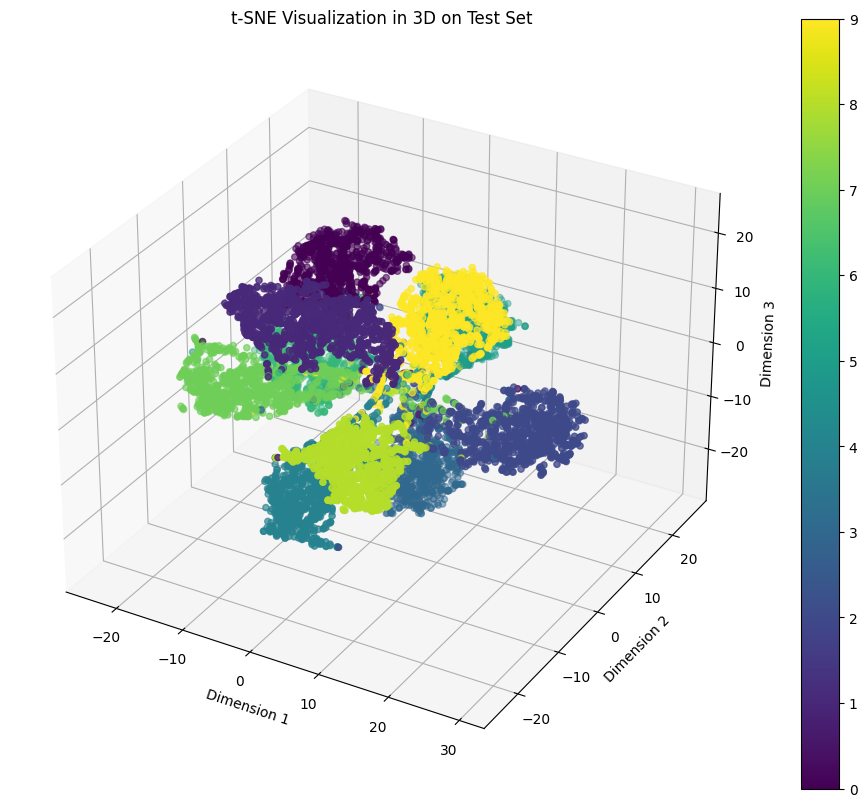

In [23]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting

# Load your test set
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

# Define your model and load the trained weights
model = ViT(image_size=(28, 28),
            patch_size=(7, 7),
            num_classes=10,
            dim=64,
            depth=2,
            heads=2,
            mlp_dim=64*2,
            pool='cls',
            channels=1,
            dim_head=64,
            dropout=0.1,
            emb_dropout=0.1
).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/ViT/Model/model_MNIST_v5_m03.pth'))
model.eval()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get embeddings for the entire test set
embeddings = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        images, batch_labels = batch
        images = images.to(device)
        batch_labels = batch_labels.to(device)

        # Get model outputs
        outputs = model(images)
        embeddings.append(outputs.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Concatenate embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE for visualization in 3D
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Visualize the t-SNE embeddings in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap='viridis')

ax.set_title("t-SNE Visualization in 3D on Test Set")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
fig.colorbar(scatter)
plt.show()

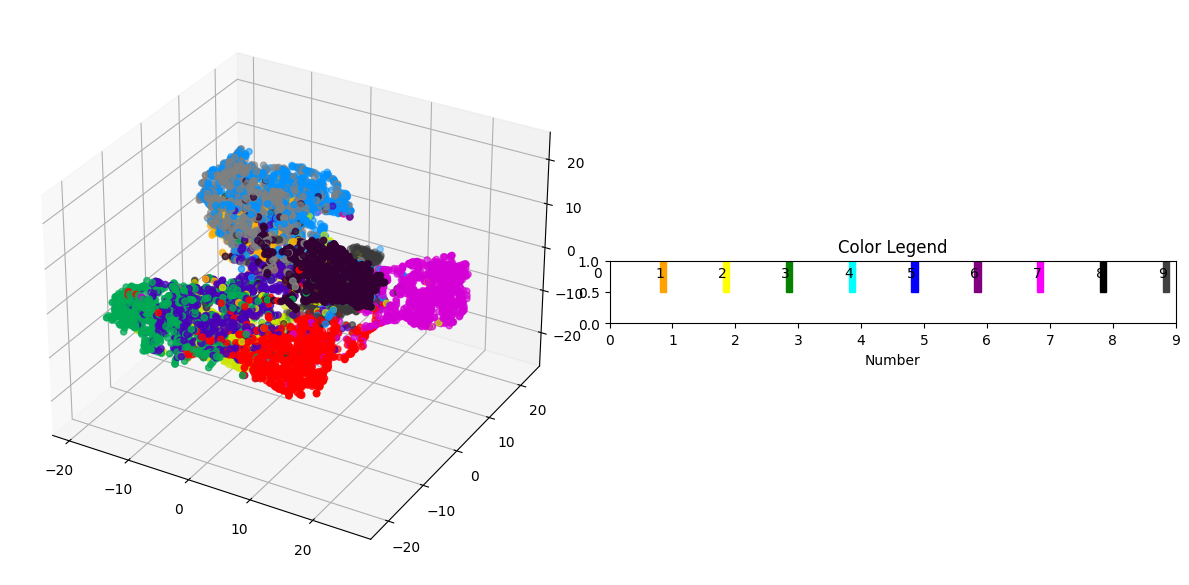

In [18]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap that maps each number to a unique color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [
    (0.0, 'red'),
    (0.1, 'orange'),
    (0.2, 'yellow'),
    (0.3, 'green'),
    (0.4, 'cyan'),
    (0.5, 'blue'),
    (0.6, 'purple'),
    (0.7, 'magenta'),
    (0.8, 'black'),
    (1.0, 'gray'),
])

# ...

# Visualize the t-SNE embeddings in 3D
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap=cmap)

# Create a sidebar Axes object
ax2 = fig.add_subplot(122, aspect='equal')

# Create rectangles for each number
for i in range(10):
    rectangle = patches.Rectangle((i - 0.2, 0.5), 0.1, 0.7, color=cmap(i / 10))
    ax2.add_patch(rectangle)

# Add labels to the rectangles
for i in range(10):
    label = ax2.text(i - 0.2, 0.8, str(i), color='black', ha='center', va='center')

ax2.set_xlabel('Number')
ax2.set_ylabel('')
ax2.set_title('Color Legend')
ax2.set_xticks(range(10))

# Add a tight_layout to ensure that both axes are displayed correctly
plt.tight_layout()

# Show the plot
plt.show()